# Sección común

### Montaje de drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Instalación dependencias

In [2]:
!pip install mido
!pip install mir_eval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100704 sha256=9ce78ed6338b782a7db8f12d6af437cdf2143304d8b7c06ae56b782f4d244cdc
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built mir_eval


### Importación de librerías

In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.init as init
import mido
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import mir_eval

### Lectura de dataset

In [4]:
# Directorio donde se encuentran los archivos zip
zip_dir = "/content/drive/My Drive/MAPS/"
# Directorio donde se descomprimirán los archivos
output_dir = "/content"

# Lista de archivos zip
zip_files = ["MAPS_ENSTDkAm_2.zip", "MAPS_ENSTDkCl_2.zip", "MAPS_AkPnBcht_2.zip", "MAPS_SptkBGCl_2.zip", "MAPS_AkPnBsdf_2.zip", "MAPS_AkPnCGdD_2.zip", "MAPS_AkPnStgb_2.zip", "MAPS_SptkBGAm_2.zip", "MAPS_StbgTGd2_2.zip"]
#zip_files = ["MAPS_SptkBGCl_2.zip"]
# Iterar sobre los archivos zip
for zip_file in zip_files:
    # Comando para descomprimir el archivo zip actual
    command = f"unzip '{os.path.join(zip_dir, zip_file)}' -d '{output_dir}'"
    # Ejecutar el comando
    os.system(command)


### Constantes

In [5]:
N_BINS_PER_OCTAVE=36
N_OUTPUT_NOTES=88
N_BINS=N_OUTPUT_NOTES*3
F_MIN=27.5
HOP_LENGTH=512
SAMPLING_RATE=16000
FRAME_DURATION=HOP_LENGTH/SAMPLING_RATE
# Secciones de audios igual duración
DURATION_PER_SECTION=2
N_FRAMES_PER_SECTION=int(DURATION_PER_SECTION / FRAME_DURATION)

# Verificar si hay disponibilidad de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Funciones comunes

### Lectura de datos

In [6]:
def get_midi(path):
  # Leer el archivo MIDI
  return mido.MidiFile(path)

def get_wav(path, sr=SAMPLING_RATE):
  # Cargar el archivo .wav y obtener la señal y la tasa de muestreo
  return librosa.load(path, sr=sr)

def get_pianoroll_from_txt(path, num_timesteps, total_time, num_notes=N_OUTPUT_NOTES):
  data = np.loadtxt(path, skiprows=1)

  if data.ndim == 1:
    data = data.reshape(1, -1)

  piano_roll=np.zeros((num_notes, num_timesteps))

  onset_times = data[:, 0]
  offset_times = data[:, 1]
  midi_pitches = data[:, 2]
  # Llena el piano-roll con las notas correspondientes
  for i in range(onset_times.shape[0]):
      onset_step = int(onset_times[i]/total_time * num_timesteps)
      offset_step = int(offset_times[i]/total_time * num_timesteps)
      # La tecla más grave del piano en formato MIDI es 21
      pitch = int(midi_pitches[i]-21)
      piano_roll[pitch, onset_step:offset_step] = 1
  return piano_roll

class SpecDataset(Dataset):
    def __init__(self, wav_paths, transform=None):
        self.transform = transform
        self.wav_paths=wav_paths
        self.features=[]
        self.labels=[]
        self.onset_labels=[]
        label_paths=[]
        # Obtener rutas etiquetas
        for path in wav_paths:
          label_paths += [path[:-4]+".txt" for path in wav_paths]

        # Obtener features y etiquetas
        for img_p, label_p in zip(wav_paths, label_paths):
          # Obtener las características y las etiquetas
          y, sr=get_wav(img_p)
          cqt = get_cqt(y, sr)
          N_SECTIONS=cqt.shape[1] // N_FRAMES_PER_SECTION

          duration=librosa.get_duration(y=y, sr=sr)
          label = get_pianoroll_from_txt(label_p, cqt.shape[1], duration)
          onset_label=notes_to_onsets(torch.tensor(label))

          for i in range(N_SECTIONS):
              self.features.append(cqt[:,i*N_FRAMES_PER_SECTION : (i+1)*N_FRAMES_PER_SECTION])
              self.labels.append(label[:,i*N_FRAMES_PER_SECTION : (i+1)*N_FRAMES_PER_SECTION])
              self.onset_labels.append(onset_label[:,i*N_FRAMES_PER_SECTION : (i+1)*N_FRAMES_PER_SECTION])

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
      feature=self.features[idx]
      label=self.labels[idx]
      onset_label=self.onset_labels[idx]
        # Aplicar transformaciones si se proporcionan
      if self.transform:
            feature = self.transform(feature)
      # Convertir numpy array a tensor de PyTorch
      feature = torch.from_numpy(feature)

      return feature, label, onset_label

def create_datasets(data_paths, Dataset, train_size=0.8, log_transform=True):
  wav_paths=[]
  for path in data_paths:
      wav_paths+=[y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.wav'))]
  wav_paths=sorted(wav_paths)
  # Dividir los archivos en train y validación
  train_wavs, val_wavs= train_test_split(wav_paths, train_size=train_size, random_state=42)

  train_features = []
  val_features = []

  train_dataset = Dataset(train_wavs)
  val_dataset = Dataset(val_wavs)

  # Definir la transformación para normalizar
  class Normalize(object):
      def __init__(self, mean, std):
          self.mean = mean
          self.std = std

      def __call__(self, tensor):
        if (log_transform):
            result=(np.log(tensor+10e-7) - self.mean) / self.std
        else:
            result=(tensor - self.mean) / self.std
        return result

  if (log_transform):
    # Usar la media y desviación típica calculada en MAPS tras log-transform
    mean = -6.3362346
    std = 2.29297
  else:
    # Usar la media y desviación típica calculada en MAPS
    mean = 0.014933423
    std = 0.048849646

  # Definir la transformación para normalizar
  normalize = Normalize(mean=mean, std=std)

  # Normalizar
  train_dataset.transform=normalize
  val_dataset.transform=normalize
  return train_dataset, val_dataset

def create_test_dataset(data_paths, Dataset):
  wav_paths=[]
  for path in data_paths:
      wav_paths+=[y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.wav'))]

  test_dataset = Dataset(wav_paths)

  # Definir la transformación para normalizar
  class Normalize(object):
      def __init__(self, mean, std):
          self.mean = mean
          self.std = std

      def __call__(self, tensor):
          return (np.log(tensor+10e-7) - self.mean) / self.std

  # Usar la media y desviación típica calculada en MAPS tras log-transform
  mean = -6.3362346
  std = 2.29297

  # Definir la transformación para normalizar
  normalize = Normalize(mean=mean, std=std)

  # Normalizar
  test_dataset.transform=normalize
  return test_dataset

### Procesado de pianorolls/note events

In [7]:
def get_pianoroll_from_midi(midi_file, hop_length=HOP_LENGTH, sr=SAMPLING_RATE, n_bins=N_OUTPUT_NOTES):
    # Inicializar el piano-roll con ceros
    max_time = int((midi_file.length * sr) / hop_length) + 1
    piano_roll = np.zeros((n_bins, max_time), dtype=int)

    # Recorrer todos los mensajes del archivo MIDI y actualizar el piano-roll
    current_time = 0
    for msg in midi_file:
        if msg.type == 'note_on' or msg.type == 'note_off':
            note = msg.note-21
            time = int(msg.time * sr / hop_length)
            if msg.type == 'note_on' and msg.velocity > 0:
                # Note on
                piano_roll[note, current_time + time:] = 1
            elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
                # Note off
                piano_roll[note, current_time + time:] = 0
            current_time += time
        elif msg.type=="control_change":
            time = int(msg.time * sr / hop_length)
            current_time += time
        else:
            print("Etiqueta MIDI desconocida:{}".format(msg))

    return piano_roll


def notes_to_onsets(pianoroll):
    # Desplazar la matriz pianoroll una columna hacia la derecha
    pianoroll_shifted = torch.roll(pianoroll, shifts=1, dims=1)

    # Comparar el pianoroll original con el pianoroll desplazado
    onsets = (pianoroll == 1) & (pianoroll_shifted == 0)

    # Asegurarse de que el primer frame no sea considerado un onset
    onsets[:, 0] = 0

    return onsets.float()

def note_events_to_piano_roll(note_events, n_bins, n_frames):
    piano_roll = torch.zeros((n_bins, n_frames), dtype=torch.float32)
    for note_event in note_events:
        start_time = note_event['start_time']
        end_time = note_event['end_time']
        pitch = note_event['pitch']
        piano_roll[pitch, start_time:end_time + 1] = 1
    return piano_roll

def pianoroll_to_note_events(piano_roll):
    note_events=[]
    for pitch in range(piano_roll.shape[0]):
        note_active=False
        note_event={"pitch":pitch}
        for t in range(piano_roll.shape[1]):
            is_now_active=piano_roll[pitch, t]
            if (not note_active and is_now_active):
                note_event["start_time"]=t
                note_active=True
            elif (note_active and not is_now_active):
                note_event["end_time"]=t-1
                note_active=False
                note_events.append(note_event)
                note_event={"pitch":pitch}
            elif (note_active and t==piano_roll.shape[1]-1):
                note_event["end_time"]=t
                note_active=False
                note_events.append(note_event)
                note_event={"pitch":pitch}
    return note_events

### Extracción de características

In [8]:
def get_cqt(y, sr, visualize=False):
  # Calcular el Constant-Q Transform (CQT)
  cqt = np.abs(librosa.cqt(y, sr=sr, bins_per_octave=N_BINS_PER_OCTAVE, n_bins=N_BINS, fmin=F_MIN, hop_length=HOP_LENGTH))

  # Mostrar el CQT
  if (visualize):
    plt.figure(figsize=(16, 4))
    librosa.display.specshow(librosa.amplitude_to_db(cqt, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note')
    plt.colorbar(format='%+2.0f dB')
    plt.title('CQT')
    plt.show()
  return cqt

def get_spectrogram(y, sr, visualize=False):
  # Calcular el espectrograma
  spectrogram = np.abs(librosa.stft(y))
  # Mostrar el espectrograma
  if (visualize):
    plt.figure(figsize=(16, 4))
    librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Espectrograma')
    plt.show()
  return spectrogram
def get_mel(y, sr, visualize=True):
    # Calcular el espectrograma
    spectrogram=np.abs(librosa.feature.melspectrogram(y=y, sr=sr, hop_length=HOP_LENGTH))
    # Mostrar el espectrograma
    if (visualize):
        plt.figure(figsize=(16, 4))
        librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Espectrograma Mel')
        plt.show()
    return spectrogram

### Visualización de datos

In [18]:
def visualize_piano_roll(piano_roll, cmap='Blues', title='Piano-Roll'):
    plt.figure(figsize=(16, 4))
    plt.imshow(piano_roll, aspect='auto', cmap=cmap, vmin=0, vmax=1, origin='lower', extent=[0,piano_roll.shape[1], 0,  piano_roll.shape[0]], interpolation="none")
    plt.xlabel('Tiempo')
    plt.ylabel('Nota')
    plt.title(title)
    plt.show()

def plot_lr_curves(train_losses, val_losses):
    # Graficar la pérdida de entrenamiento y validación
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Entrenamiento')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Función de pérdida en entrenamiento y validación')
    plt.legend()
    plt.show()

def print_midi(path):
  midi_file=get_midi(path)
  # Mostrar los tokens
  for i, track in enumerate(midi_file.tracks):
      print(f"Track {i}:")
      for msg in track[:50]:
          print(msg)

### Entrenamiento

In [10]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
def balanced_pos_weight(train_dataset):
    # Obtiene las etiquetas del conjunto de datos de entrenamiento
    train_labels = []
    for idx in range(len(train_dataset)):
        _, label = train_dataset[idx]
        train_labels.append(label)

    # Convertir la lista de etiquetas en un tensor de PyTorch
    train_labels_tensor = torch.tensor(train_labels).to(device)
    # Calcula la proporción de muestras positivas en tus datos
    # por ejemplo:
    num_positives = (train_labels_tensor == 1).sum()
    num_negatives = (train_labels_tensor == 0).sum()
    proporcion_positivas = num_positives / (num_positives + num_negatives)
    print("Proporción de etiquetas positivas:", proporcion_positivas)

    pos_weight = torch.tensor([1.0 / proporcion_positivas]).to(device)

    return pos_weight

In [11]:
import torch.nn.functional as F
from torchvision.ops import sigmoid_focal_loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        return sigmoid_focal_loss(inputs, targets, alpha=self.alpha, gamma=self.gamma, reduction='mean')


## Post-procesado

In [12]:
def post_process_outputs(output_notes, output_onset, tolerance=2, onset_thres=0.5, note_thres=0.3, add_note_thres=0.5):
    # Tomar como candidatos peak onsets con probabilidad > 0.5
    # Calcula la matriz de diferencias para detectar los picos
    diff_tensor = torch.diff(output_onset, dim=1)

    # Encuentra las posiciones donde la diferencia cambia de positivo a negativo
    positive_to_negative = torch.nonzero((diff_tensor[:, :-1] > 0) & (diff_tensor[:, 1:] < 0))

    # Ajusta las posiciones para considerar el desplazamiento por torch.diff
    onset_candidates = list(zip(positive_to_negative[:, 0], positive_to_negative[:, 1] + 1))

    # Filtra los candidatos según el umbral
    onset_candidates = [(i[0].item(), i[1].item()) for i in onset_candidates if output_onset[i[0].item(), i[1].item()] >= onset_thres]

    # Crear eventos de notas a partir de los candidatos y las probabilidades de notas
    note_events = []
    for onset in onset_candidates[::-1]:  # Iterar en orden temporal inverso
        start_time = onset[1]
        pitch = onset[0]
        end_time = start_time
        under_thres=0
        for t in range(start_time + 1, output_notes.shape[1]):
            if (output_notes[pitch,t]<note_thres):
                under_thres+=1
            else:
                under_thres=0
                end_time=t
            if (under_thres>=tolerance):
                break
        # No tener en cuenta la nota si es muy corta
        note_duration=(end_time+1-start_time)*FRAME_DURATION

        output_notes[pitch, start_time:end_time + 1] = 0
        note_events.append({"start_time":start_time, "end_time":end_time, "pitch": pitch})
    # Crear eventos de notas adicionarles a partir de las probabilidades de notas
    for pitch in range(output_notes.shape[0]):
        for frame in range(output_notes.shape[1]):
            likelihood=output_notes[pitch, frame]
            if (likelihood > add_note_thres):
                start_time=frame
                end_time=frame
                under_thres=0
                for t in range(frame + 1, output_notes.shape[1]):
                    if (output_notes[pitch,t]<note_thres):
                        under_thres+=1
                    else:
                        under_thres=0
                        end_time=t
                    if (under_thres>=tolerance):
                        break
                under_thres=0
                for t in range(frame - 1, 0, -1):
                    if (output_notes[pitch,t]<note_thres):
                        under_thres+=1
                    else:
                        under_thres=0
                        start_time=t
                    if (under_thres>=tolerance):
                        break
                # No tener en cuenta la nota si es muy corta
                note_duration=(end_time+1-start_time)*FRAME_DURATION
                output_notes[pitch, start_time:end_time + 1] = 0
                note_events.append({"start_time":start_time, "end_time":end_time, "pitch": pitch})

    return note_events

In [13]:
def post_process_outputs_no_onsets(output_notes, tolerance=2, note_thres=0.3, add_note_thres=0.5):
    # Crear eventos de notas a partir de los candidatos y las probabilidades de notas
    note_events = []
    # Crear eventos de notas adicionales a partir de las probabilidades de notas
    for pitch in range(output_notes.shape[0]):
        for frame in range(output_notes.shape[1]):
            likelihood=output_notes[pitch, frame]
            if (likelihood > add_note_thres):
                start_time=frame
                end_time=frame
                under_thres=0
                for t in range(frame + 1, output_notes.shape[1]):
                    if (output_notes[pitch,t]<note_thres):
                        under_thres+=1
                    else:
                        under_thres=0
                        end_time=t
                    if (under_thres>=tolerance):
                        break
                under_thres=0
                for t in range(frame - 1, 0, -1):
                    if (output_notes[pitch,t]<note_thres):
                        under_thres+=1
                    else:
                        under_thres=0
                        start_time=t
                    if (under_thres>=tolerance):
                        break
                # No tener en cuenta la nota si es muy corta
                note_duration=(end_time+1-start_time)*FRAME_DURATION
                output_notes[pitch, start_time:end_time + 1] = 0
                note_events.append({"start_time":start_time, "end_time":end_time, "pitch": pitch})
    return note_events

## Validación

In [14]:
def note_tp_fp_fn(ref_intervals, ref_pitches, est_intervals, est_pitches,offset_ratio=0.2):
    mir_eval.transcription.validate(ref_intervals, ref_pitches, est_intervals, est_pitches)

    matching = mir_eval.transcription.match_notes(ref_intervals, ref_pitches, est_intervals, est_pitches,offset_ratio=offset_ratio)

    tp=len(matching)
    fp=len(est_pitches)-tp
    fn=len(ref_pitches)-tp
    return tp, fp, fn

def get_note_wise_metrics(predicted_note_events, label_note_events, offset_ratio=0.2):
    # Obtener onsets y offsets de las notas de cada sección
    ref_intervals=[np.array([[note["start_time"]* FRAME_DURATION, (note["end_time"]+1)* FRAME_DURATION] for note in section]) if len(section)>0 else np.empty((0, 2)) for section in label_note_events]
    est_intervals=[np.array([[note["start_time"]* FRAME_DURATION, (note["end_time"]+1)* FRAME_DURATION] for note in section]) if len(section)>0 else np.empty((0, 2)) for section in predicted_note_events]
    # Obtener frecuencias de las notas
    ref_pitches=[np.array([F_MIN*2**(note["pitch"]/12) for note in section]) for section in label_note_events]
    est_pitches=[np.array([F_MIN*2**(note["pitch"]/12) for note in section]) for section in predicted_note_events]

    #Calcular onset F1, precision y recall
    result= [note_tp_fp_fn(r_i, r_p, e_i, e_p, offset_ratio=offset_ratio) for r_i, r_p, e_i, e_p in zip(ref_intervals, ref_pitches, est_intervals, est_pitches)]
    result=np.array(result)
    result=np.sum(result, axis=0)
    tp, fp, fn=result[0], result[1], result[2]

    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    f1=(2*precision*recall)/(precision+recall)

    return f1, precision, recall

def get_onset_metrics_per_pitch(total_predicted_pianoroll, total_label_pianoroll):
    # Obtener onsets de predicción y etiquetas en segundos
    predicted_note_events=[pianoroll_to_note_events(np.expand_dims(np.array(pitch), axis=0)) for pitch in total_predicted_pianoroll]
    predicted_onsets=[[note["start_time"] * FRAME_DURATION for note in pitch] for pitch in predicted_note_events]
    label_note_events=[pianoroll_to_note_events(np.expand_dims(np.array(pitch), axis=0)) for pitch in total_label_pianoroll]
    label_onsets=[[note["start_time"] * FRAME_DURATION for note in pitch] for pitch in label_note_events]

    # Ordenar onsets de cada pitch por tiempo
    label_onsets=[np.array(sorted(label)) for label in label_onsets]
    predicted_onsets=[np.array(sorted(predicted)) for predicted in predicted_onsets]

    # Obtener métricas de error por nota
    metrics=np.array([mir_eval.onset.f_measure(labels, predicted) for labels, predicted in zip(label_onsets, predicted_onsets) if len(labels) > 0 and len(predicted)>0] )
    return np.array(metrics[:,0]), np.array(metrics[:, 1]), np.array(metrics[:,2])

def show_n_notes(n_predicted_notes, n_label_notes):
    # Configuración del gráfico
    bar_width = 0.4
    index = np.arange(len(n_label_notes))

    # Crear el gráfico de barras
    plt.figure(figsize=(20, 6))

    # Barras para el dataset
    plt.bar(index, n_label_notes, bar_width, label='Etiquetas', color='firebrick')

    # Barras para las predicciones
    plt.bar(index + bar_width, n_predicted_notes, bar_width, label='Predicciones', color='royalblue')

    # Etiquetas y título
    plt.xlabel('Nota musical (Tono)')
    plt.ylabel('Número de veces')
    plt.title('Comparación entre el dataset y las predicciones del modelo')
    plt.xlim(0, 87)
    plt.legend()

    # Mostrar el gráfico
    plt.show()
# Calcular métricas por frame
def get_frame_metrics(frame_predictions, frame_labels):
    accuracy = accuracy_score(frame_labels, frame_predictions)
    precision = precision_score(frame_labels, frame_predictions, average='micro')
    recall = recall_score(frame_labels, frame_predictions, average='micro')
    f1 = f1_score(frame_labels, frame_predictions, average='micro')
    return accuracy, precision, recall, f1
# Matriz de confusión
def show_confusion_matrix(frame_predictions, frame_labels, console=False):
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(frame_labels.flatten(), frame_predictions.flatten())

    # Calcular porcentajes
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

    if (console):
        print(conf_matrix_percent)
    else:
        # Plotear la matriz de confusión como un mapa de calor
        plt.figure(figsize=(10, 8))
        sns.set(font_scale=1.2)  # Escala de fuente para mejorar la legibilidad
        sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.1f', cbar=True, square=True,
                    xticklabels=['No presionado', 'Presionado'], yticklabels=['No presionado', 'Presionado'])
        plt.xlabel('Etiqueta predicha')
        plt.ylabel('Etiqueta verdadera')
        plt.title('Matriz de confusión normalizada')
        plt.show()

def show_model_outputs(model, loader, n_batchs=5, onsets=True):
    # Calcular las predicciones en el conjunto de validación
    total_output_notes = []
    total_output_onsets = []
    model.eval()
    with torch.no_grad():
        if (onsets):
            for i, (cqt, target_notes, _) in enumerate(loader):
                # Obtener espectrograma pasar como input al modelo
                cqt, target_notes = cqt.to(device), target_notes.to(device)
                target_onsets= torch.stack([notes_to_onsets(notes) for notes in target_notes])
                output_notes, output_onsets = model(cqt)
                # Eliminar la dimensión de los canales
                output_notes=torch.squeeze(output_notes)
                output_onsets=torch.squeeze(output_onsets)
                # Aplicar sigmoide para obtener predicción binaria
                output_notes=torch.sigmoid(output_notes)
                output_onsets=torch.sigmoid(output_onsets)
                # Concatenar los posterior-gramas de un batch
                output_notes=torch.cat(tuple(output_notes), dim=1)
                output_onsets=torch.cat(tuple(output_onsets), dim=1)
                target_notes=torch.cat(tuple(target_notes), dim=1)

                visualize_piano_roll(target_notes.cpu(), title=f"Etiquetas de batch {i+1}")
                visualize_piano_roll(output_notes.cpu(), title="Posterior-grama notas")
                # Obtener onsets a partir de etiquetas
                target_onsets=notes_to_onsets(target_notes)

                visualize_piano_roll(target_onsets.cpu(), title="Onsets de las etiquetas")
                visualize_piano_roll(output_onsets.cpu(), title="Posterior-grama onsets")
                if (i==n_batchs):
                    break
        else:
            for i, (cqt, target_notes) in enumerate(loader):
                # Obtener espectrograma pasar como input al modelo
                cqt, target_notes = cqt.to(device), target_notes.to(device)
                output_notes = model(cqt)
                # Eliminar la dimensión de los canales
                output_notes=torch.squeeze(output_notes)
                # Aplicar sigmoide para obtener predicción binaria
                output_notes=torch.sigmoid(output_notes)
                # Concatenar los posterior-gramas de un batch
                output_notes=torch.cat(tuple(output_notes), dim=1)
                target_notes=torch.cat(tuple(target_notes), dim=1)

                visualize_piano_roll(target_notes.cpu(), title=f"Etiquetas de batch {i+1}")
                visualize_piano_roll(output_notes.cpu(), title="Posterior-grama notas")
                # Obtener onsets a partir de etiquetas
                if (i==n_batchs):
                    break
    return total_output_notes, total_output_onsets
# Obtener predicciones de un modelo (con post-procesado)
def get_model_predictions(model, loader, onsets=False):
    # Calcular las predicciones en el conjunto de validación
    predicted_pianorolls = []
    predicted_note_events = []
    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(loader):
            cqt = sample[0].to(device)
            if (onsets):
                # Obtener espectrograma pasar como input al modelo
                output_notes, output_onsets = model(cqt)
                # Eliminar la dimensión de los canales
                output_notes=torch.squeeze(output_notes)
                output_onsets=torch.squeeze(output_onsets)
                # Aplicar sigmoide para obtener predicción binaria
                output_notes=torch.sigmoid(output_notes)
                output_onsets=torch.sigmoid(output_onsets)
                # Aplicar el post-procesado a las salidas del modelo
                note_events=[post_process_outputs(o_n, o_o) for o_n, o_o in zip(output_notes, output_onsets)]
            else:
                output_notes = model(cqt)
                # Eliminar la dimensión de los canales
                output_notes=torch.squeeze(output_notes)
                # Aplicar sigmoide para obtener predicción binaria
                output_notes=torch.sigmoid(output_notes)
                # Aplicar el post-procesado a las salidas del modelo
                note_events=[post_process_outputs_no_onsets(o_n) for o_n in output_notes]
            for n_e in note_events:
                predicted_note_events.append(n_e)
                predicted_pianorolls.append(note_events_to_piano_roll(n_e, output_notes.shape[1], output_notes.shape[2]))
            if (i%10==9):
                print(f"Batch {i+1} completado")
    return predicted_pianorolls, predicted_note_events

# Obtener numero de notas por tono
def count_pitch_from_note_events(note_events):
    pitch_count=[0]*N_OUTPUT_NOTES
    for section in note_events:
        for note in section:
            pitch = note['pitch']
            pitch_count[pitch] += 1
    return pitch_count

def show_pitch_f1s():
    # Mostrar F1 en cada nota
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(pitch_f1s)), pitch_f1s)
    plt.xlabel('Nota musical (Tono)')
    plt.ylabel('F1')
    plt.title('Onset F1 en cada nota musical')
    plt.show()

# Exploración de datos

## Contenido de archivo MIDI de ejemplo

In [19]:
# Ruta al archivo MIDI en Google Drive
midi_file_path = '/content/ENSTDkAm/MUS/MAPS_MUS-chpn_op66_ENSTDkAm.mid'

print_midi(midi_file_path)

Track 0:
MetaMessage('set_tempo', tempo=439440, time=0)
note_on channel=0 note=44 velocity=79 time=38401
note_on channel=0 note=56 velocity=79 time=298
control_change channel=0 control=64 value=0 time=223
control_change channel=0 control=64 value=127 time=12303
note_off channel=0 note=44 velocity=79 time=190813
note_off channel=0 note=56 velocity=79 time=223
note_on channel=0 note=37 velocity=75 time=0
note_on channel=0 note=49 velocity=75 time=299
control_change channel=0 control=64 value=0 time=5144
control_change channel=0 control=64 value=127 time=3878
note_off channel=0 note=37 velocity=75 time=3431
note_off channel=0 note=49 velocity=75 time=74
note_on channel=0 note=56 velocity=60 time=224
note_off channel=0 note=56 velocity=60 time=9395
note_on channel=0 note=61 velocity=64 time=0
note_off channel=0 note=61 velocity=64 time=9097
note_on channel=0 note=64 velocity=65 time=75
note_off channel=0 note=64 velocity=65 time=8799
note_on channel=0 note=61 velocity=62 time=298
note_off 

## Extracción de características

16000


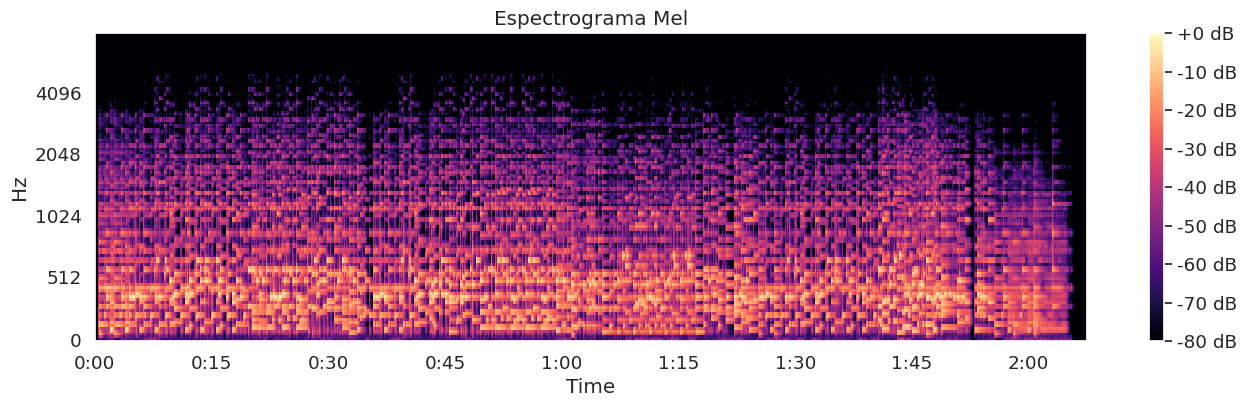

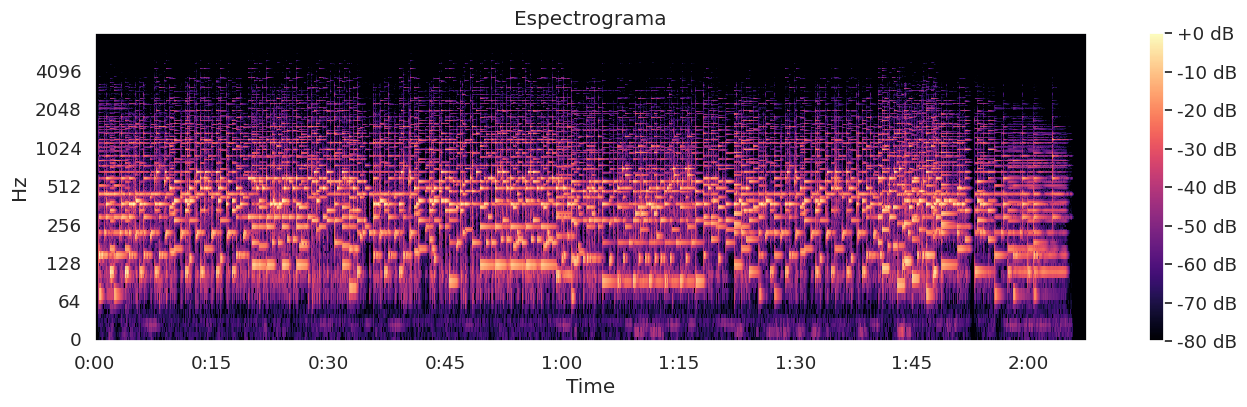

<ipython-input-68-dcb16e406e2a>:8: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(librosa.amplitude_to_db(cqt, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note')


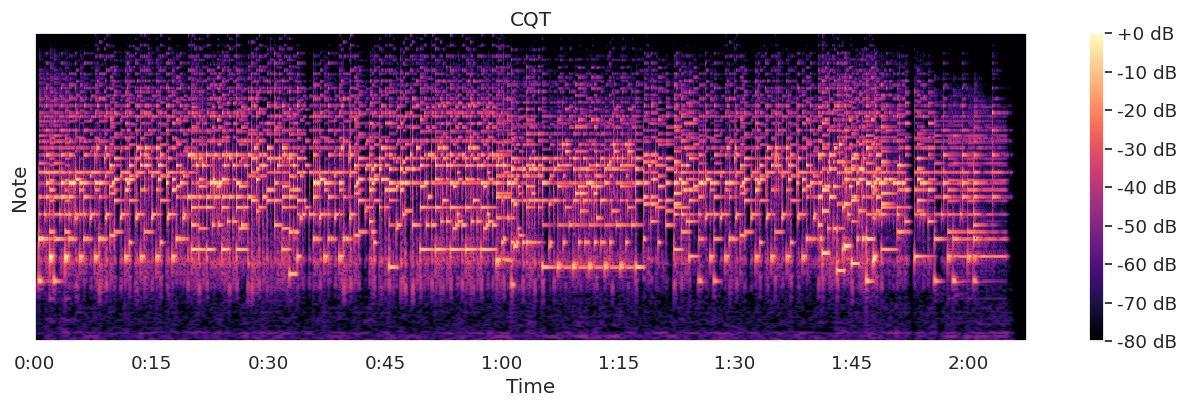

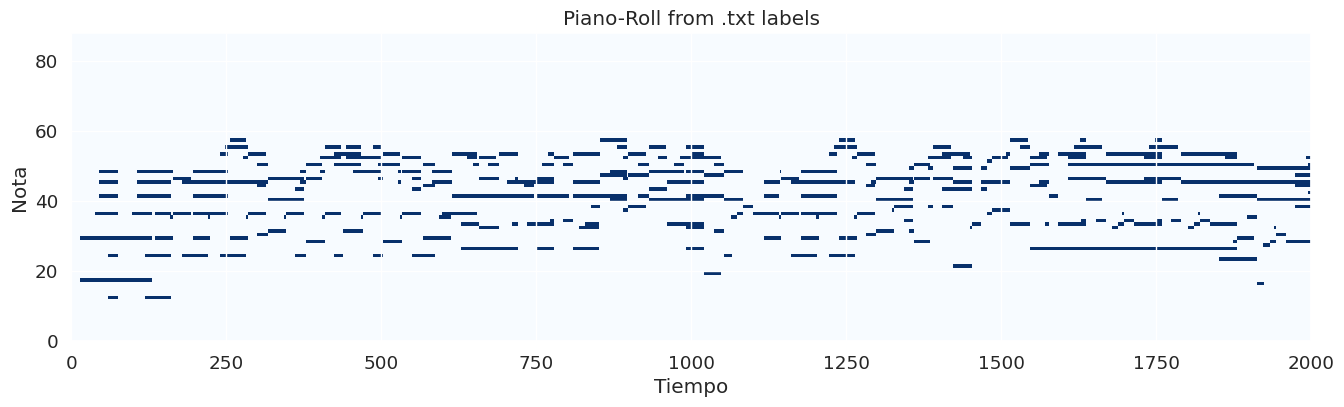

Tamaño de la etiqueta .txt (piano-roll): (88, 3983)
Etiqueta MIDI desconocida:MetaMessage('set_tempo', tempo=439440, time=0)
Etiqueta MIDI desconocida:MetaMessage('end_of_track', time=0)


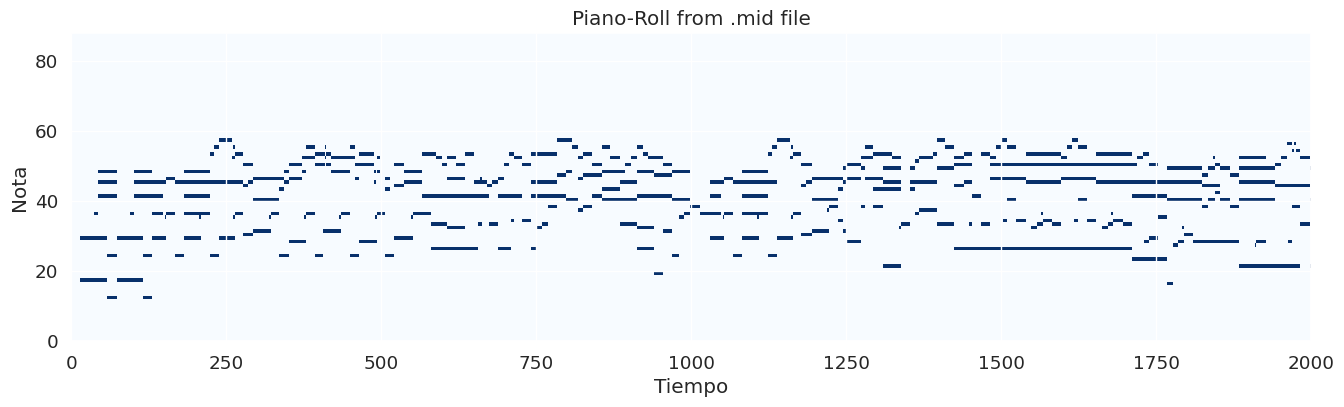

Tamaño de la etiqueta MIDI (piano-roll): (88, 3921)


In [ ]:
wav_file_path = '/content/SptkBGCl/MUS/MAPS_MUS-alb_esp2_SptkBGCl.wav'
y,sr=get_wav(wav_file_path)
print(sr)
label_path=wav_file_path[:-4]+".txt"
mel=get_mel(y, sr, visualize=True)
spectrogram=get_spectrogram(y, sr, visualize=True)
cqt=get_cqt(y, sr, visualize=True)
duration=librosa.get_duration(y=y, sr=sr)
# Mostrar parte del piano-roll obtenido del archivo de texto
label=get_pianoroll_from_txt(label_path, cqt.shape[1], duration)
visualize_piano_roll(label[:, :2000], title="Piano-Roll from .txt labels")
print("Tamaño de la etiqueta .txt (piano-roll):", label.shape)
# Mostrar parte del piano-roll obtenido del MIDI
midi_file_path = '/content/SptkBGCl/MUS/MAPS_MUS-alb_esp2_SptkBGCl.mid'
midi_file=get_midi(midi_file_path)
label=get_pianoroll_from_midi(midi_file)
visualize_piano_roll(label[:, :2000], title="Piano-Roll from .mid file")
print("Tamaño de la etiqueta MIDI (piano-roll):", label.shape)

In [ ]:
print("Duracion del archivo MIDI", midi_file.length)
print("Duración del archivo WAV", duration)
print("Tamaño de la CQT", cqt.shape)
print("Tamaño del espectrograma", spectrogram.shape)
print("Tamaño del espectrograma Mel", mel.shape)

Duracion del archivo MIDI 125.4559290456863
Duración del archivo WAV 127.4559375
Tamaño de la CQT (264, 3983)
Tamaño del espectrograma (1025, 3983)
Tamaño del espectrograma Mel (128, 3983)


## Curvas de aprendizaje U-Net MAESTRO

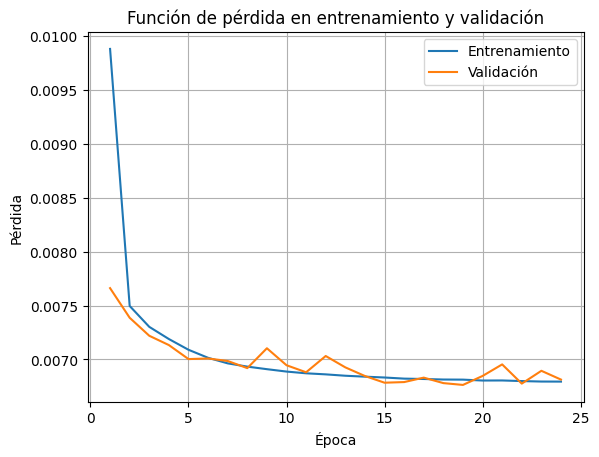

In [ ]:
import matplotlib.pyplot as plt

# Data
train_loss = [
    0.009880446392658447, 0.0074959391223946735, 0.0073020813651087264,
    0.0071890276512278925, 0.0070894400547775955, 0.007014915966207073,
    0.006963398272674235, 0.006933173435843653, 0.006909444150145328,
    0.006887295146931022, 0.006871210686005061, 0.006861304541428884,
    0.006848562268008079, 0.006839970185140532,0.006832190320220968,
    0.006821820588693732,0.00681834267481925,0.006813438089327916,
    0.006812486561488301,0.006804094246278206,0.006804734341918476,
    0.006799148758134198,0.006794704291230393,0.006794212694531159
]
val_loss = [
    0.007661233638524815, 0.0073863766404732205, 0.007219327383912362,
    0.0071330519610152505, 0.0070032329713285435, 0.007008604976969461,
    0.0069853821939129075, 0.006919185817726732, 0.0071034010925359325,
    0.00694599680173269, 0.006880769578250086, 0.00703167858288604,
    0.006926195766936871, 0.006845936505972834,0.006783959736518834,
    0.006789784598367987,0.006831032577489775,0.006780144702740169,
    0.006763387790973259,0.006846556600673163,0.006953735241647034,
    0.006775505923239204,0.006894396069886473,0.006812908827365997
]
epochs = list(range(1, len(train_loss)+1))

# Plot
plt.plot(epochs, train_loss, label='Entrenamiento')
plt.plot(epochs, val_loss, label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Función de pérdida en entrenamiento y validación')
plt.legend()
plt.grid(True)
plt.show()


## Curvas de aprendizaje BP2. MAESTRO

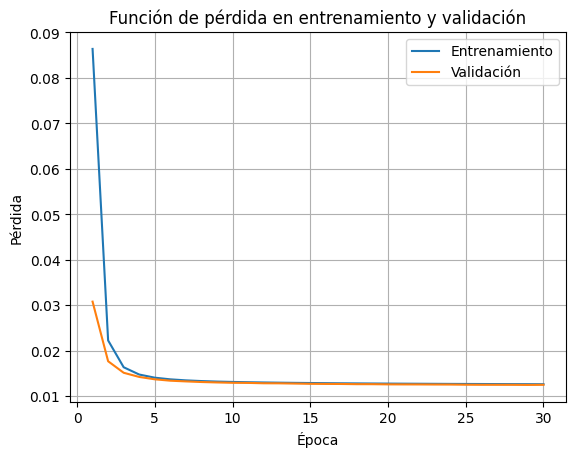

In [ ]:
import matplotlib.pyplot as plt

# Data
train_loss = [
    0.08638360845823276 ,0.022268500781811886 ,0.01636824916060163 ,
    0.014764757465268603 ,0.0140717677195287 ,0.013705759414419682 ,
    0.013480572956543284 ,0.013327703735587863 ,0.013216163017574301 ,
    0.013136187712496458 ,0.013070551860548065 ,0.013017446302624448 ,
    0.012972994965174931 ,0.012931928199332983 ,0.012897941679811946 ,
    0.012866130080972302 ,0.012836923233001743 ,0.012813929188287424 ,
    0.012791555750699062 ,0.012771325540459398 ,0.012752030512819134 ,
    0.012736554453764017 ,0.012719051733962851 ,0.012702924227767486 ,
    0.012691215834187978 ,0.012678035287905088 ,0.012667102228642115 ,
    0.012655356606979131 ,0.012643487655987896 ,0.012632706957788864
]
val_loss = [
    0.030798336296963196,0.017687886089940246,0.015153215548101192,
    0.014234782671943927,0.013716873402396837,0.013410118321189657,
    0.013252812190330587,0.013119325051472211,0.013024270854657516,
    0.012947477322692672,0.012924497588149583,0.012843702114575231,
    0.012830269823704535,0.012778524910875907,0.012724480349182462,
    0.012699636373630105,0.012687985790156139,0.012644153253252929,
    0.012640974872435132,0.01260199726675637,0.012591844303339409,
    0.012585297973904138,0.01256954354660896,0.012561876418961523,
    0.012525294140990203,0.012509585581331825,0.01250701599929016,
    0.012503330712206662,0.012479301842783267,0.0125076591745407
]
epochs = list(range(1, len(train_loss)+1))

# Plot
plt.plot(epochs, train_loss, label='Entrenamiento')
plt.plot(epochs, val_loss, label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Función de pérdida en entrenamiento y validación')
plt.legend()
plt.grid(True)
plt.show()

## Matriz de confusión UNetH MAESTRO

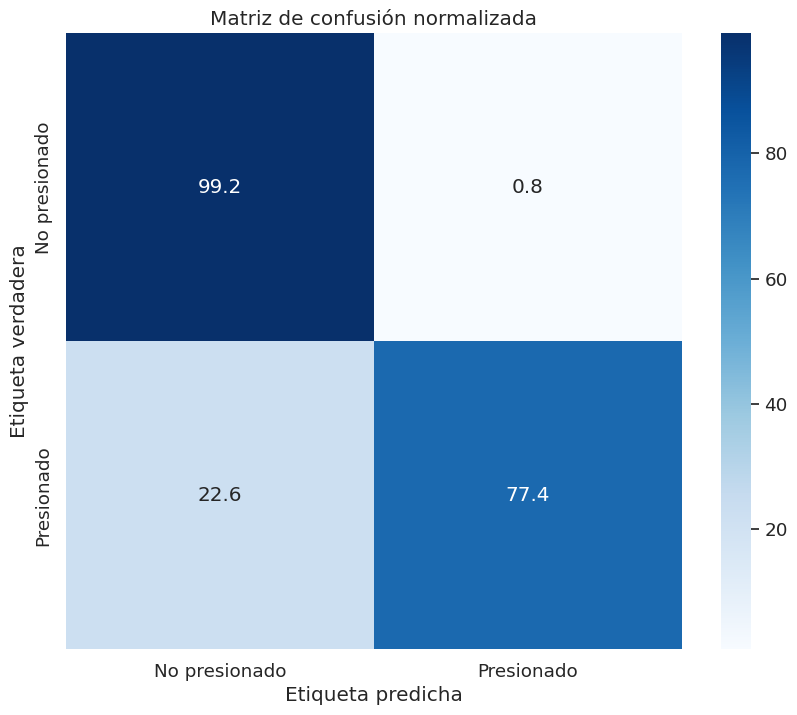

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix_percent=[[99.15493534, 0.84506466],
                    [22.64529349, 77.35470651]]
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Escala de fuente para mejorar la legibilidad
sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.1f', cbar=True, square=True,
            xticklabels=['No presionado', 'Presionado'], yticklabels=['No presionado', 'Presionado'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión normalizada')
plt.show()

## Matriz de confusión BP2 MAESTRO

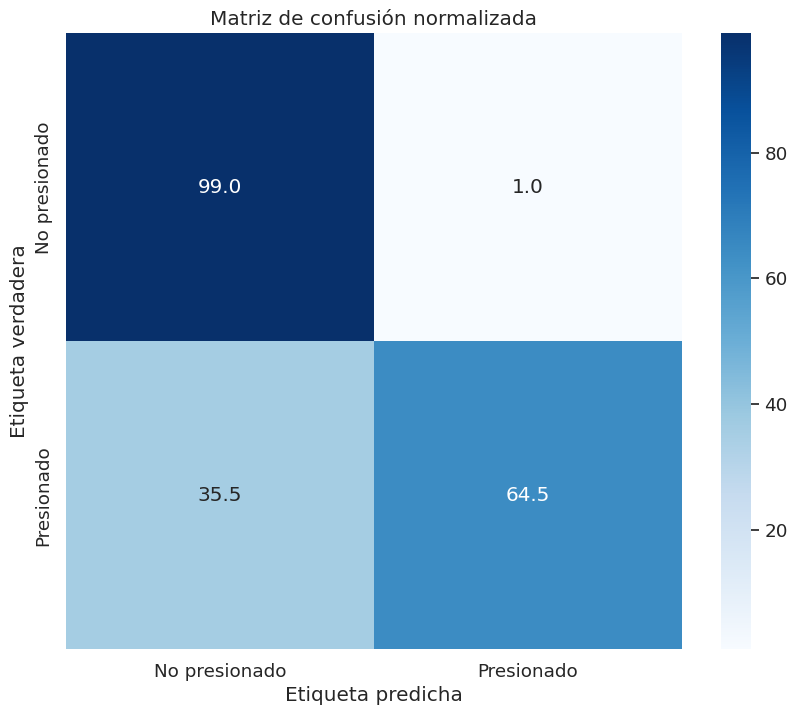

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix_percent=[[98.98203727, 1.01796273],
                     [35.48924123, 64.51075877]]
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Escala de fuente para mejorar la legibilidad
sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.1f', cbar=True, square=True,
            xticklabels=['No presionado', 'Presionado'], yticklabels=['No presionado', 'Presionado'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión normalizada')
plt.show()

# Modelo DNN

## Cargar el dataset

In [ ]:
class FrameDataset(Dataset):
    def __init__(self, wav_paths, transform=None):
        self.transform = transform
        self.wav_paths=wav_paths
        audio_frames=[]
        label_paths=[]
        # Obtener rutas etiquetas
        for path in wav_paths:
          label_paths += [path[:-4]+".txt" for path in wav_paths]
        # Inicializar features y etiquetas
        self.features=[]
        self.labels=[]
        # Obtener features y etiquetas
        for img_p, label_p in zip(wav_paths, label_paths):
          # Obtener las características y las etiquetas
          y, sr=get_wav(img_p)
          cqt = get_cqt(y, sr)
          duration=librosa.get_duration(y=y, sr=sr)
          label = get_pianoroll_from_txt(label_p, cqt.shape[1], duration)
          # label = get_pianoroll_from_midi(label_p)
          for i in range(cqt.shape[1]):
            self.features.append(cqt[:,i])
            self.labels.append(label[:,i])
          audio_frames.append(cqt.shape[1])
        self.audio_frames=audio_frames
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
      feature=self.features[idx]
      label=self.labels[idx]
      # Convertir numpy array a tensor de PyTorch
      feature = torch.from_numpy(feature)
        # Aplicar transformaciones si se proporcionan
      if self.transform:
          feature = self.transform(feature)

      return feature, label

In [ ]:
# Rutas al dataset
data_paths = ['/content/AkPnBcht/MUS','/content/AkPnBsdf','/content/AkPnCGdD',
              '/content/AkPnStgb','/content/SptkBGAm','/content/SptkBGCl', '/content/StbgTGd2']
train_dataset, val_dataset=create_datasets(data_paths, FrameDataset, log_transform=True)

# Crear un DataLoader para el dataset
BATCH_SIZE = 64
num_workers = 0  # Número de procesos para cargar los datos

# Crear los DataLoaders para entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

print("Número de ejemplos en validación:", len(val_dataset))
print("Número de ejemplos en train:", len(train_dataset))

Número de ejemplos en validación: 281912
Número de ejemplos en train: 1264193


### Arquitectura DNN

In [ ]:
# Definir la arquitectura de la red neuronal
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(256, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.4)

        self.fc4 = nn.Linear(256, output_size)

    def forward(self, x):
        x = x.to(self.fc1.weight.dtype)  # Convertir x al mismo tipo de datos que self.fc1.weight
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

### Entrenamiento

In [ ]:
# Hiperparámetros
learning_rate = 0.0001
epochs = 50

# Objeto para llevar a cabo early stopping
early_stopper = EarlyStopper(patience=3, min_delta=0)

# Crear la red y moverla a la GPU si está disponible
model = SimpleNN(N_BINS, N_OUTPUT_NOTES).to(device)

# Definir optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define la función de pérdida
criterion = FocalLoss()

# Directorio en Google Drive donde se guardará el modelo
save_path = '/content/drive/My Drive/TFG/all_7.pth'

# Lista para almacenar la pérdida de entrenamiento y validación de cada época
train_losses = []
val_losses = []

# Entrenar la red
for epoch in range(epochs):
    # Entrenamiento
    model.train()
    train_loss = 0.0
    for i, (cqt_column, target_piano_roll) in enumerate(train_loader):
        cqt_column, target_piano_roll = cqt_column.to(device), target_piano_roll.to(device)
        optimizer.zero_grad()
        output_piano_roll = model(cqt_column)
        loss = criterion(output_piano_roll, target_piano_roll)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for cqt_column, target_piano_roll in val_loader:
            cqt_column, target_piano_roll = cqt_column.to(device), target_piano_roll.to(device)

            output_piano_roll = model(cqt_column)
            loss = criterion(output_piano_roll, target_piano_roll)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    if early_stopper.early_stop(val_loss):
        print("Entrenamiento finalizado con Early Stopping")
        break
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss}, Validation Loss: {val_loss}')
    # Guardar el modelo entrenado en Google Drive
    torch.save(model.state_dict(), save_path)

Epoch [1/50], Train Loss: 0.006956190756244372, Validation Loss: 0.007477073599931694
Epoch [2/50], Train Loss: 0.005117623867076666, Validation Loss: 0.00729316698826426
Epoch [3/50], Train Loss: 0.0047671625348543, Validation Loss: 0.0073701789967231205
Epoch [4/50], Train Loss: 0.0045739002472013944, Validation Loss: 0.007344192108835759
Entrenamiento finalizado con Early Stopping


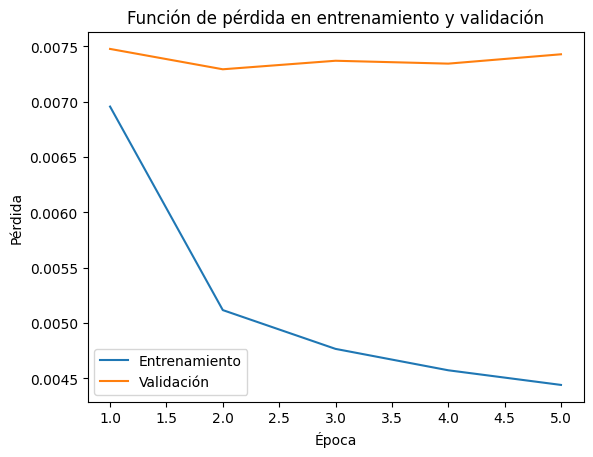

In [ ]:
plot_lr_curves(train_losses, val_losses)

## Validación

## Cargar modelo pre-entrenado de Drive

In [ ]:
# Crear la red y moverla a la GPU si está disponible
model = SimpleNN(N_BINS, N_OUTPUT_NOTES).to(device)

# Ruta con los pesos del modelo
model_path = '/content/drive/MyDrive/TFG/all_7.pth'
# Carga los pesos al modelo
model.load_state_dict(torch.load(model_path, map_location=device))

n_params=sum(p.numel() for p in model.parameters())
print("El número de parámetros del modelo es:", n_params)

El número de parámetros del modelo es: 223576


### Métricas de error por frame

Accuracy: 0.21734796674139448
Precision: 0.9765494893557254
Recall: 0.45858655812156673
F1 Score: 0.6240975828685004


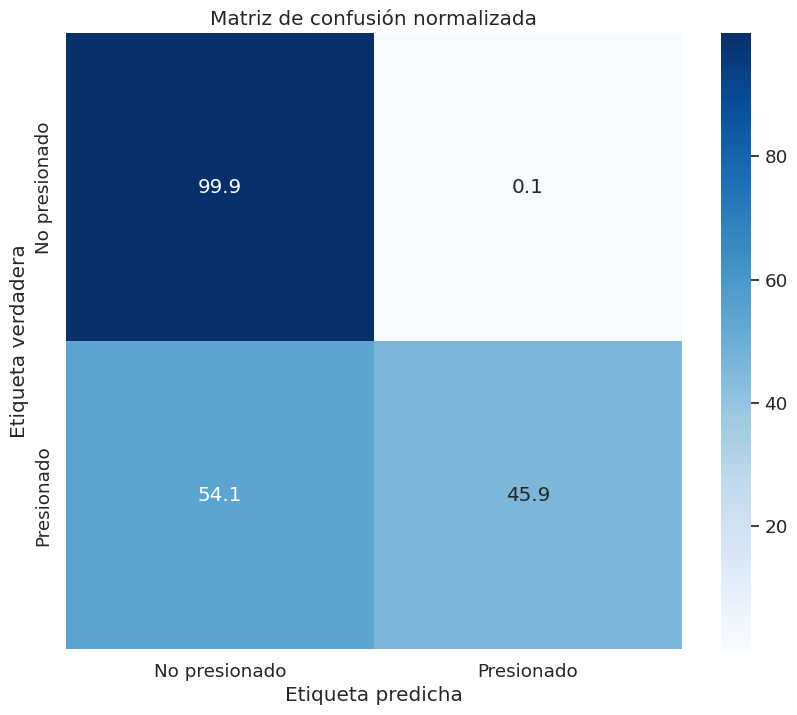

In [ ]:
# Función para convertir las probabilidades en etiquetas binarias
def binarize_predictions(predictions, threshold=0.5):
    return np.where(predictions > threshold, 1.0, 0.0)

# Calcular las predicciones en el conjunto de validación
frame_predictions = []
frame_labels=[]
model.eval()
with torch.no_grad():
    for f, l in val_dataset:
        frame_predictions.append(binarize_predictions(model(torch.unsqueeze(f, axis=0))))
        frame_labels.append(l)
frame_predictions=np.squeeze(frame_predictions)
frame_labels=np.array(frame_labels)
#frame_labels=np.concatenate(frame_labels)

accuracy, precision, recall, f1=get_frame_metrics(frame_predictions, frame_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

show_confusion_matrix(frame_predictions, frame_labels)

### Ejemplo de salida de la red

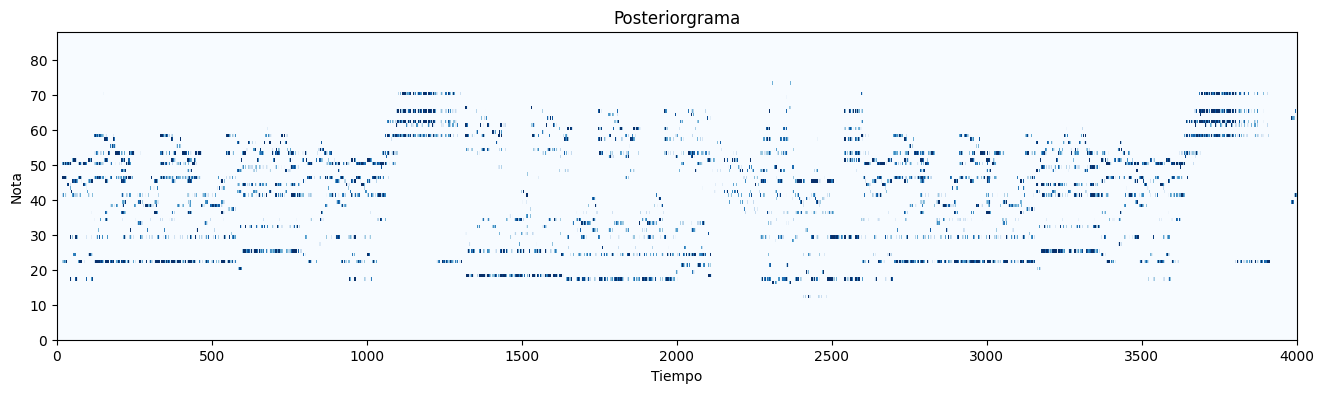

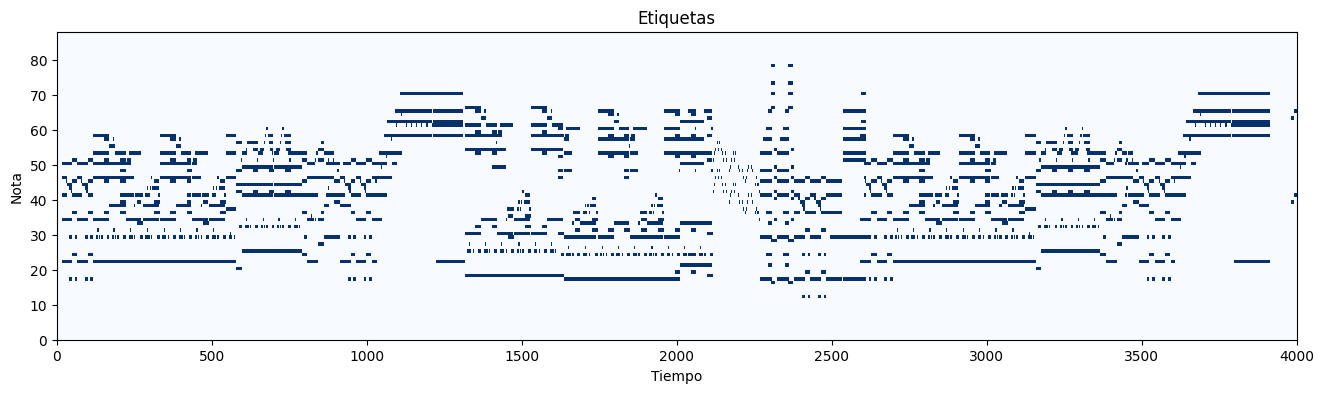

In [ ]:
# Calcular las predicciones en el conjunto de validación
frame_predictions = []
frame_labels=[]
model.eval()
with torch.no_grad():
    for f, l in val_dataset:
        frame_predictions.append(model(torch.unsqueeze(f, axis=0)))
        frame_labels.append(l)
frame_predictions=np.squeeze(frame_predictions)
frame_labels=np.array(frame_labels)
visualize_piano_roll(frame_predictions.T[:, :4000], title="Posteriorgrama")
visualize_piano_roll(frame_labels.T[:, :4000], title="Etiquetas")

### Métricas generales a nivel de nota

In [ ]:
# Dividir el pianoroll total para evitar desbordar memoria en el matching de notas
# Obtener eventos de nota de las predicciones
predicted_note_events=[pianoroll_to_note_events(p) for p in np.array_split(frame_predictions.T, 20, axis=1)]
# Obtener eventos de nota de las etiquetas
label_note_events=[pianoroll_to_note_events(l) for l in np.array_split(frame_labels.T, 20, axis=1)]
# Métricas sobre el onset
f1, precision, recall = get_note_wise_metrics(predicted_note_events, label_note_events, offset_ratio=None)
print("Onset F1:", f1)
print("Onset Precision:", precision)
print("Onset Recall:", recall)

# Métricas sobre onset y offset
f1, precision, recall = get_note_wise_metrics(predicted_note_events, label_note_events)
print("Note-wise F1:", f1)
print("Note-wise Precision:", precision)
print("Note-wise Recall:", recall)

Onset F1: 0.2514189816895921
Onset Precision: 0.194059955588453
Onset Recall: 0.3569131285629201
Note-wise F1: 0.08271149869639487
Note-wise Precision: 0.06384159881569208
Note-wise Recall: 0.11741682974559686


### Métricas a nivel de nota por tono

In [ ]:
# Juntar pianorolls de todas las secciones

pitch_f1s, pitch_precisions, pitch_recalls=get_onset_metrics_per_pitch(frame_predictions.T, frame_labels.T)

print("Onset F1:", np.mean(pitch_f1s))
print("Onset Precision:", np.mean(pitch_precisions))
print("Onset Recall:", np.mean(pitch_recalls))

Onset F1: 0.20395605515974613
Onset Precision: 0.1730223112367995
Onset Recall: 0.27111650382297736


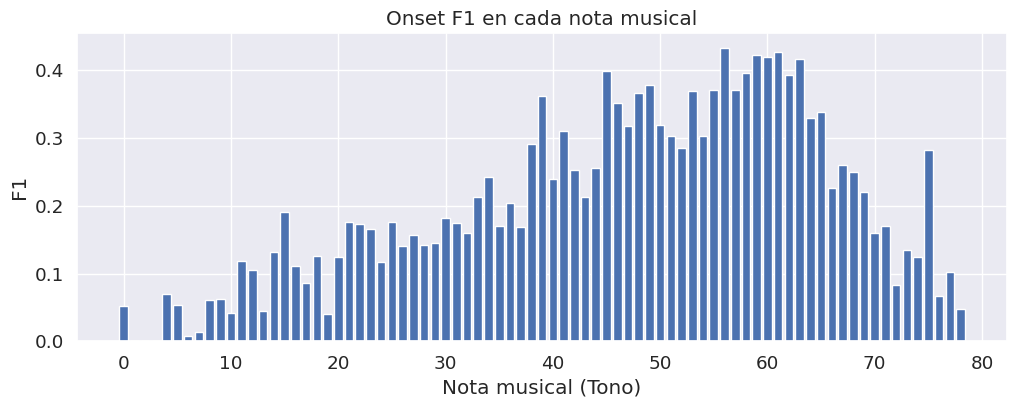

In [ ]:
show_pitch_f1s()

La longitud media de las notas predichas es: 0.17707179866765363
La longitud media de las notas en las etiquetas es: 0.6935126691057603
El número de notas que predice nuestro modelo es: 108080
El número de notas en nuestras etiquetas es: 58765


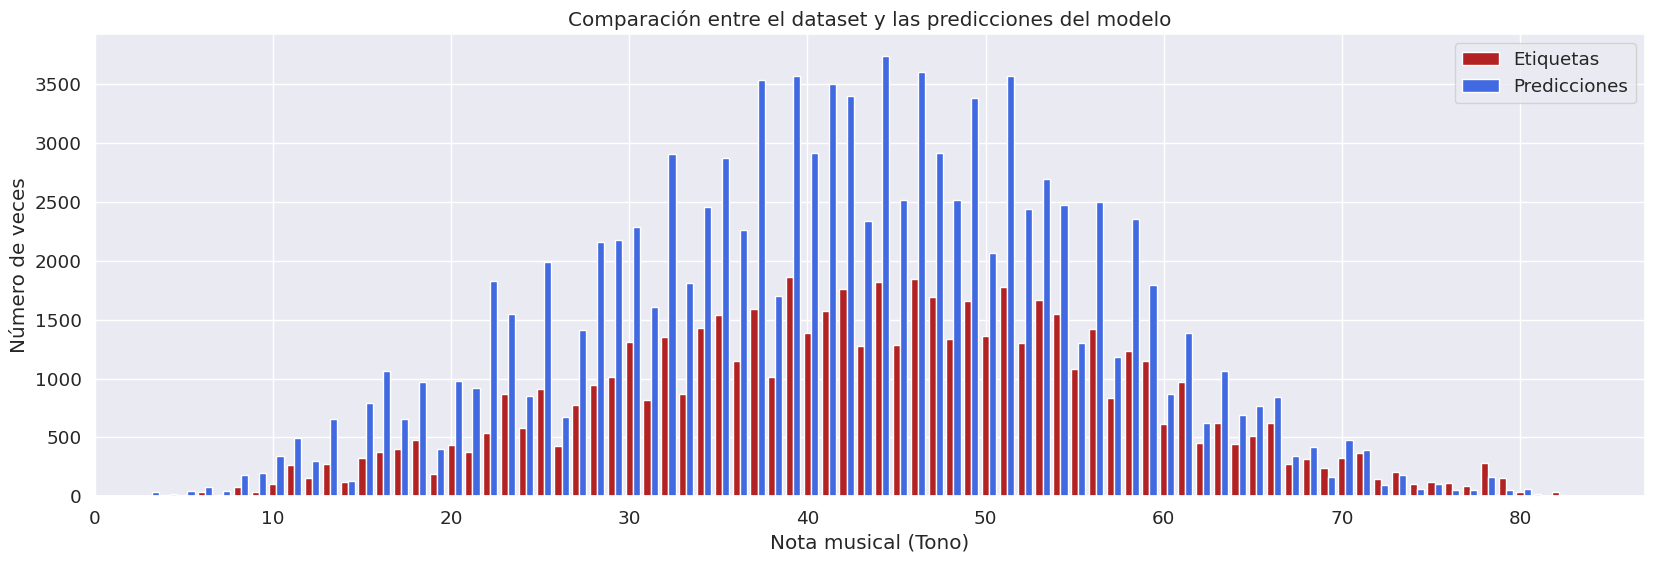

In [ ]:
# Obtener duraciones de notas predichas y de etiquetas
predicted_durations=[]
for section in predicted_note_events:
    for event in section:
        predicted_durations.append((event["end_time"] - event["start_time"]+1) * FRAME_DURATION)

label_durations=[]
for section in label_note_events:
    for event in section:
        label_durations.append((event["end_time"] - event["start_time"]+1) * FRAME_DURATION)

n_predicted_notes=count_pitch_from_note_events(predicted_note_events)
n_label_notes=count_pitch_from_note_events(label_note_events)

print("La longitud media de las notas predichas es:", np.mean(predicted_durations))
print("La longitud media de las notas en las etiquetas es:", np.mean(label_durations))

print("El número de notas que predice nuestro modelo es:", sum(n_predicted_notes))
print("El número de notas en nuestras etiquetas es:", sum(n_label_notes))

show_n_notes(n_predicted_notes, n_label_notes)

# Modelo CNN

### Cargar el dataset

In [ ]:
# Rutas al dataset
data_paths = ['/content/AkPnBcht/MUS','/content/AkPnBsdf','/content/AkPnCGdD',
              '/content/AkPnStgb','/content/SptkBGAm','/content/SptkBGCl', '/content/StbgTGd2']
train_dataset, val_dataset=create_datasets(data_paths, SpecDataset, log_transform=True)

# Crear un DataLoader para el dataset
BATCH_SIZE = 64
num_workers = 0  # Número de procesos para cargar los datos

# Crear los DataLoaders para entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

print("Núemero de ejemplos en validación:", len(val_dataset))
print("Núemero de ejemplos en train:", len(train_dataset))

Núemero de ejemplos en validación: 4528
Núemero de ejemplos en train: 20302


### Calcular proporción de notas-onsets

In [ ]:
n_positive_notes=0
n_positive_onsets=0
for notes in train_dataset.labels:
    n_positive_notes+=np.sum(notes==1)
    onsets=notes_to_onsets(torch.tensor(notes))
    n_positive_onsets+=torch.sum(onsets==1)
proportion=n_positive_notes/(n_positive_notes+n_positive_onsets)
print("La proporcion de valores positivos de notas  es:", proportion.float())


La proporcion de valores positivos de notas  es: tensor(0.9536)


### Arquitectura

In [ ]:
class HarmonicStacking(nn.Module):
    def __init__(self, harmonics):
        super(HarmonicStacking, self).__init__()
        self.harmonics=harmonics
        self.shifts=[int(np.round(N_BINS_PER_OCTAVE*np.log2(h))) for h in harmonics]

    def forward(self, x):
        #x = x.to(self.fc1.weight.dtype)  # Convertir x al mismo tipo de datos que self.fc1.weight
        n_batch, n_bins, n_frames= x.shape
        shifted=torch.zeros((n_batch, len(self.harmonics), n_bins, n_frames)).to(device)
        for i, s in enumerate(self.shifts):
          if s==0:
            shifted[:, i]=x
          elif s>0:
            shifted[:, i, :-s, :]=x[:, s:, :]
          elif s<0:
            shifted[:, i, -s:, :]=x[:, :s, :]
        return shifted
# Definir la arquitectura de la red neuronal
class CNN_Note(nn.Module):
    def __init__(self, in_channels):
        super(CNN_Note, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=5, padding=(2, 2), stride=(3, 1))
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=(3, 39), padding=(1, 19))

    def forward(self, x):
        x = x.to(self.conv1.weight.dtype)  # Convertir x al mismo tipo de datos que self.fc1.weight
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        return x

# Definir la arquitectura de la red neuronal
class CNN_Onset(nn.Module):
    def __init__(self, in_channels):
        super(CNN_Onset, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=5, stride=(3, 1), padding=(2, 2))
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=33, out_channels=1, kernel_size=(3, 3), padding=(1, 1))
        # Inicialización de pesos Xavier

    def forward(self, x, n):
        x = x.to(self.conv1.weight.dtype)  # Convertir x al mismo tipo de datos que self.fc1.weight
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = torch.cat((x, n), 1)
        x = self.conv2(x)
        return x
class CNN_Model(nn.Module):
  def __init__(self, harmonics):
    super(CNN_Model, self).__init__()
    self.h_stack=HarmonicStacking(harmonics)
    self.onset=CNN_Onset(len(harmonics))
    self.note=CNN_Note(len(harmonics))
  def forward(self, x):
    x = self.h_stack(x)
    n = self.note(x)
    x = self.onset(x, torch.sigmoid(n))
    return n, x

In [ ]:
print("Número de batches:", len(train_loader))

Número de batches: 1218


## Entrenamiento

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/100], Train Loss: 0.05705656709766996, Train Note Loss: 0.0215780549280864, Train Onset Loss: 0.03547851216958363, Validation Loss: 0.028821231479269044
Epoch [2/100], Train Loss: 0.024431099880323694, Train Note Loss: 0.014674102417578327, Train Onset Loss: 0.009756997462745361, Validation Loss: 0.021863691517837378
Epoch [3/100], Train Loss: 0.02034696084302018, Train Note Loss: 0.013472745835473188, Train Onset Loss: 0.006874215007547014, Validation Loss: 0.019435302966919775
Epoch [4/100], Train Loss: 0.018653393178720012, Train Note Loss: 0.012785172325678697, Train Onset Loss: 0.0058682208530413185, Validation Loss: 0.01828486410057242
Epoch [5/100], Train Loss: 0.017764168246248966, Train Note Loss: 0.012366224920105666, Train Onset Loss: 0.005397943326143302, Validation Loss: 0.017543607459349218
Epoch [6/100], Train Loss: 0.017225011443006498, Train Note Loss: 0.012082775411881777, Train Onset Loss: 0.0051422360311247335, Validation Loss: 0.017108137844415484
Epoch [7

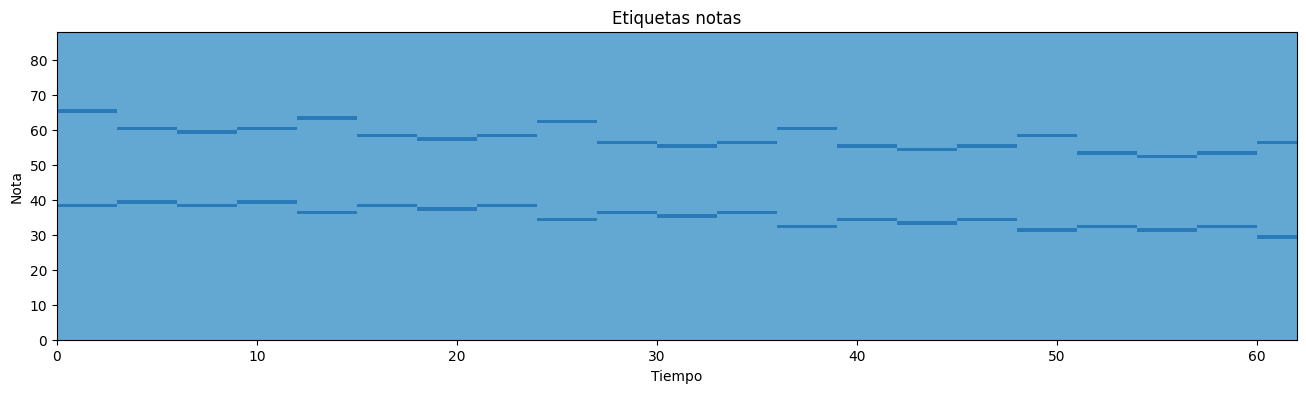

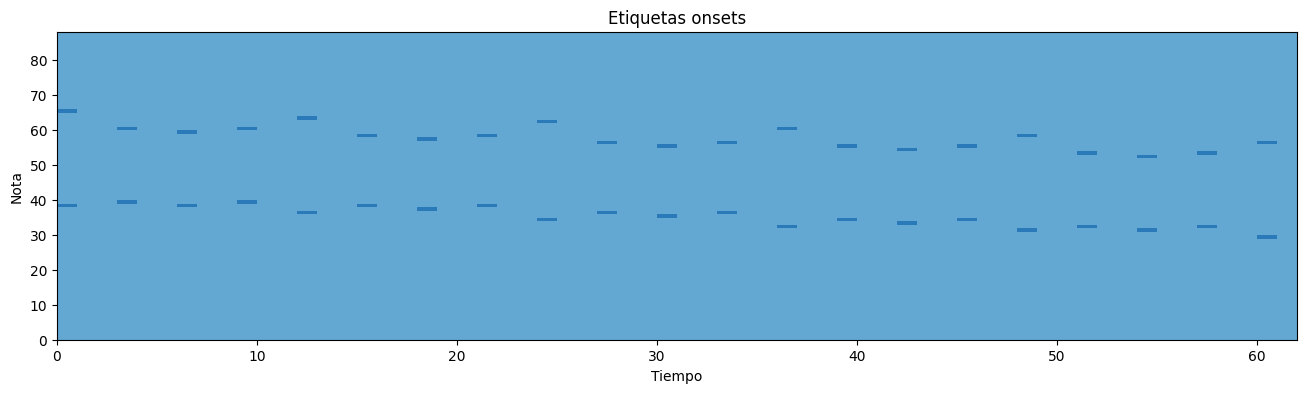

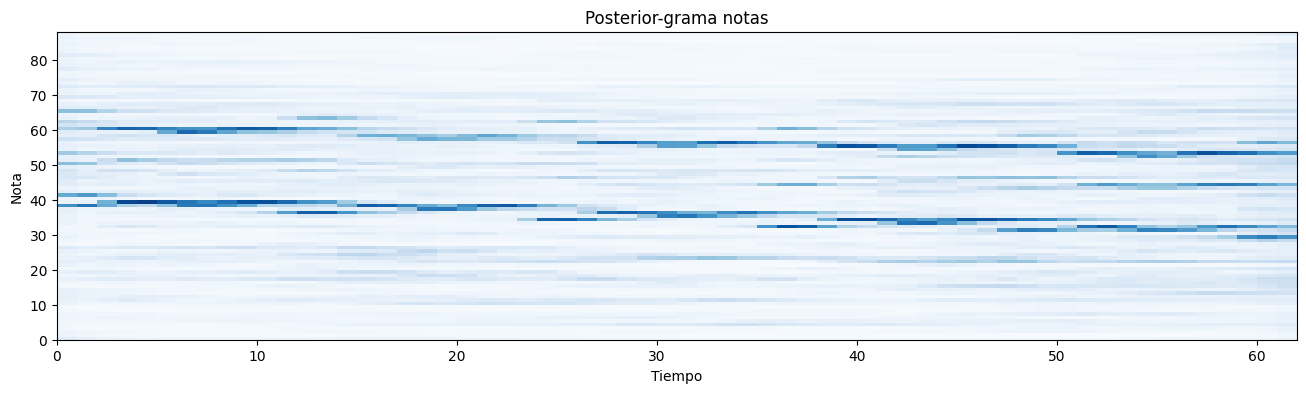

TypeError: sigmoid(): argument 'input' (position 1) must be Tensor, not int

In [ ]:
# Hiperparámetros
onset_pos_weight=0.95
learning_rate = 0.0001
epochs = 100
harmonics=[0.5, 1, 2, 3, 4, 5, 6, 7]
label_smoothing=True

pos_weight=torch.tensor([onset_pos_weight]).to(device)

# Define la función de pérdida con pesos de clase
criterion = FocalLoss()

# Objeto para llevar a cabo early stopping
early_stopper = EarlyStopper(patience=5, min_delta=0)

# Crear la red y moverla a la GPU si está disponible
model = CNN_Model(harmonics).to(device)

# Definir optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Directorio en Google Drive donde se guardará el modelo
save_path = '/content/drive/My Drive/TFG/bp_all_7_no_logits.pth'

# Lista para almacenar la pérdida de entrenamiento y validación de cada época
train_losses = []
val_losses = []

# Entrenar la red
for epoch in range(epochs):
    # Entrenamiento
    model.train()
    train_loss = 0.0
    epoch_note_loss = 0.0
    epoch_onset_loss = 0.0
    for i, (cqt, target_notes, target_onsets) in enumerate(train_loader):
        # Obtener espectrograma pasar como input al modelo
        cqt, target_notes, target_onsets = cqt.to(device), target_notes.to(device), target_onsets.to(device)
        # Aplicar label_smoothing si procede
        if (label_smoothing):
            target_notes[target_notes==1]=0.9
            target_notes[target_notes==0]=0.1
            target_onsets[target_onsets==1]=0.9
            target_onsets[target_onsets==0]=0.1

        output_notes, output_onsets = model(cqt)
        # Obtener funciones de pérdida
        note_loss = criterion(torch.squeeze(output_notes), torch.squeeze(target_notes))
        onset_loss = criterion(torch.squeeze(output_onsets), torch.squeeze(target_onsets))
        total_loss = note_loss+onset_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()
        epoch_note_loss+=note_loss.item()
        epoch_onset_loss+=onset_loss.item()

    train_loss /= len(train_loader)
    epoch_note_loss /= len(train_loader)
    epoch_onset_loss /= len(train_loader)

    train_losses.append(train_loss)
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for cqt, target_notes, target_onsets in val_loader:
            # Obtener espectrograma pasar como input al modelo
            cqt, target_notes, target_onsets = cqt.to(device), target_notes.to(device), target_onsets.to(device)
            # Aplicar label_smoothing si procede
            if (label_smoothing):
                target_notes[target_notes==1]=0.9
                target_notes[target_notes==0]=0.1
                target_onsets[target_onsets==1]=0.9
                target_onsets[target_onsets==0]=0.1
            output_notes, output_onsets = model(cqt)
            # Obtener funciones de pérdida
            note_loss = criterion(torch.squeeze(output_notes), torch.squeeze(target_notes))
            onset_loss = criterion(torch.squeeze(output_onsets), torch.squeeze(target_onsets))
            total_loss = note_loss + onset_loss
            val_loss += total_loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss}, Train Note Loss: {epoch_note_loss}, Train Onset Loss: {epoch_onset_loss}, Validation Loss: {val_loss}')
    if early_stopper.early_stop(val_loss):
        print("Entrenamiento finalizado con Early Stopping")
        break
    # Guardar el modelo entrenado en Google Drive
    torch.save(model.state_dict(), save_path)
visualize_piano_roll(target_notes[0].cpu().numpy(), title="Etiquetas notas")
visualize_piano_roll(target_onsets[0].cpu().numpy(), title="Etiquetas onsets")
visualize_piano_roll(torch.sigmoid(output_notes[0][0]).cpu().numpy(), title="Posterior-grama notas")
visualize_piano_roll(torch.sigmoid(output_onsets[0][0]).cpu().numpy(), title="Posterior-grama onsets")

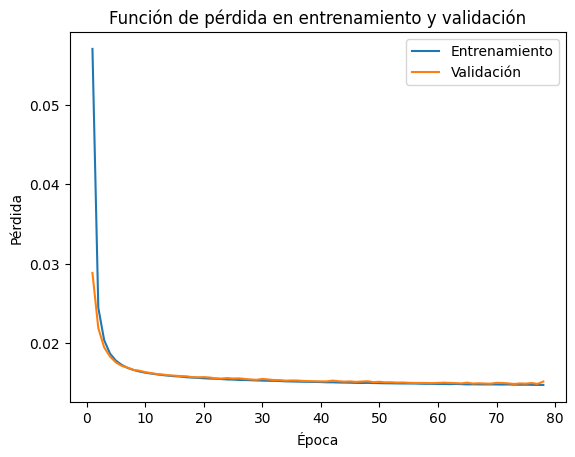

In [ ]:
plot_lr_curves(train_losses, val_losses)

## Validación

### Cargar modelo pre-entrenado de Drive

In [ ]:
harmonics=[0.5, 1, 2, 3, 4, 5, 6, 7]
# Crear la red y moverla a la GPU si está disponible
model = CNN_Model(harmonics).to(device)

# Ruta con los pesos del modelo
model_path = '/content/drive/MyDrive/TFG/bp_all_7_no_logits.pth'
# Carga los pesos al modelo
model.load_state_dict(torch.load(model_path, map_location=device))
n_params=sum(p.numel() for p in model.parameters())
print("El número de parámetros del modelo es:", n_params)

El número de parámetros del modelo es: 11915


In [ ]:
# Obtener predicciones de un modelo (con post-procesado)
predicted_pianorolls, predicted_note_events=get_model_predictions(model, val_loader, onsets=True)

Batch 10 completado
Batch 20 completado
Batch 30 completado
Batch 40 completado
Batch 50 completado
Batch 60 completado
Batch 70 completado


### Métricas de error por frame

Accuracy: 0.2934108913712527
Precision: 0.8398182334564044
Recall: 0.7430686763696559
F1 Score: 0.7884866812046953


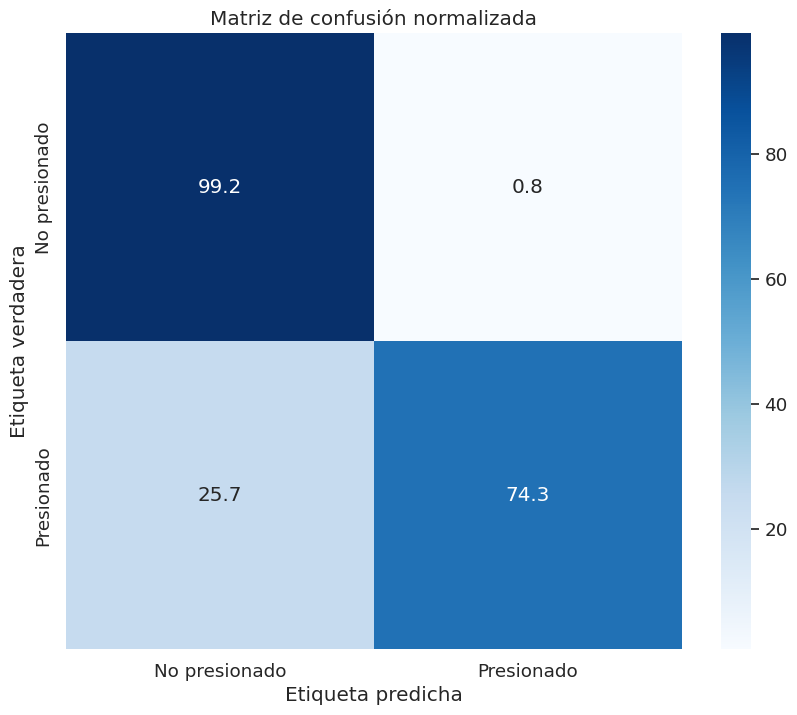

In [ ]:
# Concatenar predicciones y etiquetas de todas las secciones por frames
frame_labels = np.concatenate(val_dataset.labels, axis=1).T
frame_predictions=np.concatenate(predicted_pianorolls, axis=1).T

accuracy, precision, recall, f1=get_frame_metrics(frame_predictions, frame_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

show_confusion_matrix(frame_predictions, frame_labels)

### Ejemplo de salida de la red y de predicción

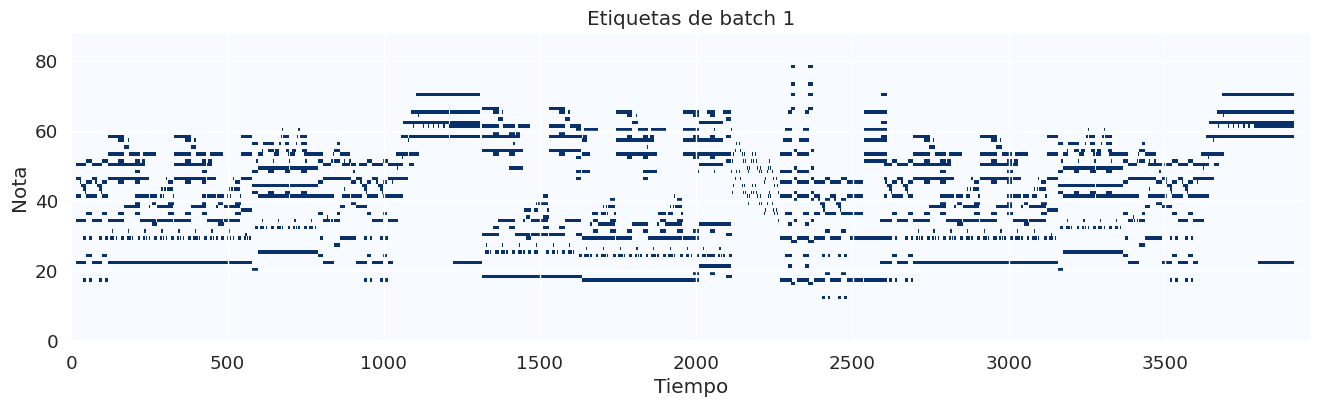

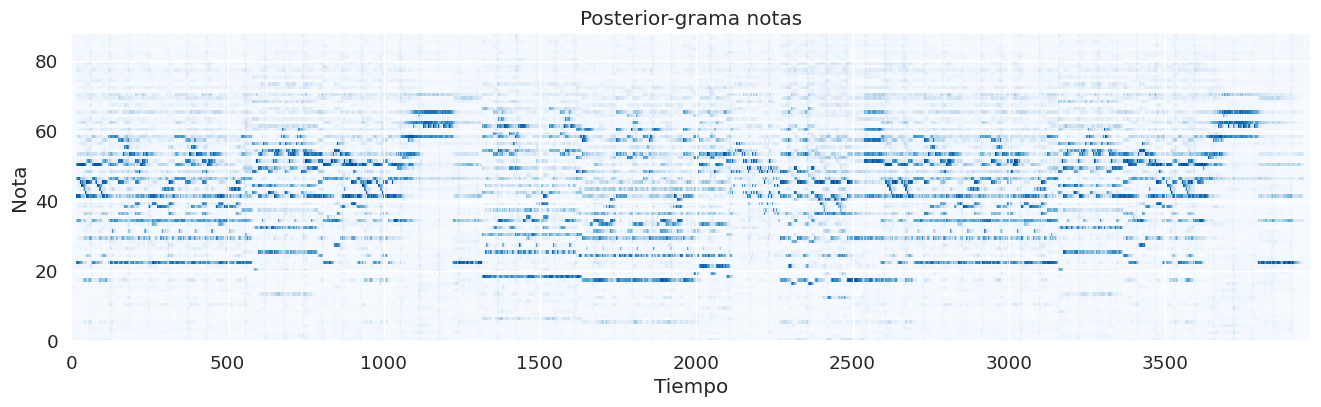

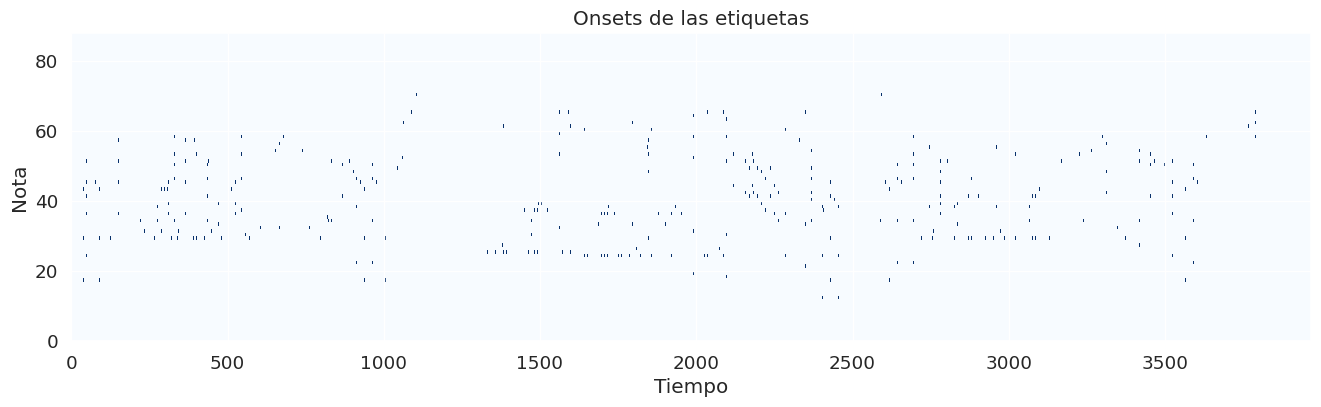

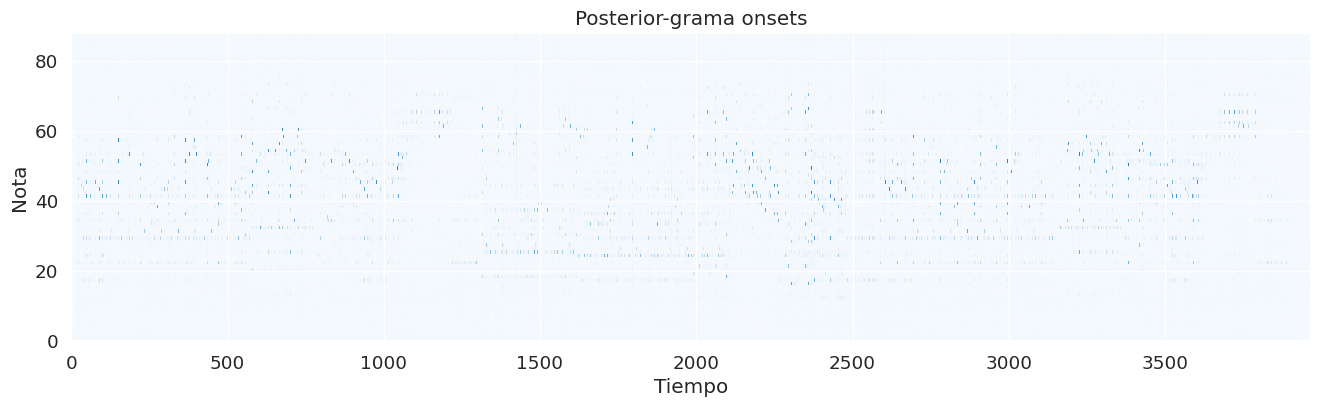

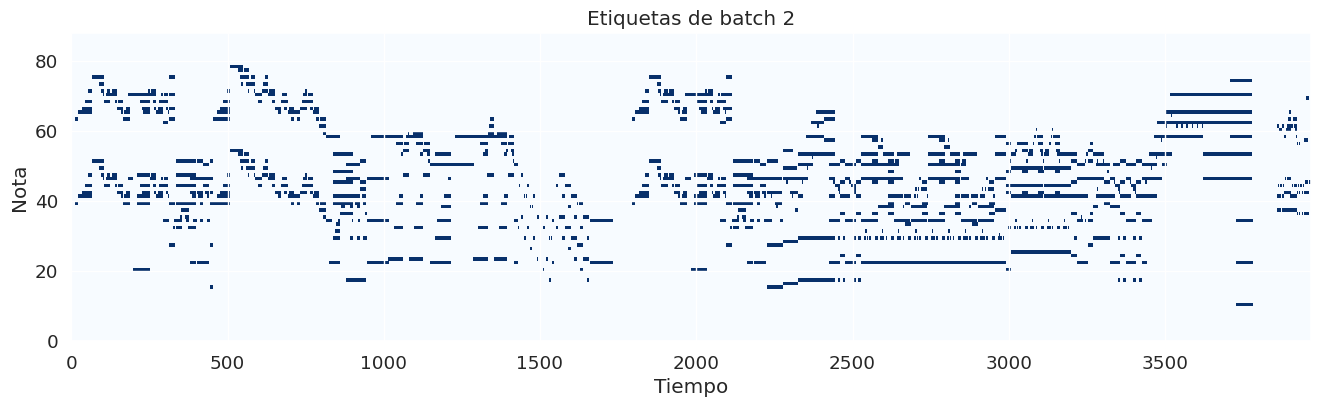

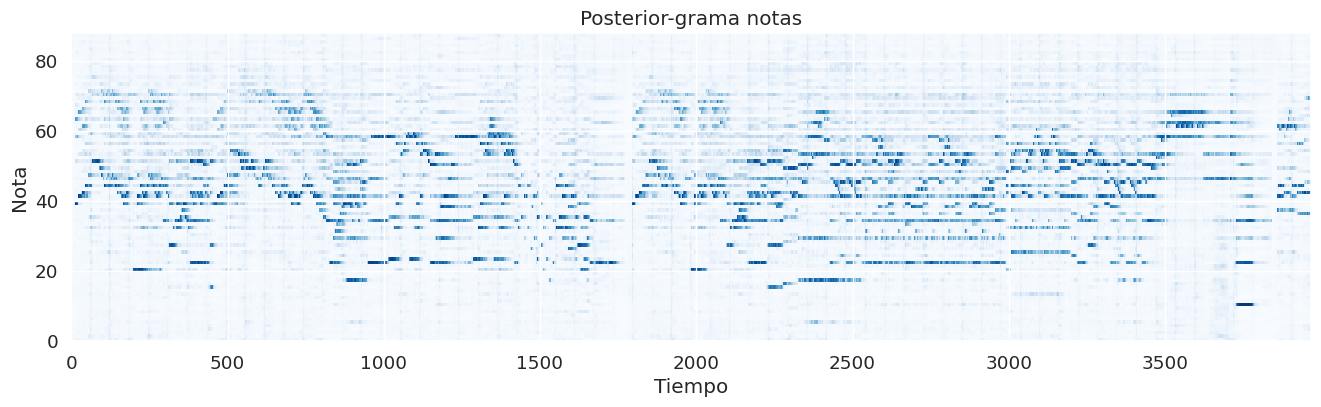

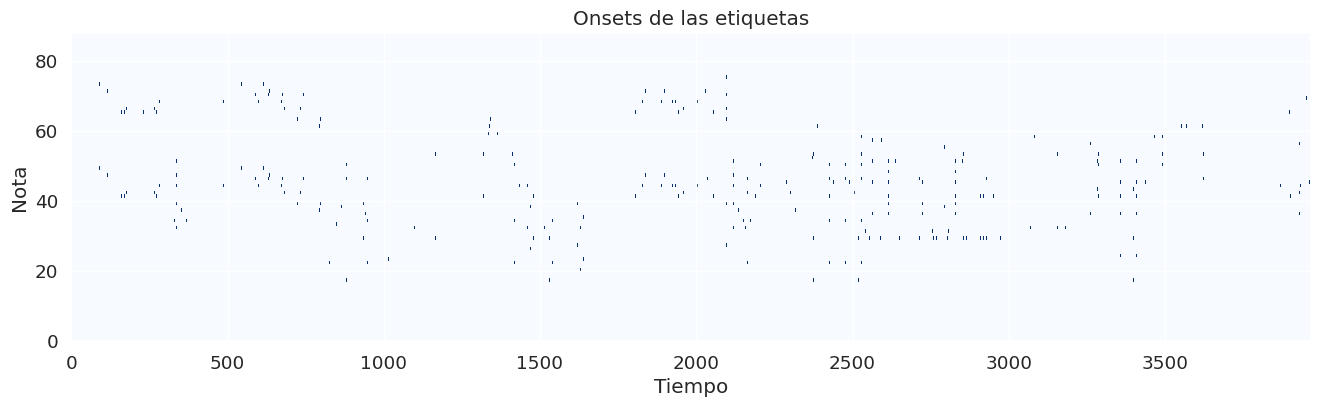

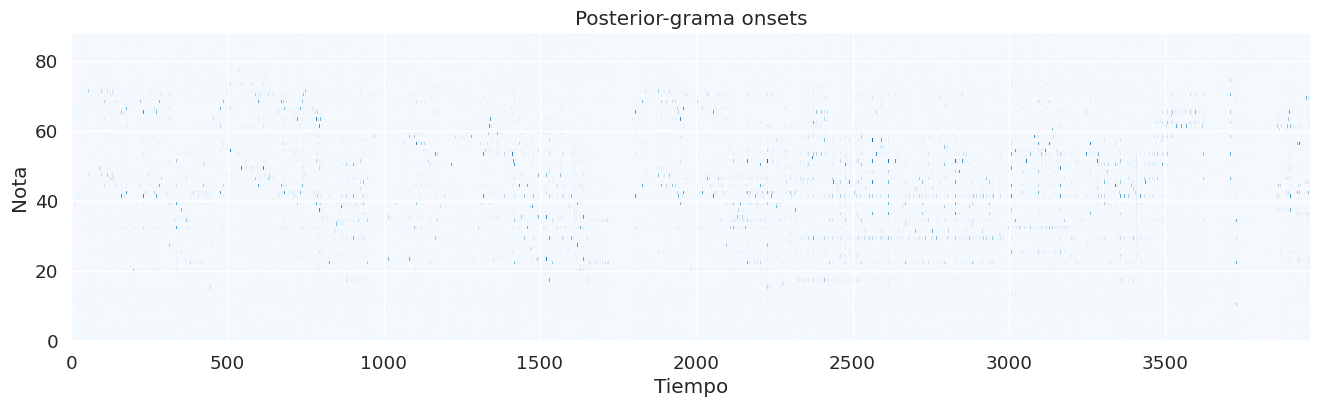

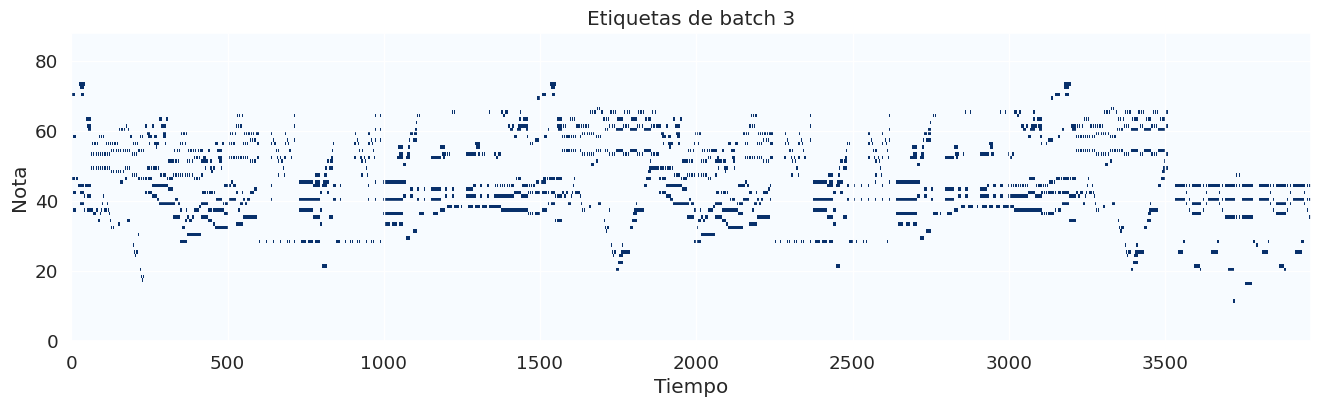

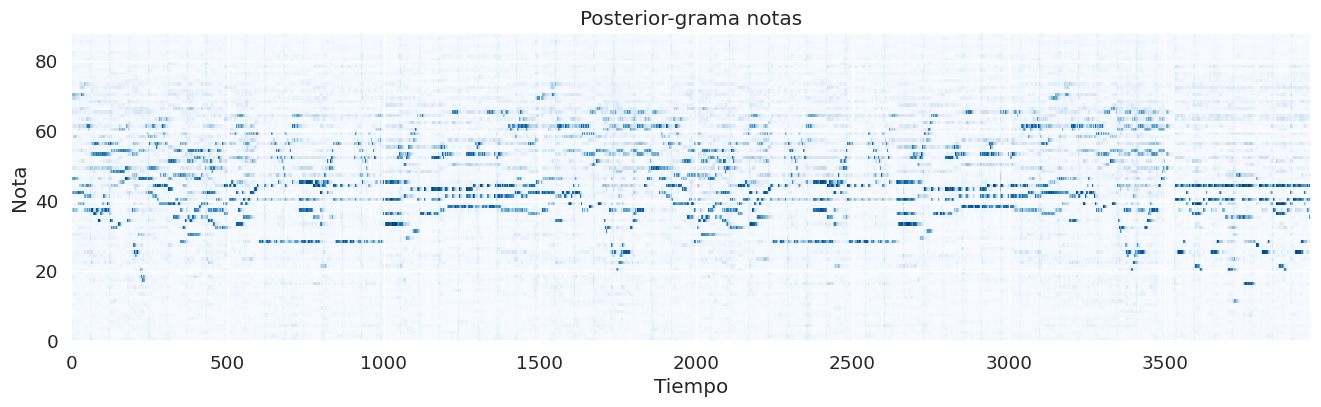

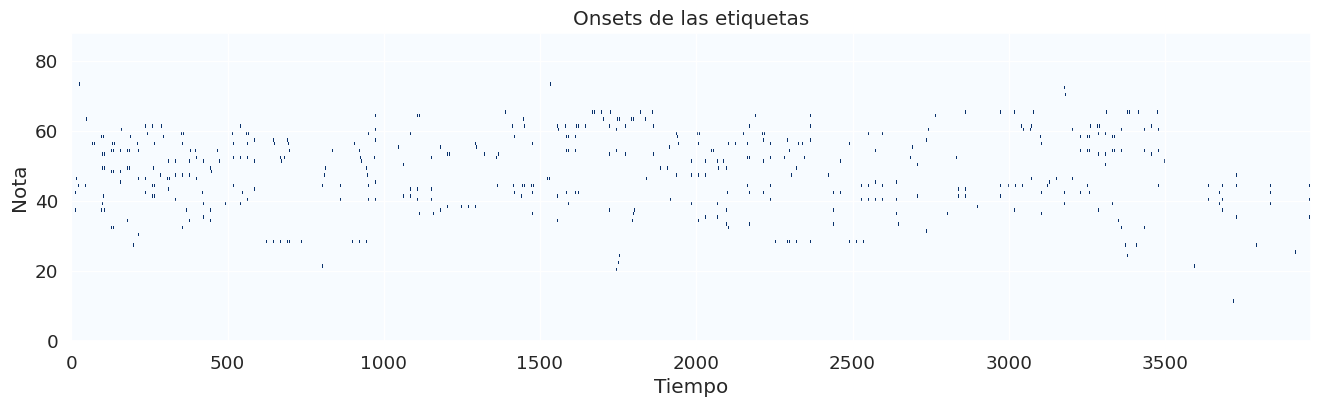

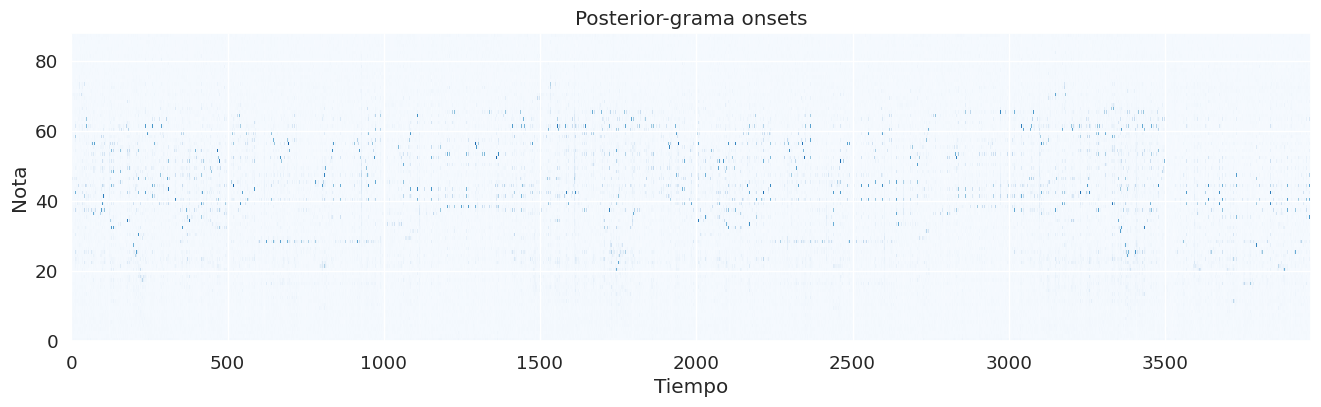

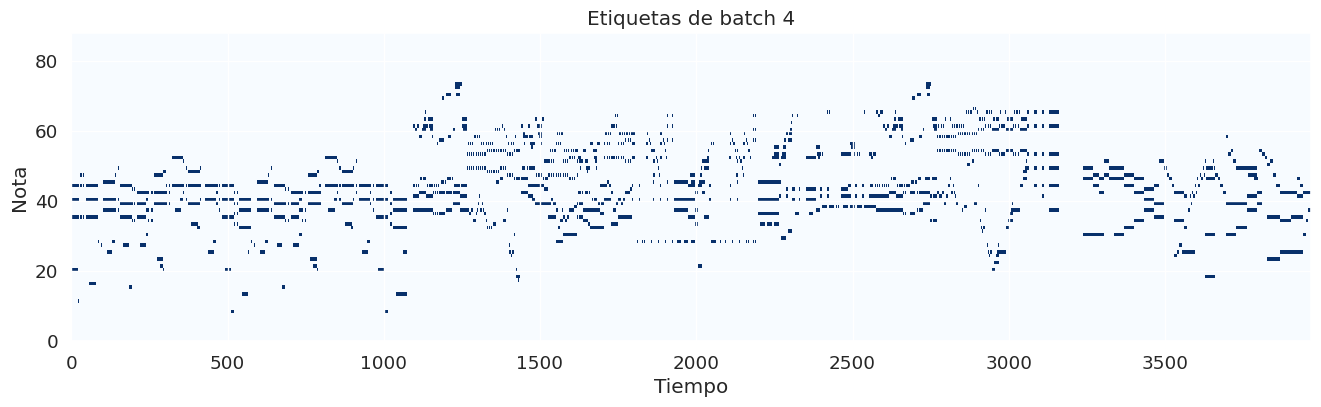

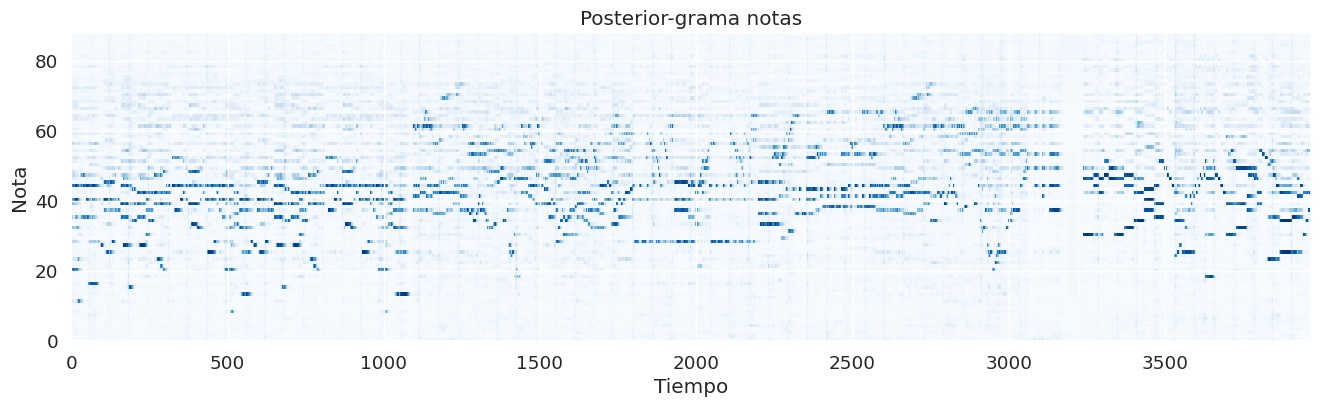

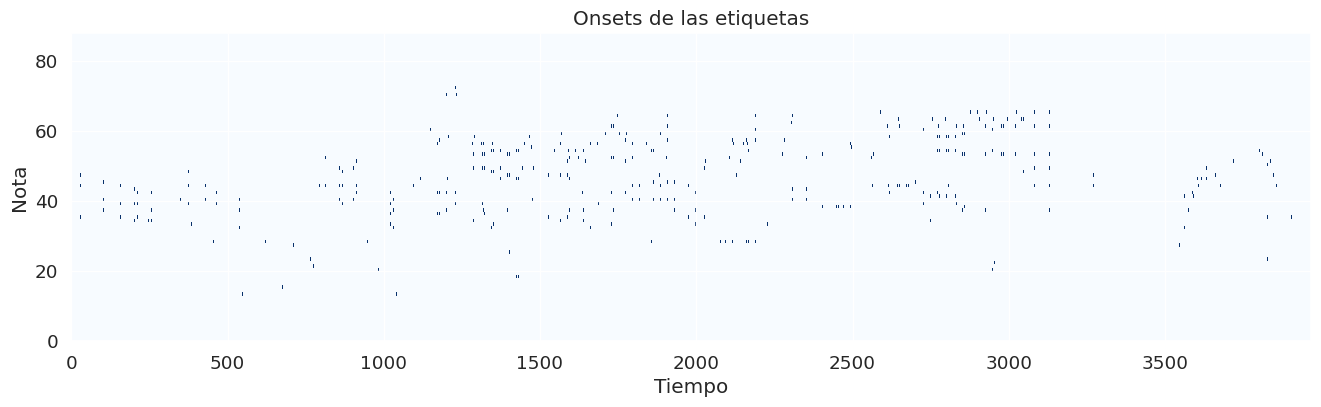

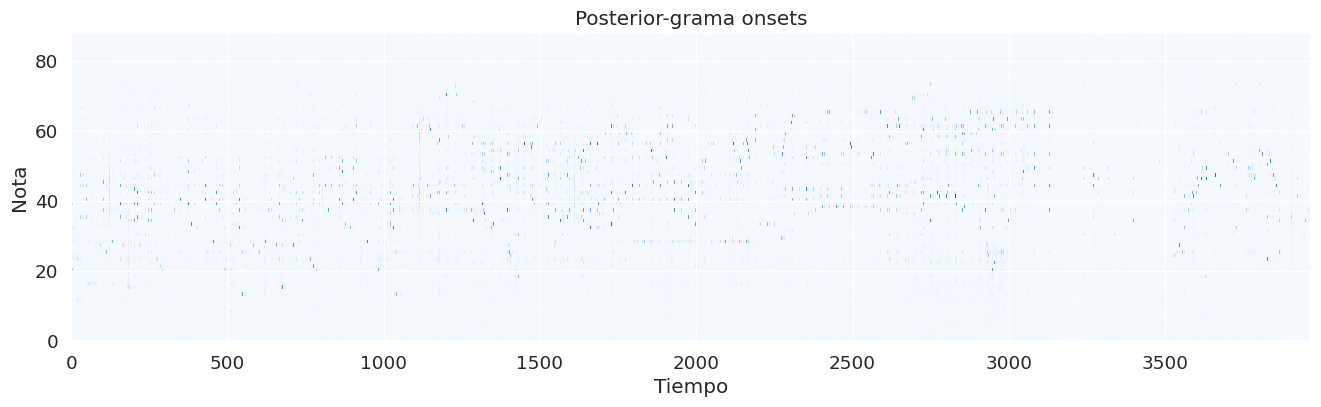

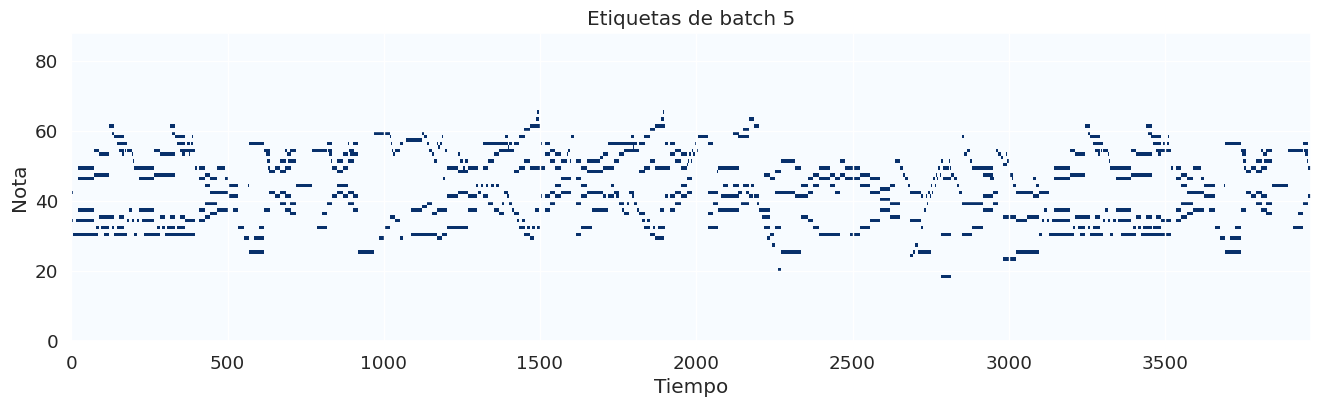

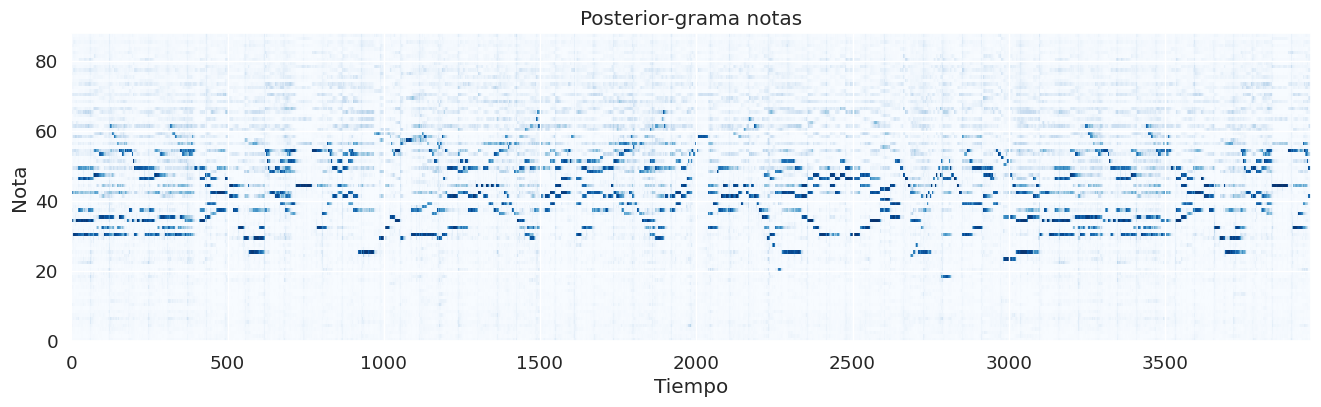

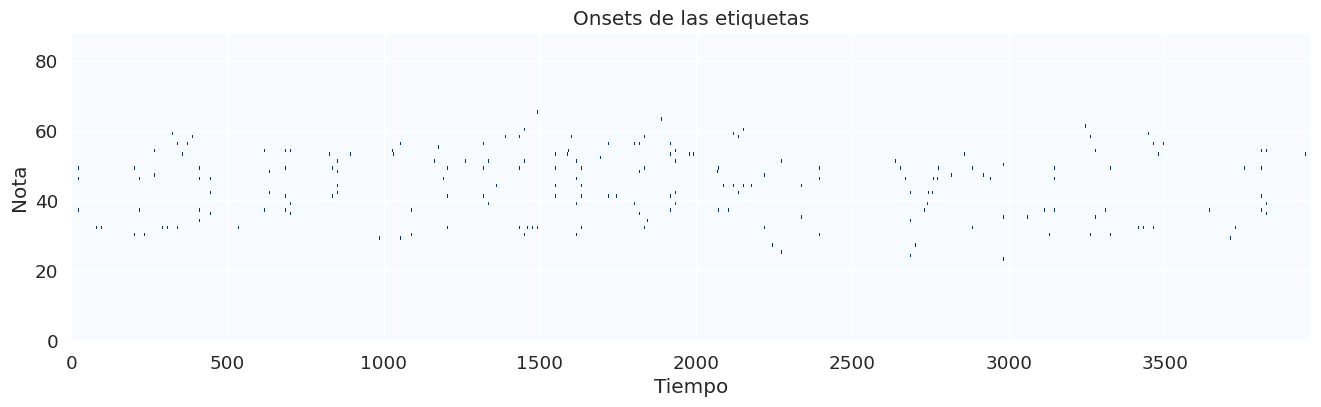

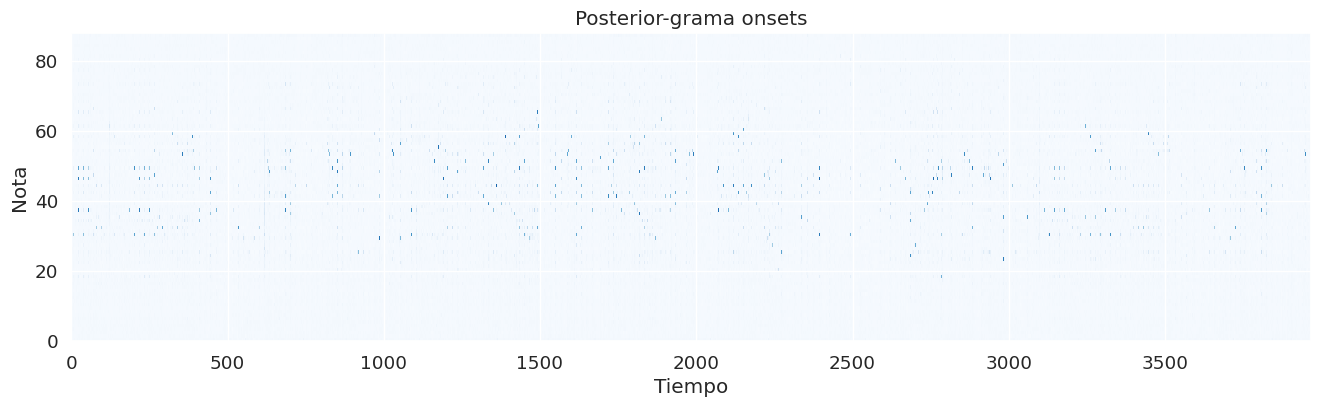

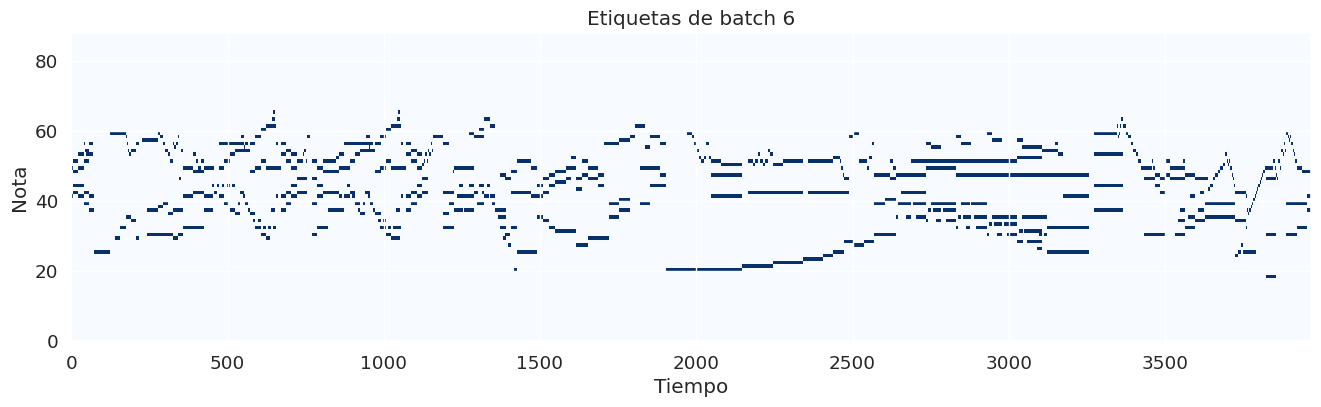

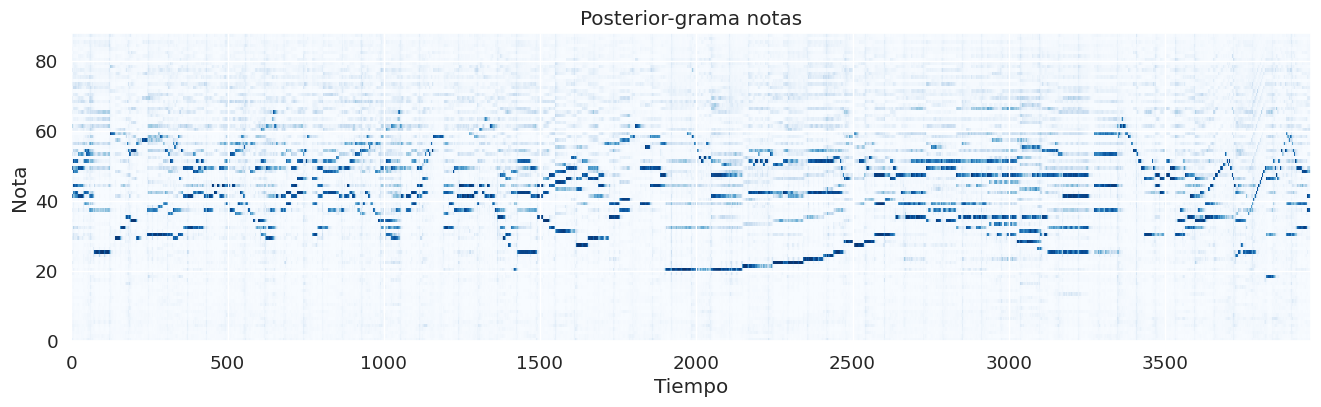

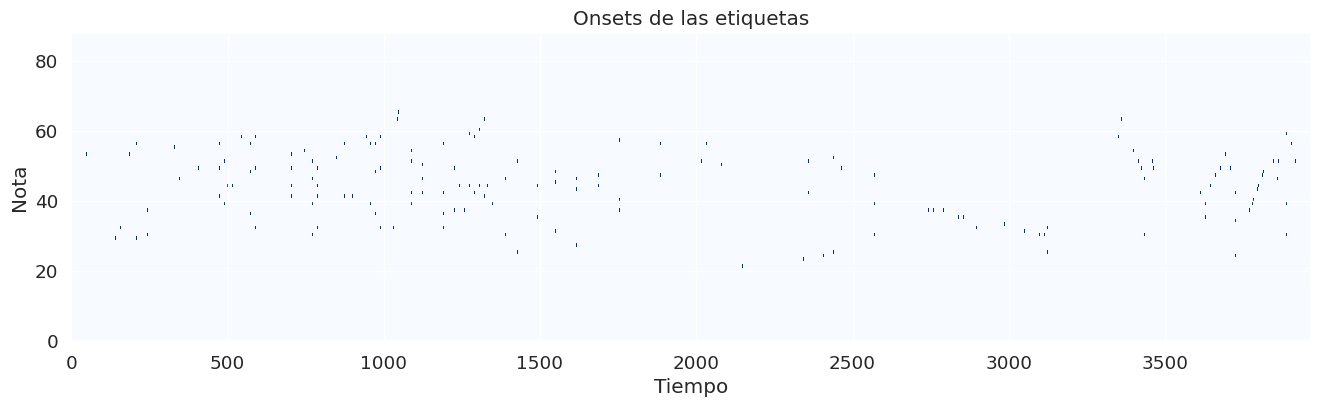

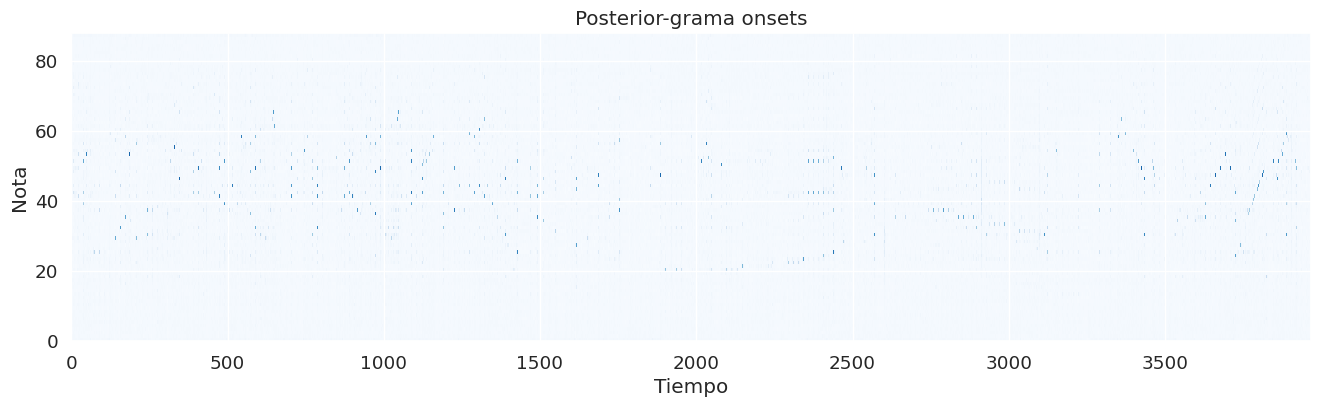

([], [])

In [ ]:
show_model_outputs(model, val_loader)

### Métricas generales a nivel de nota

In [ ]:
# Obtener eventos de nota de las etiquetas
label_note_events=[pianoroll_to_note_events(l) for l in val_dataset.labels]

# Métricas sobre el onset
f1, precision, recall = get_note_wise_metrics(predicted_note_events, label_note_events, offset_ratio=None)
print("Onset F1:", f1)
print("Onset Precision:", precision)
print("Onset Recall:", recall)

# Métricas sobre onset y offset
f1, precision, recall = get_note_wise_metrics(predicted_note_events, label_note_events)
print("Note-wise F1:", f1)
print("Note-wise Precision:", precision)
print("Note-wise Recall:", recall)

/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:167: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")
/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:165: UserWarning: Reference notes are empty.
  warnings.warn("Reference notes are empty.")


Onset F1: 0.7301438833149431
Onset Precision: 0.8385477860955386
Onset Recall: 0.6465594222780158
Note-wise F1: 0.47324384166258665
Note-wise Precision: 0.5435059921447514
Note-wise Recall: 0.4190684491840195


### Métricas a nivel de nota por tono

In [ ]:
# Juntar pianorolls de todas las secciones
total_predicted_pianoroll=np.concatenate(predicted_pianorolls, axis=1)
total_label_pianoroll=np.concatenate(val_dataset.labels, axis=1)

pitch_f1s, pitch_precisions, pitch_recalls=get_onset_metrics_per_pitch(total_predicted_pianoroll, total_label_pianoroll)

print("Onset F1:", np.mean(pitch_f1s))
print("Onset Precision:", np.mean(pitch_precisions))
print("Onset Recall:", np.mean(pitch_recalls))

Onset F1: 0.5477230363408102
Onset Precision: 0.6951499672084356
Onset Recall: 0.501741447143339


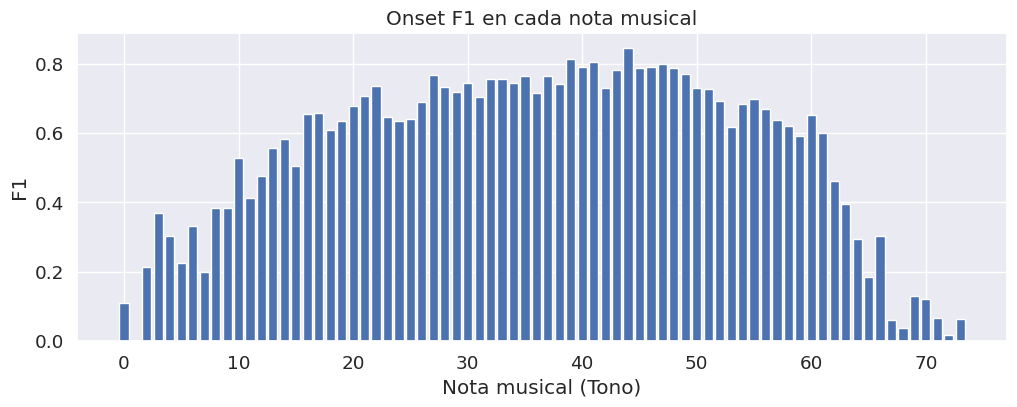

In [ ]:
show_pitch_f1s()

La longitud media de las notas predichas es: 0.6051737218436337
La longitud media de las notas en las etiquetas es: 0.5269859840298179
El número de notas que predice nuestro modelo es: 59578
El número de notas en nuestras etiquetas es: 77269


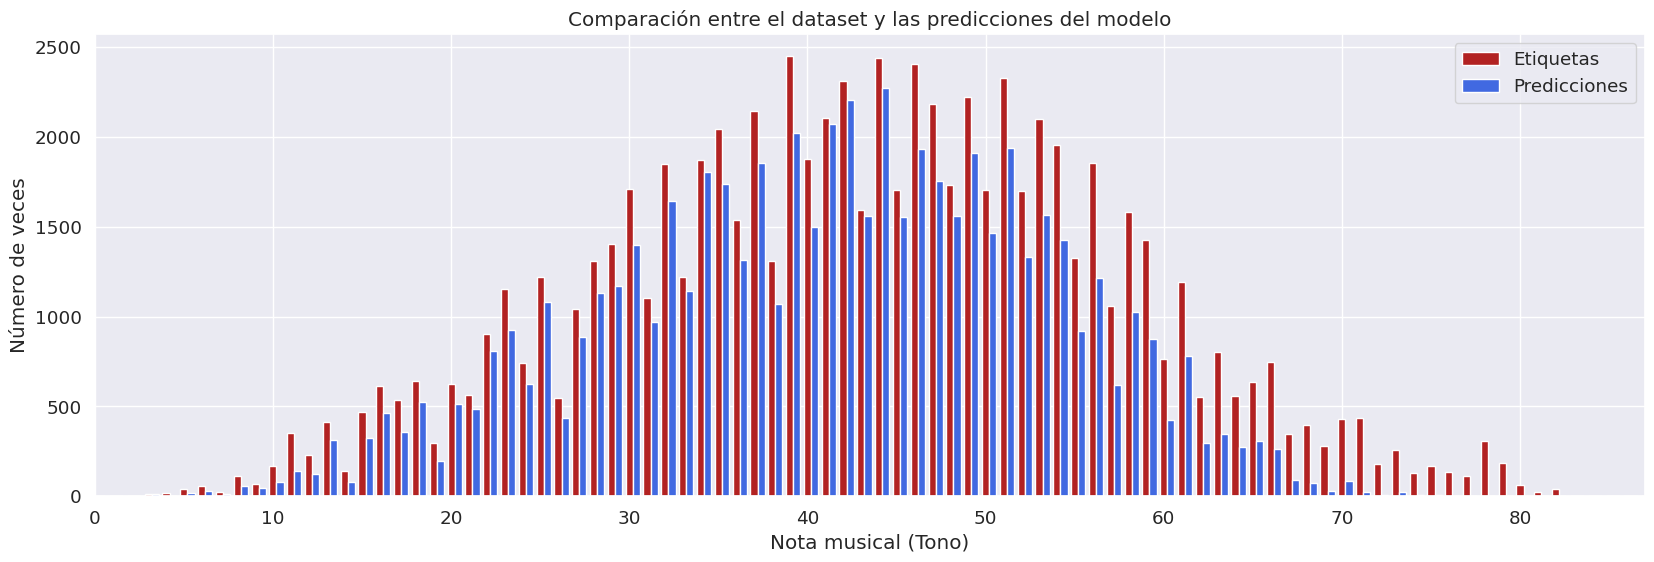

In [ ]:
# Obtener duraciones de notas predichas y de etiquetas
predicted_durations=[]
for pitch in predicted_note_events:
    for event in pitch:
        predicted_durations.append((event["end_time"] - event["start_time"]+1) * FRAME_DURATION)

label_durations=[]
for pitch in label_note_events:
    for event in pitch:
        label_durations.append((event["end_time"] - event["start_time"]+1) * FRAME_DURATION)

n_predicted_notes=count_pitch_from_note_events(predicted_note_events)
n_label_notes=count_pitch_from_note_events(label_note_events)

print("La longitud media de las notas predichas es:", np.mean(predicted_durations))
print("La longitud media de las notas en las etiquetas es:", np.mean(label_durations))

print("El número de notas que predice nuestro modelo es:", sum(n_predicted_notes))
print("El número de notas en nuestras etiquetas es:", sum(n_label_notes))

show_n_notes(n_predicted_notes, n_label_notes)

# Modelo Deep CNN

### Cargar el dataset

In [ ]:
# Rutas al dataset
data_paths = ['/content/AkPnBcht/MUS','/content/AkPnBsdf','/content/AkPnCGdD',
              '/content/AkPnStgb','/content/SptkBGAm','/content/SptkBGCl', '/content/StbgTGd2']
train_dataset, val_dataset=create_datasets(data_paths, SpecDataset, log_transform=True)

# Crear un DataLoader para el dataset
BATCH_SIZE = 64
num_workers = 0  # Número de procesos para cargar los datos

# Crear los DataLoaders para entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

print("Número de ejemplos en validación:", len(val_dataset))
print("Número de ejemplos en train:", len(train_dataset))

Número de ejemplos en validación: 4528
Número de ejemplos en train: 20302


### Distribución de los datos

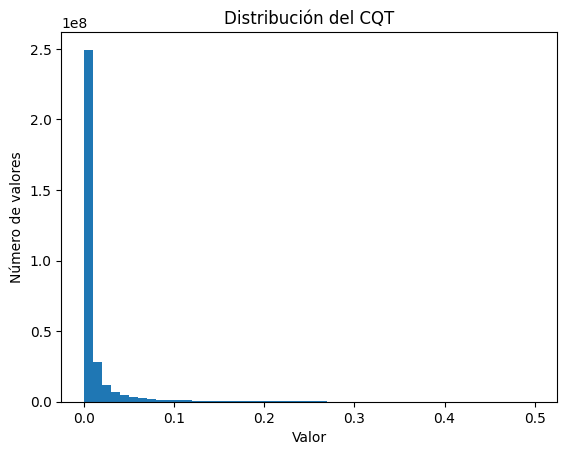

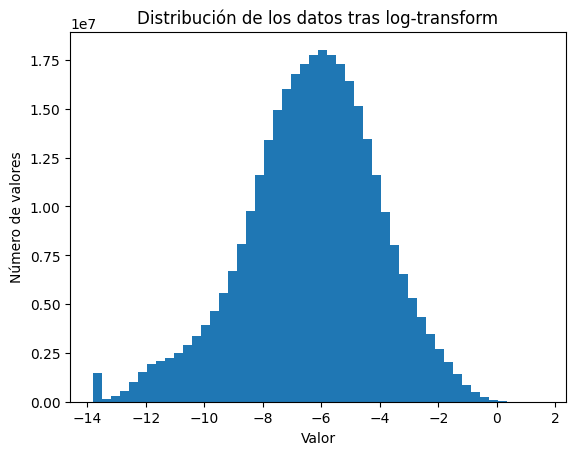

In [ ]:
data=np.concatenate([e.flatten() for e in train_dataset.features])
log_data=np.log(10e-7+data)
plt.hist(data, bins=50, range=(0, 0.5))
plt.title("Distribución del CQT")
plt.xlabel("Valor")
plt.ylabel("Número de valores")
plt.show()
plt.hist(log_data, bins=50)
plt.title("Distribución de los datos tras log-transform")
plt.xlabel("Valor")
plt.ylabel("Número de valores")
plt.show()

In [ ]:
print("Media de los datos", np.mean(data))
print("Std de los datos", np.std(data))

print("Media de los datos tras log-transform", np.mean(log_data))
print("Std de los datos tras log-transform", np.std(log_data))

Media de los datos 0.014271652
Std de los datos 0.047825333
Media de los datos tras log-transform -6.3362346
Std de los datos tras log-transform 2.29297


### Arquitectura

In [ ]:
class HarmonicStacking(nn.Module):
    def __init__(self, harmonics):
        super(HarmonicStacking, self).__init__()
        self.harmonics=harmonics
        self.shifts=[int(np.round(N_BINS_PER_OCTAVE*np.log2(h))) for h in harmonics]

    def forward(self, x):
        #x = x.to(self.fc1.weight.dtype)  # Convertir x al mismo tipo de datos que self.fc1.weight
        n_batch, n_bins, n_frames= x.shape
        shifted=torch.zeros((n_batch, len(self.harmonics), n_bins, n_frames)).to(device)
        for i, s in enumerate(self.shifts):
          if s==0:
            shifted[:, i]=x
          elif s>0:
            shifted[:, i, :-s, :]=x[:, s:, :]
          elif s<0:
            shifted[:, i, -s:, :]=x[:, :s, :]
        return shifted
# Definir la arquitectura de la red neuronal
class CNN_Note(nn.Module):
    def __init__(self, in_channels):
        super(CNN_Note, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=5, padding=(2, 2), stride=(3, 1))
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 39), padding=(1, 19))
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(8)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, padding=(1, 1))

    def forward(self, x):
        x = x.to(self.conv1.weight.dtype)  # Convertir x al mismo tipo de datos que self.fc1.weight
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        return x

# Definir la arquitectura de la red neuronal
class CNN_Onset(nn.Module):
    def __init__(self, in_channels):
        super(CNN_Onset, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=5, stride=(3, 1), padding=(2, 2))
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=65, out_channels=32, kernel_size=(3, 3), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x, n):
        x = x.to(self.conv1.weight.dtype)  # Convertir x al mismo tipo de datos que self.fc1.weight
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = torch.cat((x, n), 1)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        return x
class CNN_Model(nn.Module):
  def __init__(self, harmonics):
    super(CNN_Model, self).__init__()
    self.h_stack=HarmonicStacking(harmonics)
    self.onset=CNN_Onset(len(harmonics))
    self.note=CNN_Note(len(harmonics))
  def forward(self, x):
    x = self.h_stack(x)
    n = self.note(x)
    x = self.onset(x, torch.sigmoid(n))
    return n, x


In [ ]:
n_positive_notes=0
n_positive_onsets=0
for notes in train_dataset.labels:
    notes=notes>0.5
    n_positive_notes+=np.sum(notes==1)
    onsets=notes_to_onsets(torch.tensor(notes))
    n_positive_onsets+=torch.sum(onsets==1)

onset_proportion=n_positive_onsets/(N_OUTPUT_NOTES*N_FRAMES_PER_SECTION*len(train_dataset.labels))
note_proportion=n_positive_notes/(N_OUTPUT_NOTES*N_FRAMES_PER_SECTION*len(train_dataset.labels))
print("La proporcion de valores positivos de notas es:", note_proportion)
print("La proporcion de valores positivos de onsets es:", onset_proportion.float())

La proporcion de valores positivos de notas es: 0.05033088926546365
La proporcion de valores positivos de onsets es: tensor(0.0026)


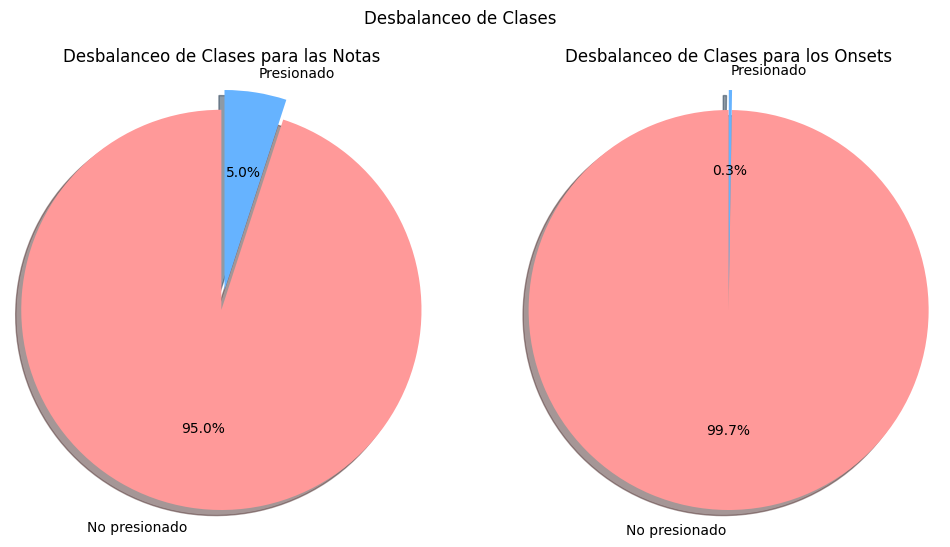

In [ ]:
import matplotlib.pyplot as plt

# Datos para los dos gráficos de pastel
labels = ['No presionado', 'Presionado']
sizes_1 = [95, 5]
sizes_2 = [99.74, 0.26]
colors = ['#ff9999','#66b3ff']
explode_1 = (0.1, 0)  # solo "explota" la primera porción (es decir, 'Clase Negativa')
explode_2 = (0.1, 0)  # solo "explota" la primera porción (es decir, 'Clase Negativa')

# Crear una figura con dos subgráficos de pastel
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Primer gráfico de pastel
ax1.pie(sizes_1, explode=explode_1, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # El aspecto igual asegura que el pastel se dibuje como un círculo.
ax1.set_title('Desbalanceo de Clases para las Notas')

# Segundo gráfico de pastel
ax2.pie(sizes_2, explode=explode_2, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  # El aspecto igual asegura que el pastel se dibuje como un círculo.
ax2.set_title('Desbalanceo de Clases para los Onsets')

# Mostrar los gráficos
plt.suptitle('Desbalanceo de Clases')
plt.show()


## Entrenamiento

El número de parámetros del modelo es: 99794
Epoch [1/100], Train Loss: 0.04043421216355065, Train Note Loss: 0.028774347361257904, Train Onset Loss: 0.011659864802292703, Validation Loss: 0.018099814212358005
Epoch [2/100], Train Loss: 0.01667155598982978, Train Note Loss: 0.0113127972823536, Train Onset Loss: 0.005358758707476191, Validation Loss: 0.015278441741065584
Epoch [3/100], Train Loss: 0.015137426417193503, Train Note Loss: 0.009914154709453228, Train Onset Loss: 0.005223271707740252, Validation Loss: 0.014443120483173491
Epoch [4/100], Train Loss: 0.014644327118961017, Train Note Loss: 0.009452804673689199, Train Onset Loss: 0.005191522445271842, Validation Loss: 0.014078198041315614
Epoch [5/100], Train Loss: 0.014393107904191836, Train Note Loss: 0.009220720020821352, Train Onset Loss: 0.005172387883370494, Validation Loss: 0.013930991401185443
Epoch [6/100], Train Loss: 0.014228661822204476, Train Note Loss: 0.009070088703902076, Train Onset Loss: 0.0051585731183024005, 

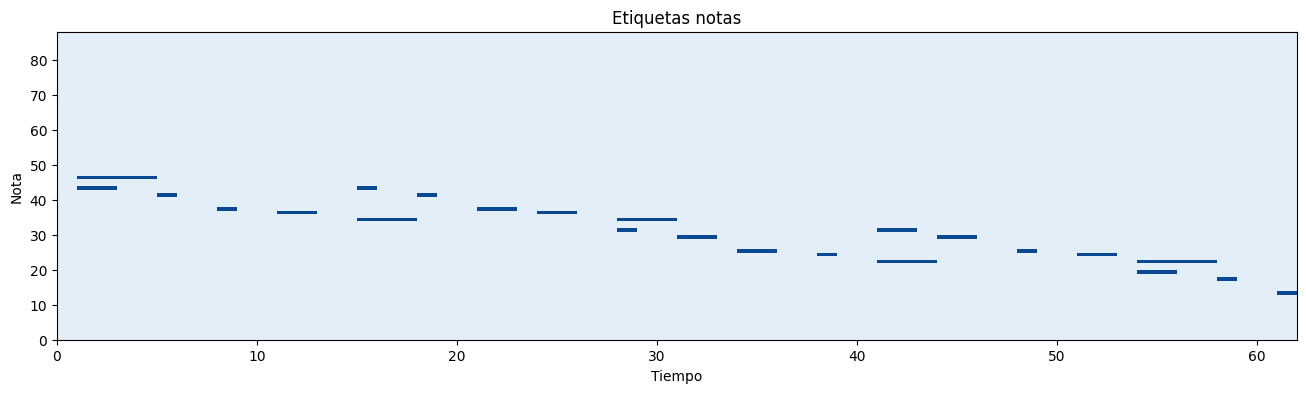

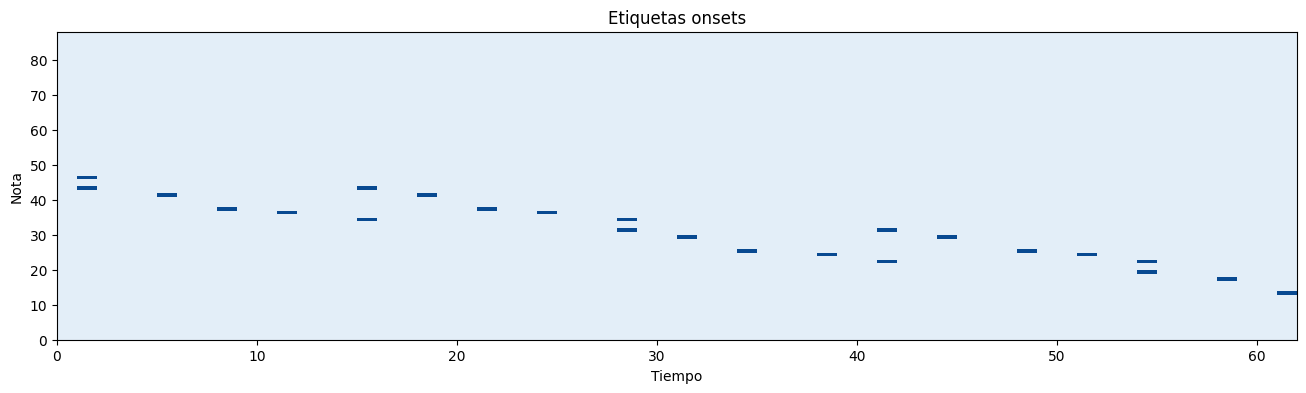

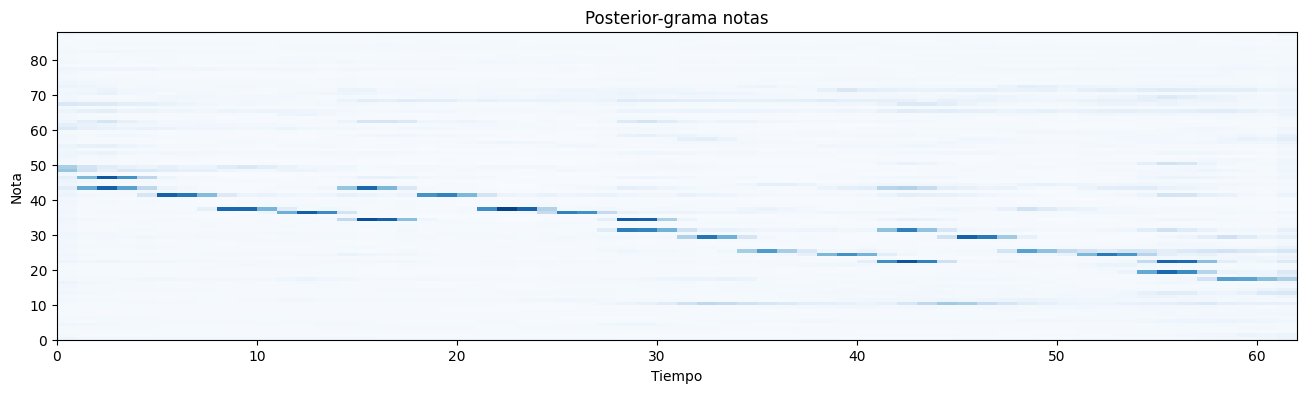

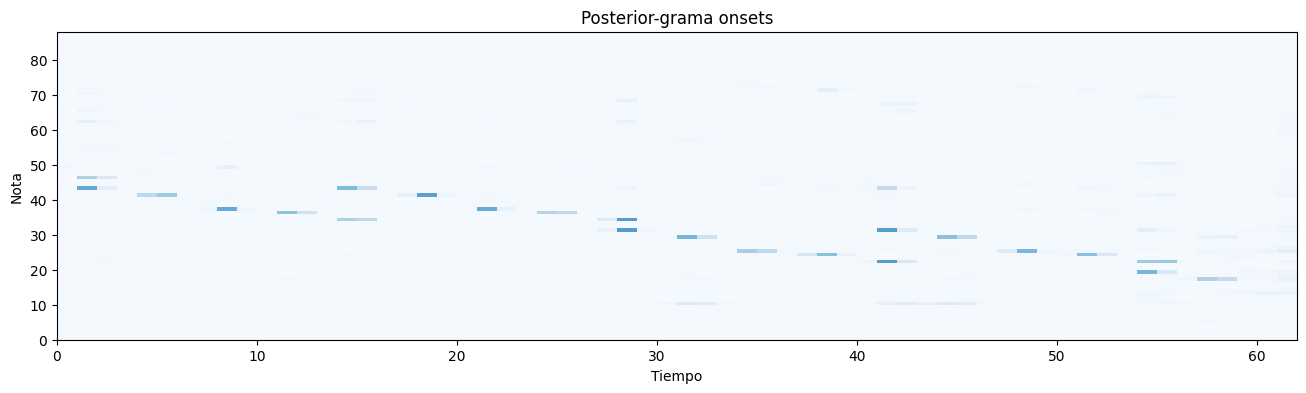

In [ ]:
# Hiperparámetros
learning_rate = 0.0001
epochs = 100
harmonics=[0.5, 1, 2, 3, 4, 5, 6, 7]
label_smoothing=True

# Definir la función de pérdida con sigmoid focal loss
note_criterion = FocalLoss()
onset_criterion = FocalLoss()

# Objeto para llevar a cabo early stopping
early_stopper = EarlyStopper(patience=5, min_delta=0)

# Crear la red y moverla a la GPU si está disponible
model = CNN_Model(harmonics).to(device)
n_params=sum(p.numel() for p in model.parameters())
print("El número de parámetros del modelo es:", n_params)
# Definir optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Directorio en Google Drive donde se guardará el modelo
save_path = '/content/drive/My Drive/TFG/deep_bp_all_7_ls_fl_log.pth'

# Lista para almacenar la pérdida de entrenamiento y validación de cada época
train_losses = []
val_losses = []

# Entrenar la red
for epoch in range(epochs):
    # Entrenamiento
    model.train()
    train_loss = 0.0
    epoch_note_loss = 0.0
    epoch_onset_loss = 0.0
    for i, (cqt, target_notes, target_onsets) in enumerate(train_loader):
        # Obtener espectrograma pasar como input al modelo
        cqt, target_notes, target_onsets = cqt.to(device), target_notes.to(device), target_onsets.to(device)
        # Aplicar label_smoothing si procede
        if (label_smoothing):
            target_notes[target_notes==1]=0.9
            target_notes[target_notes==0]=0.1
            target_onsets[target_onsets==1]=0.9
            target_onsets[target_onsets==0]=0.1

        output_notes, output_onsets = model(cqt)
        # Obtener funciones de pérdida
        note_loss = note_criterion(torch.squeeze(output_notes), torch.squeeze(target_notes))
        onset_loss = onset_criterion(torch.squeeze(output_onsets), torch.squeeze(target_onsets))
        total_loss = note_loss+onset_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()
        epoch_note_loss+=note_loss.item()
        epoch_onset_loss+=onset_loss.item()

    train_loss /= len(train_loader)
    epoch_note_loss /= len(train_loader)
    epoch_onset_loss /= len(train_loader)

    train_losses.append(train_loss)
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for cqt, target_notes, target_onsets in val_loader:
            # Obtener espectrograma pasar como input al modelo
            cqt, target_notes, target_onsets = cqt.to(device), target_notes.to(device), target_onsets.to(device)
            # Aplicar label_smoothing si procede
            if (label_smoothing):
                target_notes[target_notes==1]=0.9
                target_notes[target_notes==0]=0.1
                target_onsets[target_onsets==1]=0.9
                target_onsets[target_onsets==0]=0.1
            output_notes, output_onsets = model(cqt)
            # Obtener funciones de pérdida
            note_loss = note_criterion(torch.squeeze(output_notes), torch.squeeze(target_notes))
            onset_loss = onset_criterion(torch.squeeze(output_onsets), torch.squeeze(target_onsets))
            total_loss = note_loss + onset_loss
            val_loss += total_loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss}, Train Note Loss: {epoch_note_loss}, Train Onset Loss: {epoch_onset_loss}, Validation Loss: {val_loss}')
    if early_stopper.early_stop(val_loss):
        print("Entrenamiento finalizado con Early Stopping")
        break
    # Guardar el modelo entrenado en Google Drive
    torch.save(model.state_dict(), save_path)
# Ejemplos de salida
visualize_piano_roll(target_notes[0].cpu().numpy(), title="Etiquetas notas")
visualize_piano_roll(target_onsets[0].cpu().numpy(), title="Etiquetas onsets")
visualize_piano_roll(torch.sigmoid(output_notes[0][0]).cpu().numpy(), title="Posterior-grama notas")
visualize_piano_roll(torch.sigmoid(output_onsets[0][0]).cpu().numpy(), title="Posterior-grama onsets")

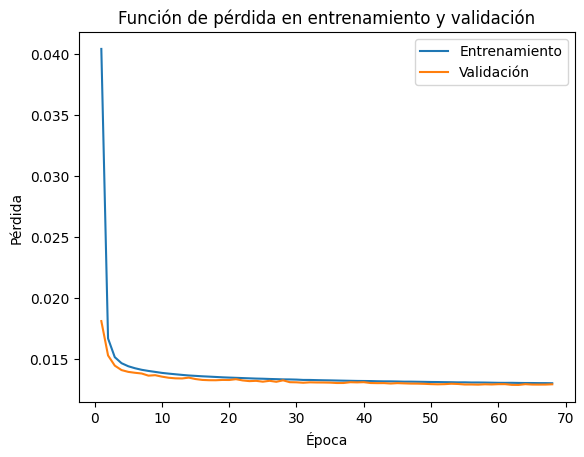

In [ ]:
plot_lr_curves(train_losses, val_losses)

## Validación

### Cargar modelo pre-entrenado de Drive

In [ ]:
harmonics=[0.5, 1, 2, 3, 4, 5, 6, 7]
# Crear la red y moverla a la GPU si está disponible
model = CNN_Model(harmonics).to(device)

# Ruta con los pesos del modelo
model_path = '/content/drive/MyDrive/TFG/deep_bp_all_7_ls_fl_log.pth'
# Carga los pesos al modelo
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [ ]:
# Obtener predicciones de un modelo (con post-procesado)
predicted_pianorolls, predicted_note_events=get_model_predictions(model, val_loader, onsets=True)

Batch 10 completado
Batch 20 completado
Batch 30 completado
Batch 40 completado
Batch 50 completado
Batch 60 completado
Batch 70 completado


### Métricas de error por frame

Accuracy: 0.46632779550894793
Precision: 0.9237748921614866
Recall: 0.7798247556583756
F1 Score: 0.8457181010633155


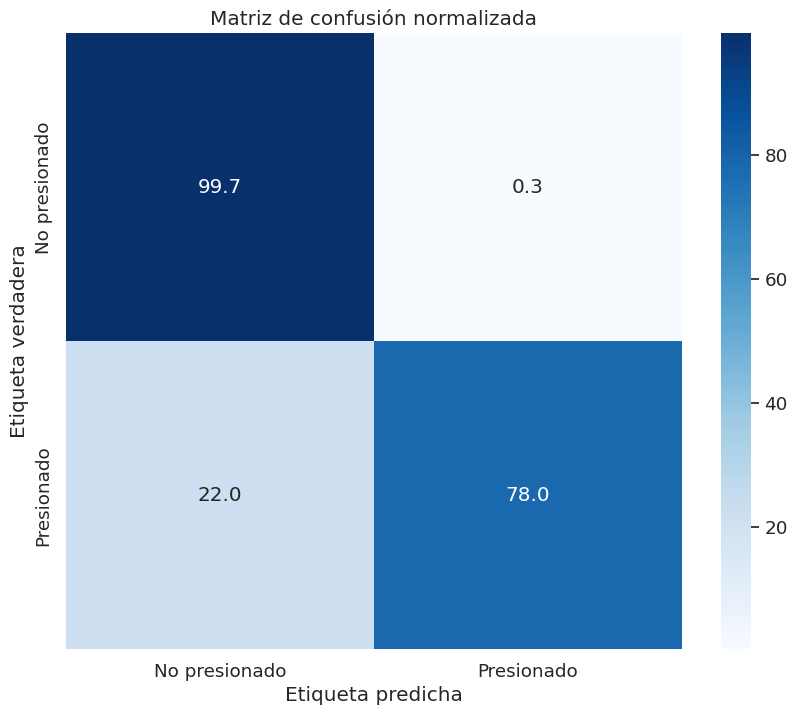

In [ ]:

# Concatenar predicciones y etiquetas de todas las secciones por frames
frame_labels = np.concatenate(val_dataset.labels, axis=1).T
frame_predictions=np.concatenate(predicted_pianorolls, axis=1).T

accuracy, precision, recall, f1=get_frame_metrics(frame_predictions, frame_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

show_confusion_matrix(frame_predictions, frame_labels)

### Ejemplo de salida de la red y de predicción

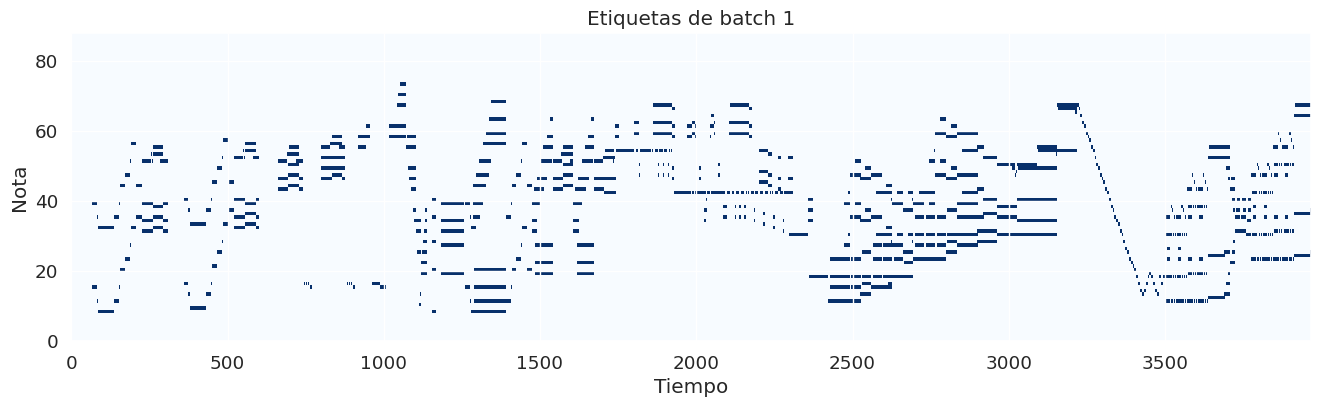

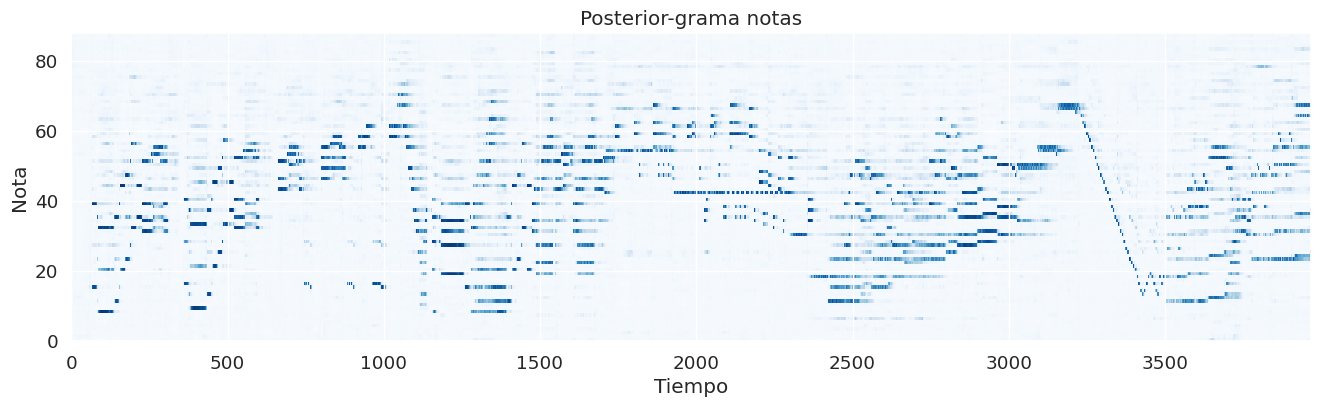

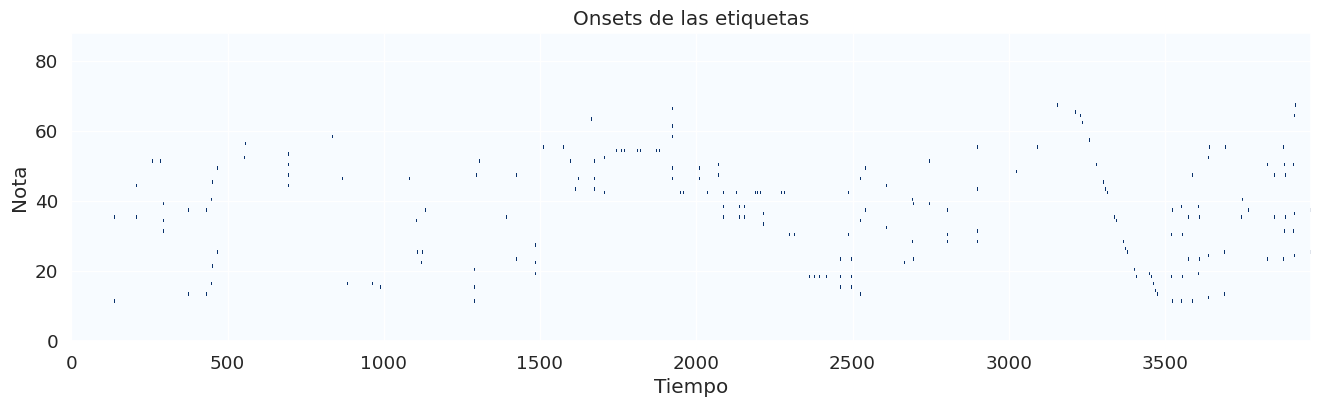

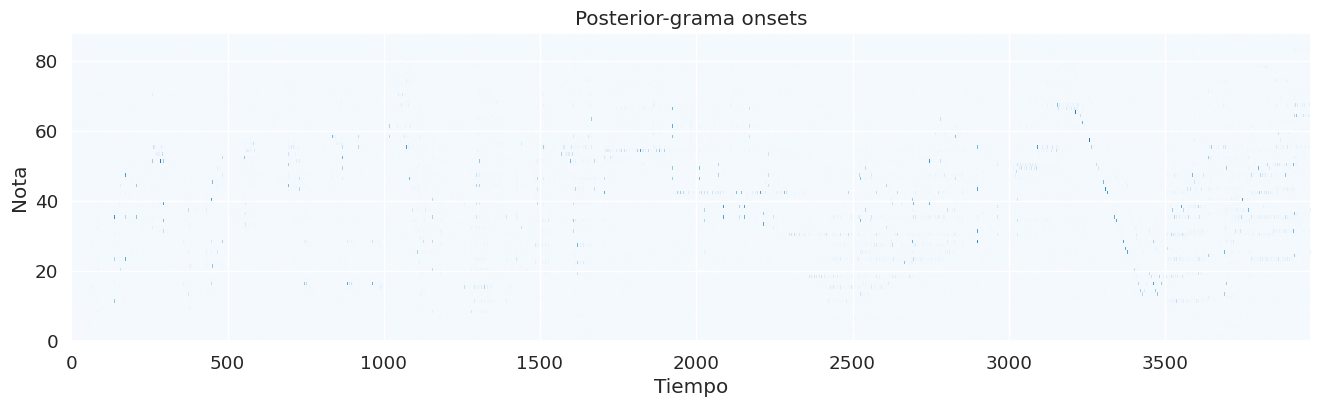

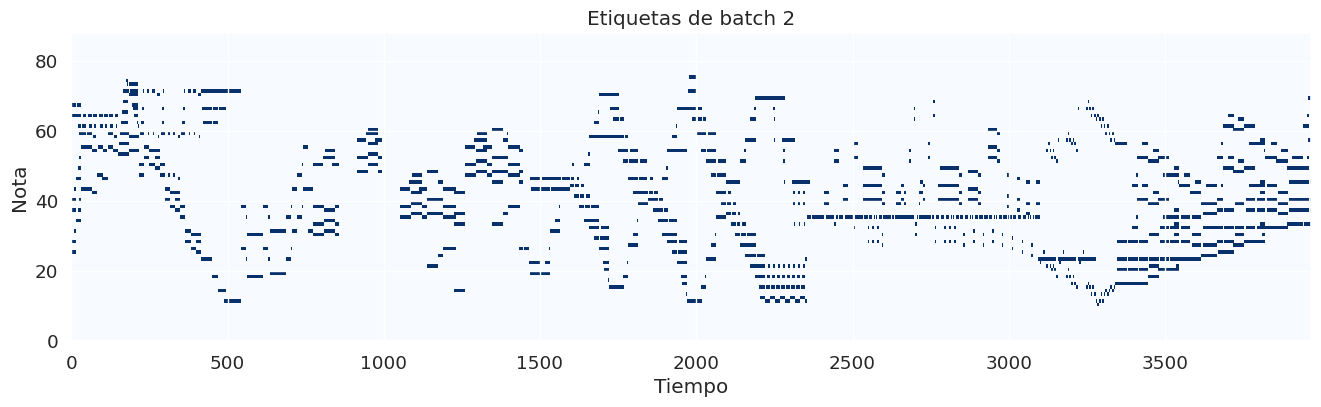

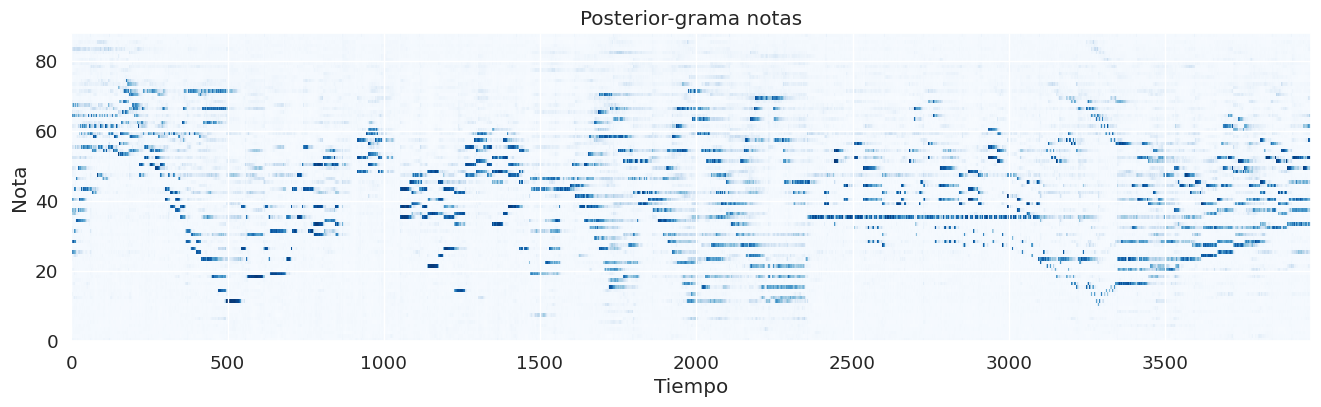

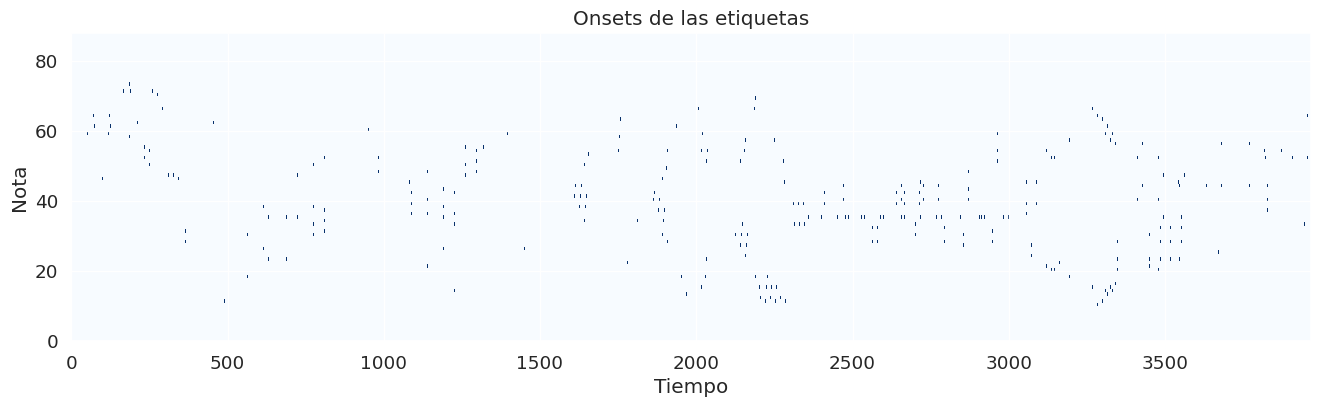

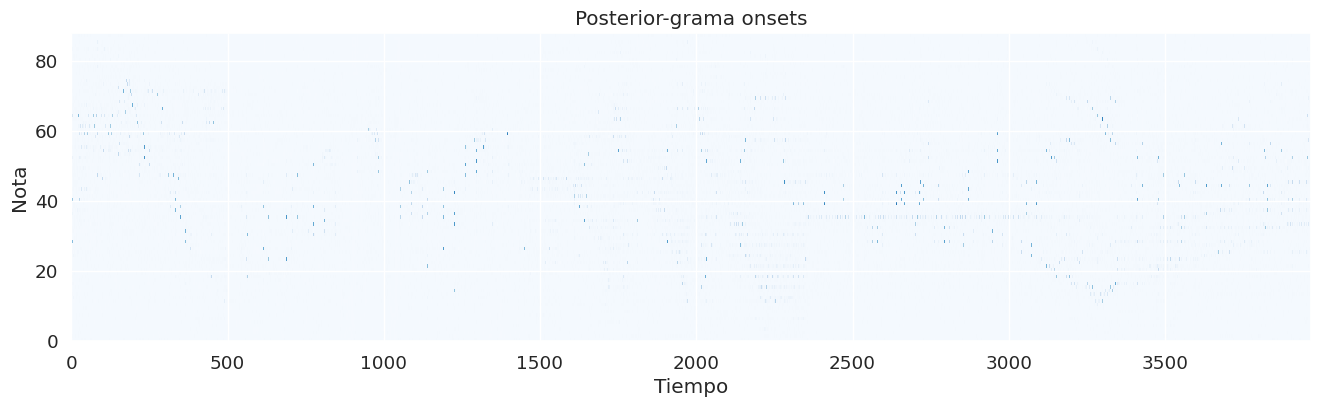

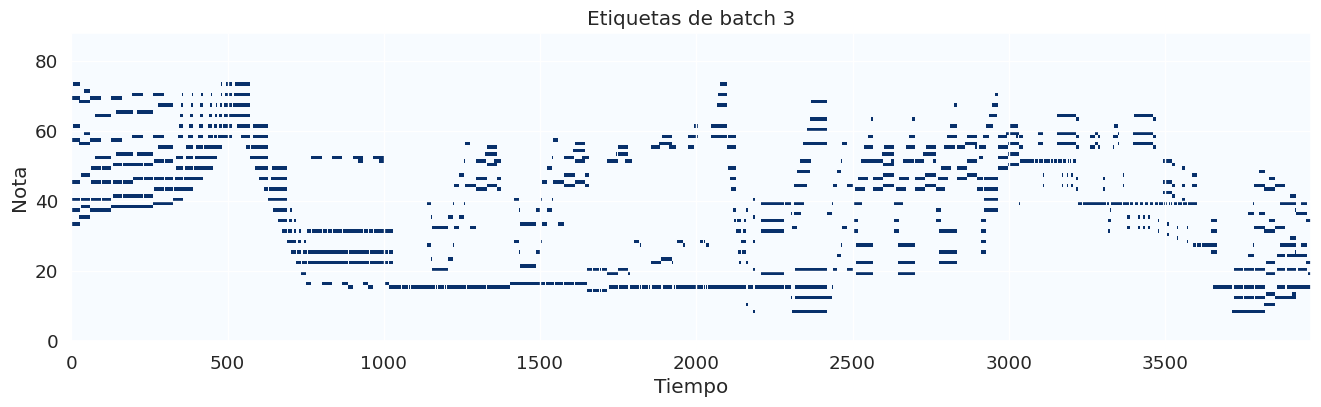

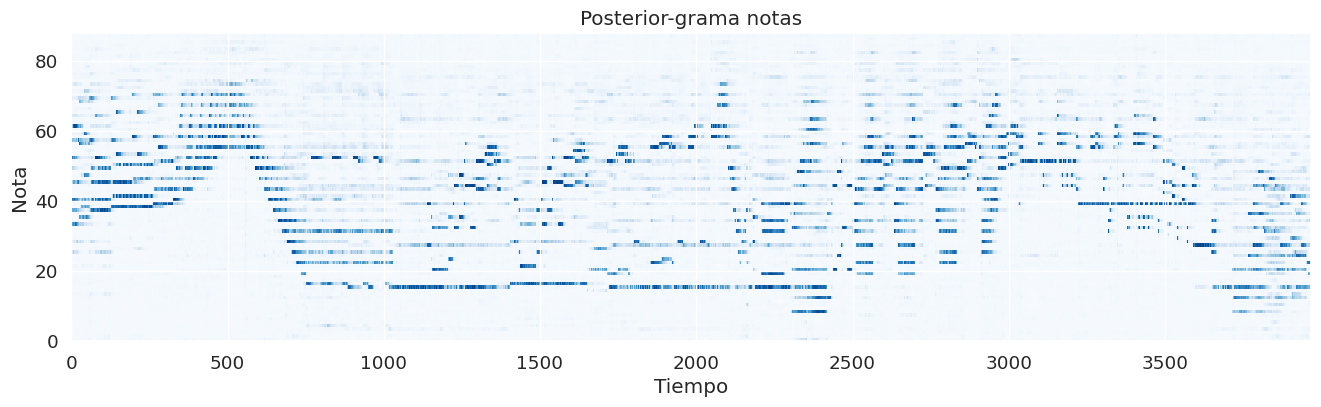

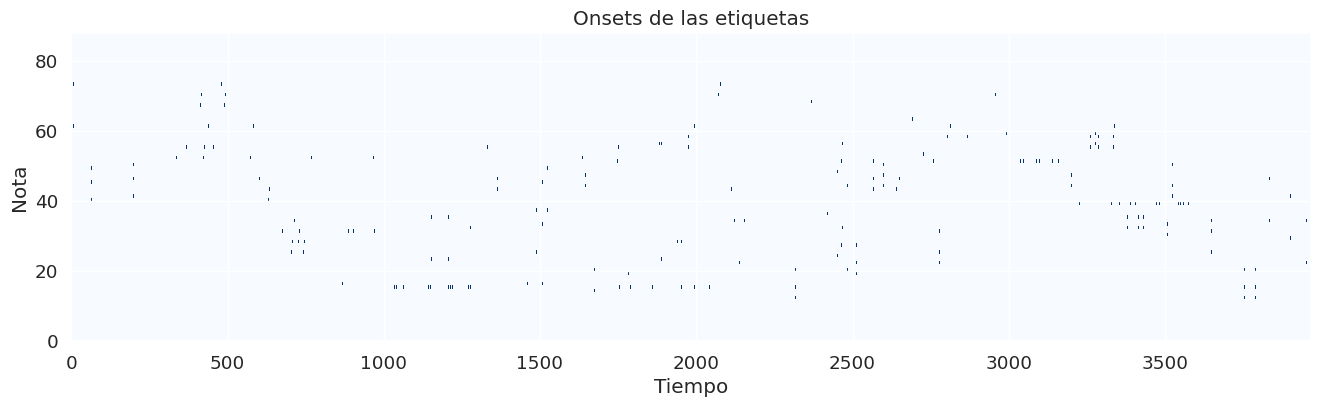

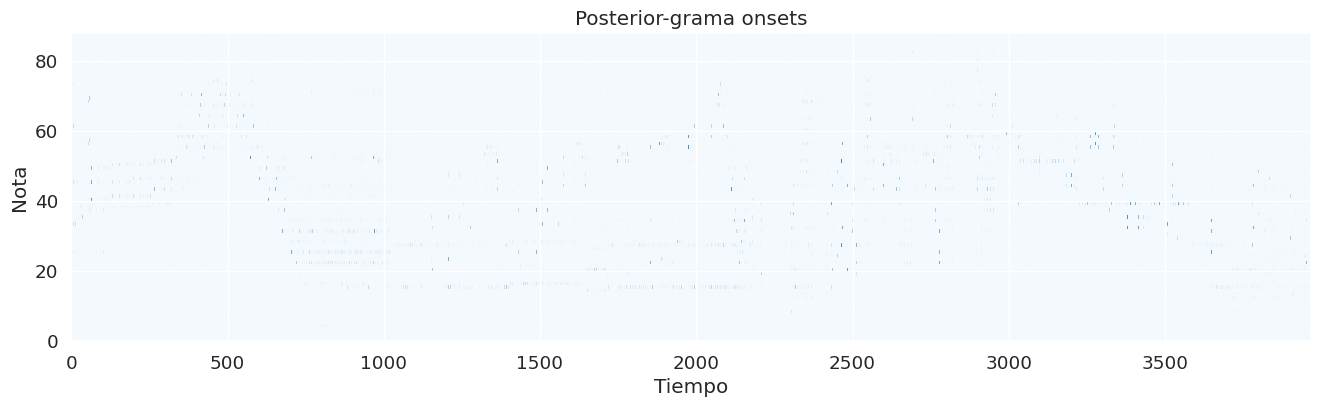

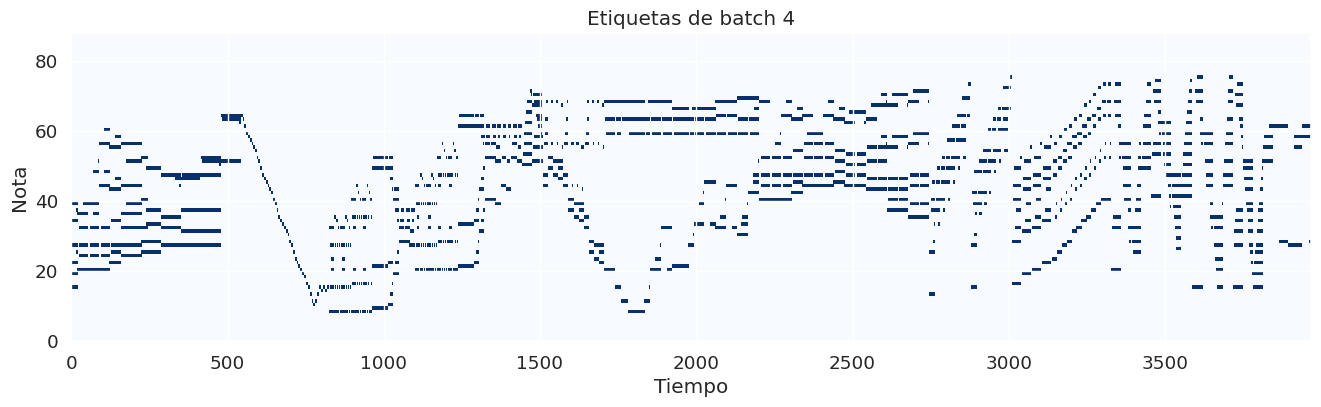

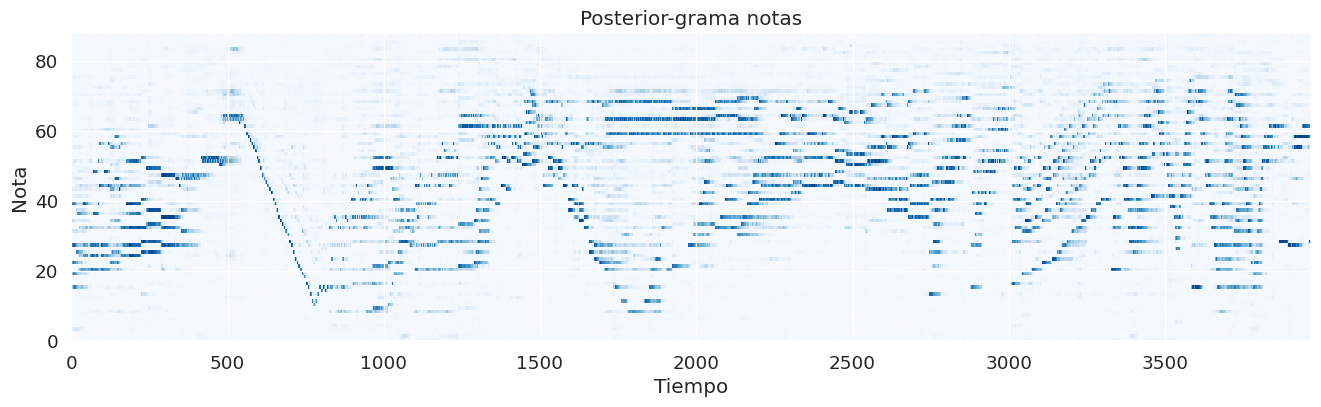

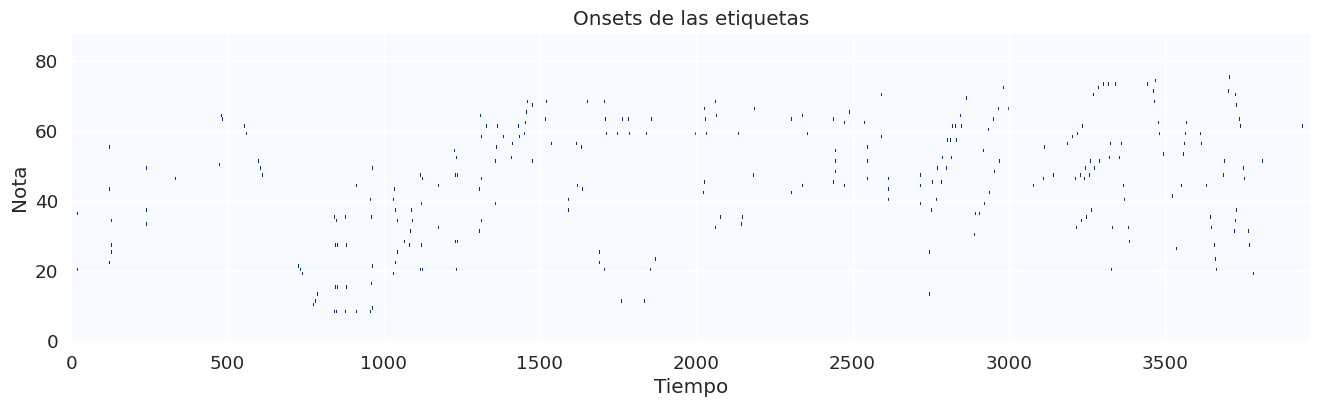

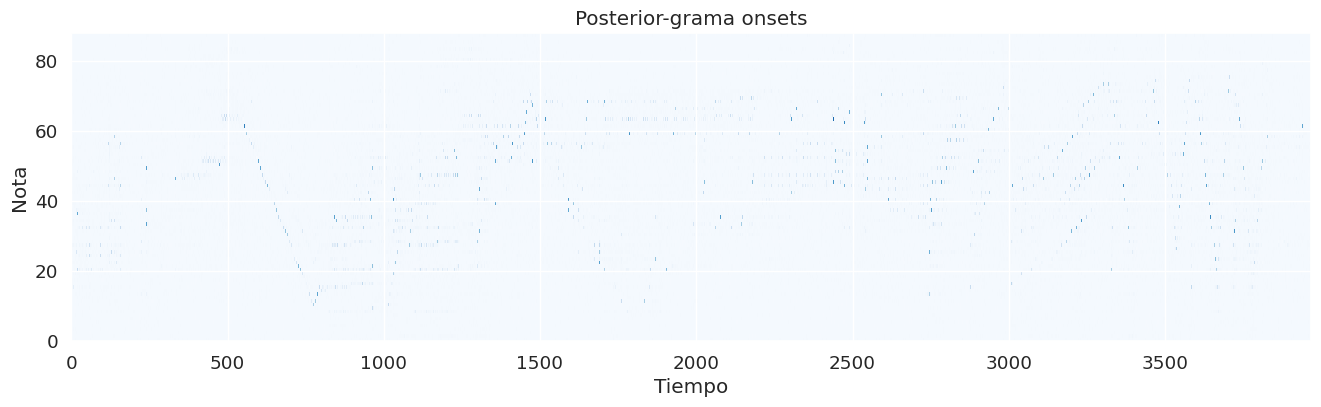

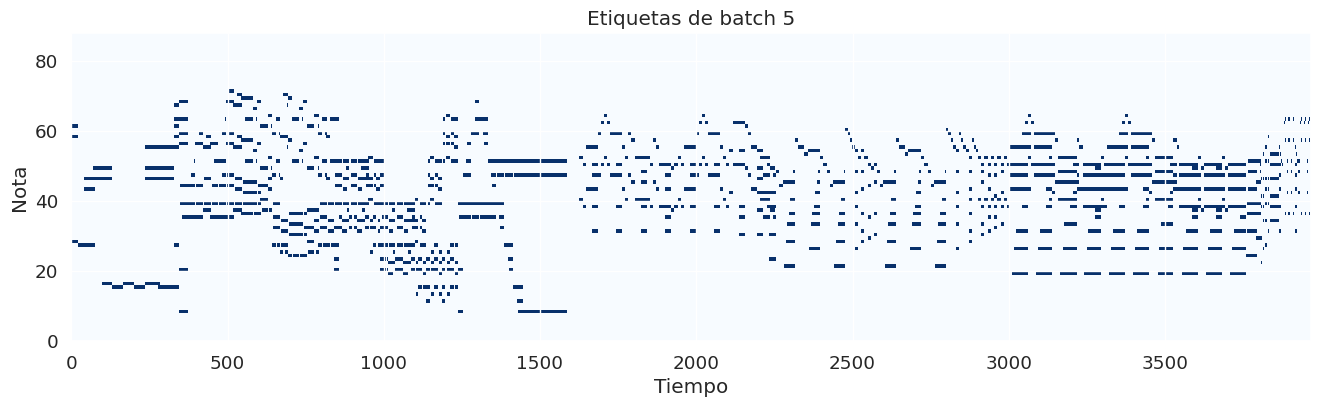

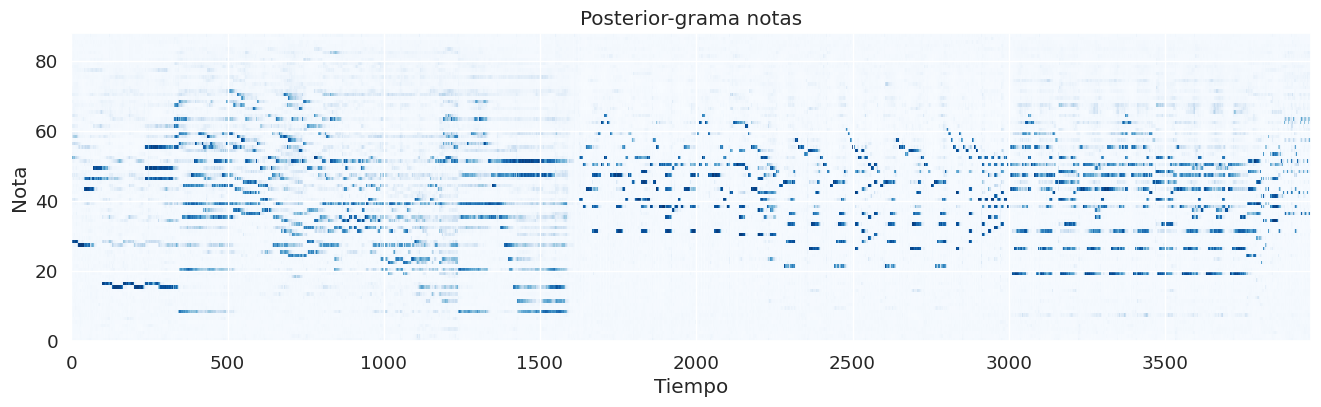

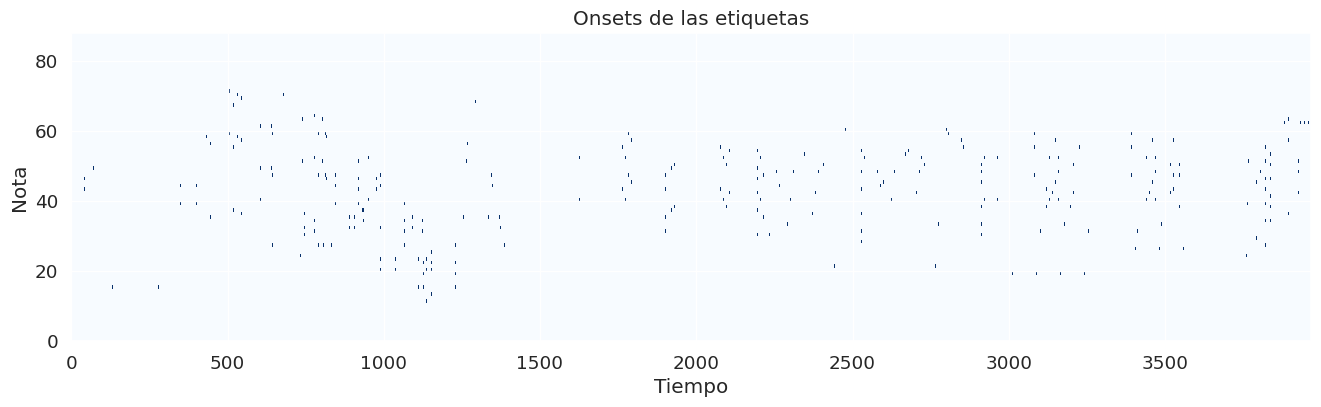

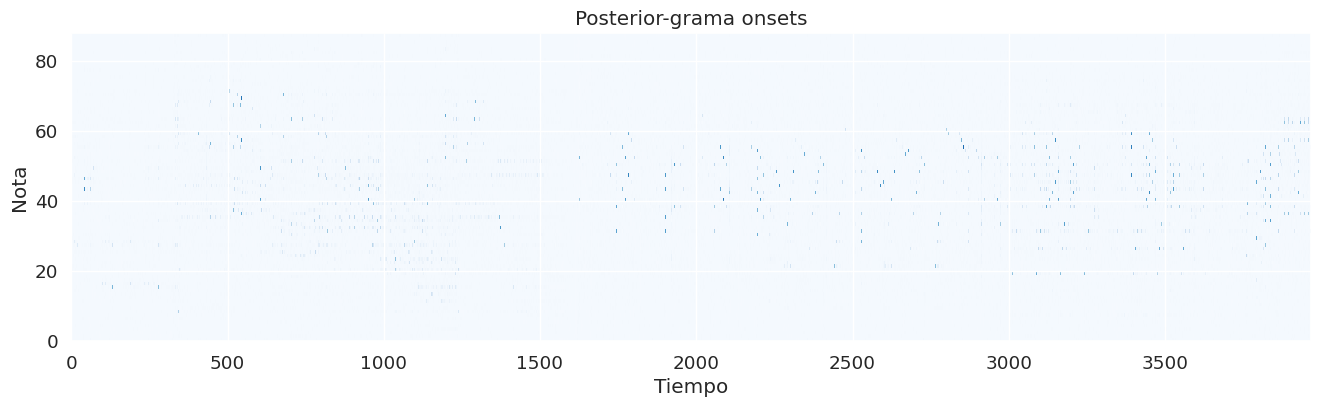

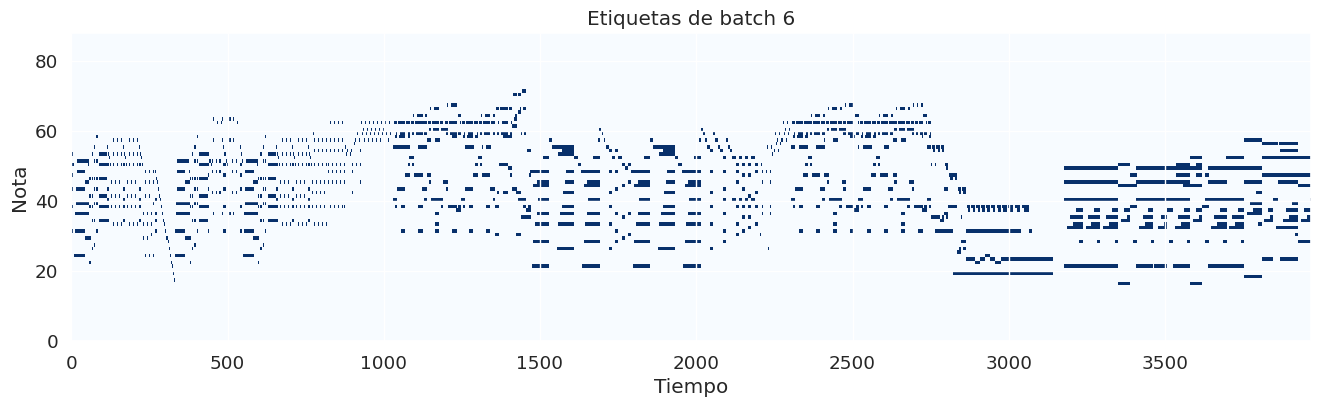

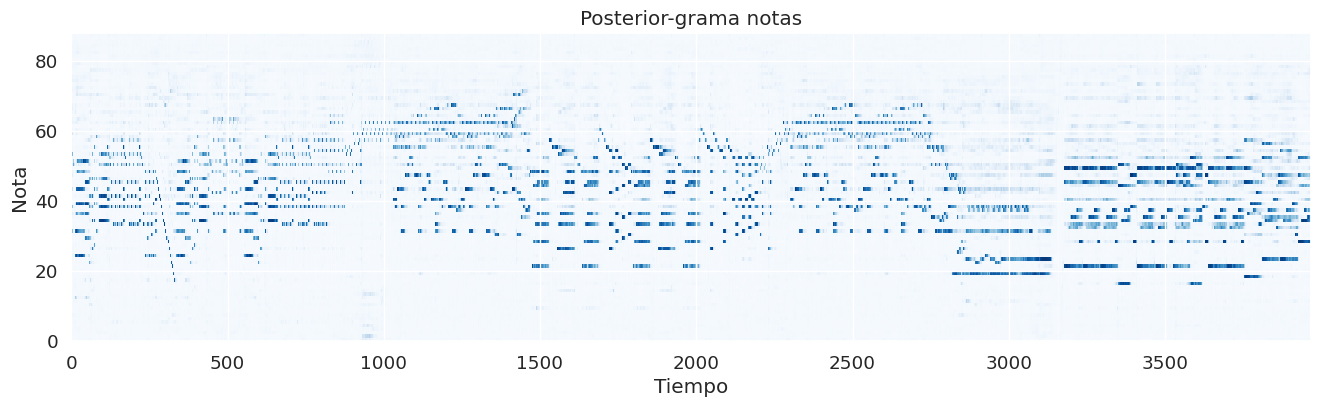

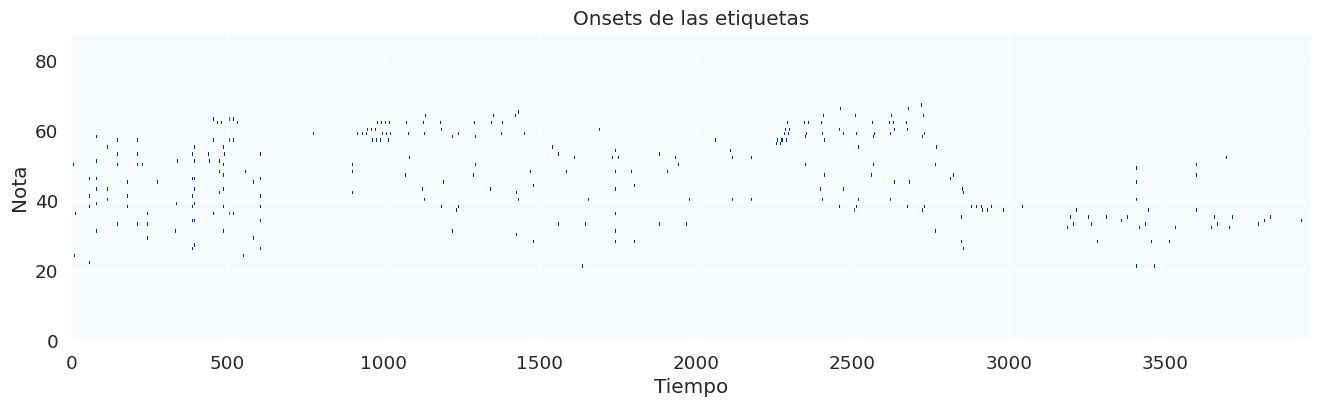

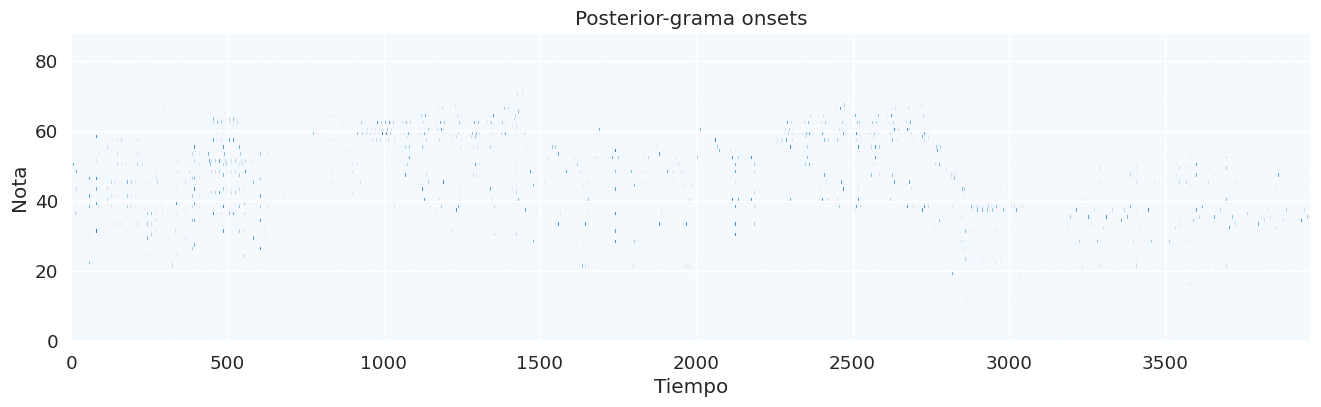

([], [])

In [ ]:
show_model_outputs(model, val_loader)

### Métricas generales a nivel de nota

In [ ]:
# Obtener eventos de nota de las etiquetas
label_note_events=[pianoroll_to_note_events(l) for l in val_dataset.labels]

# Métricas sobre el onset
f1, precision, recall = get_note_wise_metrics(predicted_note_events, label_note_events, offset_ratio=None)
print("Onset F1:", f1)
print("Onset Precision:", precision)
print("Onset Recall:", recall)

# Métricas sobre onset y offset
f1, precision, recall = get_note_wise_metrics(predicted_note_events, label_note_events)
print("Note-wise F1:", f1)
print("Note-wise Precision:", precision)
print("Note-wise Recall:", recall)

/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:165: UserWarning: Reference notes are empty.
  warnings.warn("Reference notes are empty.")
/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:167: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")


Onset F1: 0.8215647302640422
Onset Precision: 0.9058805178599283
Onset Recall: 0.7516080187397275
Note-wise F1: 0.6470267861563599
Note-wise Precision: 0.7134300421151146
Note-wise Recall: 0.5919320814298101


### Métricas a nivel de nota por tono

In [ ]:
# Juntar pianorolls de todas las secciones
total_predicted_pianoroll=np.concatenate(predicted_pianorolls, axis=1)
total_label_pianoroll=np.concatenate(val_dataset.labels, axis=1)

pitch_f1s, pitch_precisions, pitch_recalls=get_onset_metrics_per_pitch(total_predicted_pianoroll, total_label_pianoroll)

print("Onset F1:", np.mean(pitch_f1s))
print("Onset Precision:", np.mean(pitch_precisions))
print("Onset Recall:", np.mean(pitch_recalls))

Onset F1: 0.6928883092935026
Onset Precision: 0.7770047003198172
Onset Recall: 0.6548549535410304


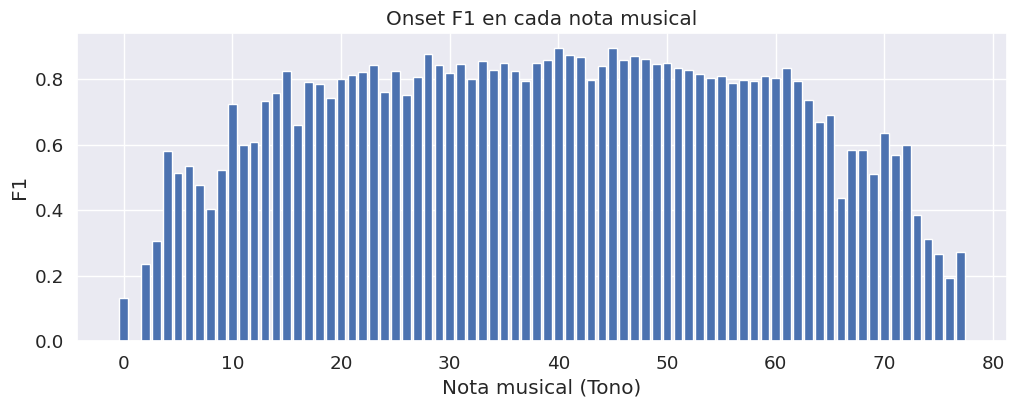

In [ ]:
show_pitch_f1s()

La longitud media de las notas predichas es: 0.5365712681328966
La longitud media de las notas en las etiquetas es: 0.5269859840298179
El número de notas que predice nuestro modelo es: 64110
El número de notas en nuestras etiquetas es: 77269


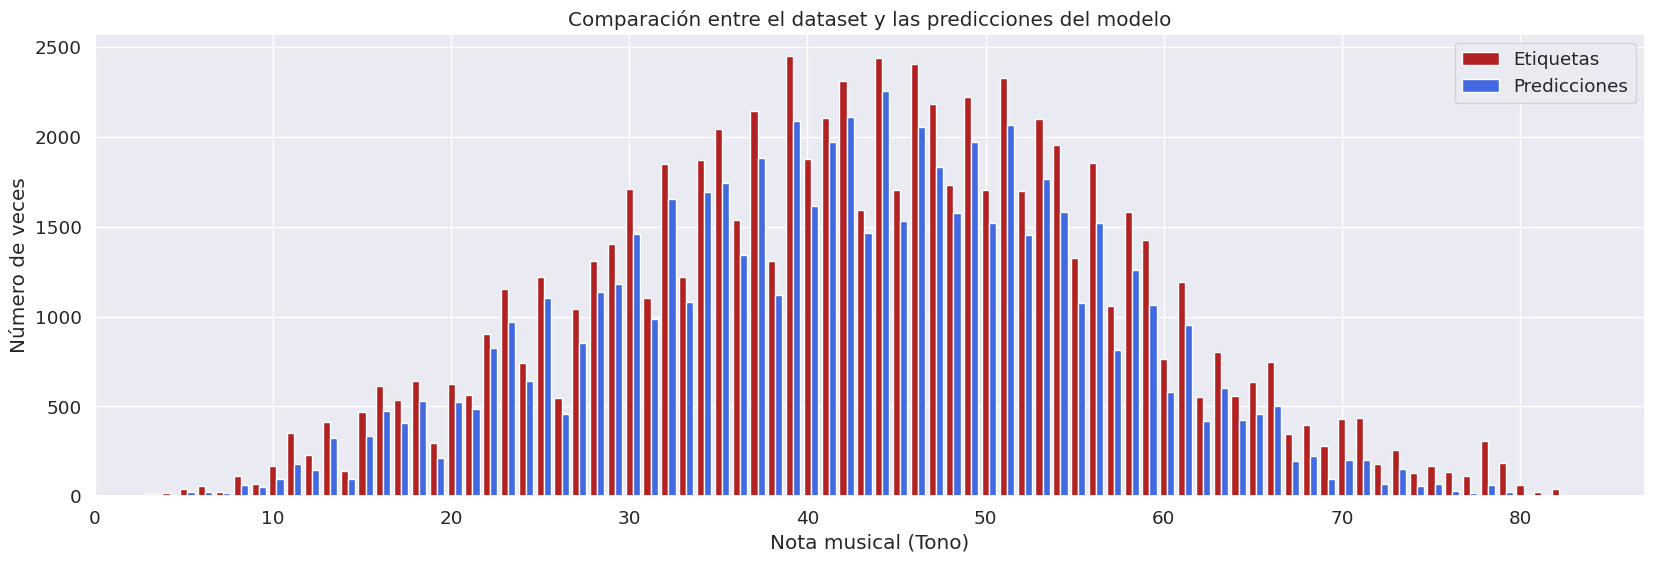

In [ ]:
# Obtener duraciones de notas predichas y de etiquetas
predicted_durations=[]
for pitch in predicted_note_events:
    for event in pitch:
        predicted_durations.append((event["end_time"] - event["start_time"]+1) * FRAME_DURATION)

label_durations=[]
for pitch in label_note_events:
    for event in pitch:
        label_durations.append((event["end_time"] - event["start_time"]+1) * FRAME_DURATION)

n_predicted_notes=count_pitch_from_note_events(predicted_note_events)
n_label_notes=count_pitch_from_note_events(label_note_events)

print("La longitud media de las notas predichas es:", np.mean(predicted_durations))
print("La longitud media de las notas en las etiquetas es:", np.mean(label_durations))

print("El número de notas que predice nuestro modelo es:", sum(n_predicted_notes))
print("El número de notas en nuestras etiquetas es:", sum(n_label_notes))

show_n_notes(n_predicted_notes, n_label_notes)

## Test

In [ ]:

# Rutas al dataset
data_paths = ["/content/ENSTDkAm", "/content/ENSTDkCl"]
test_dataset=create_test_dataset(data_paths, SpecDataset)

# Crear un DataLoader para el dataset
BATCH_SIZE = 64
num_workers = 0  # Número de procesos para cargar los datos

# Crear los DataLoaders para entrenamiento y validación
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

print("Número de ejemplos en test:", len(test_dataset))

Número de ejemplos en test: 7886


In [ ]:
# Obtener predicciones de un modelo (con post-procesado)
predicted_pianorolls, predicted_note_events=get_model_predictions(model, test_loader, onsets=True)

Batch 10 completado
Batch 20 completado
Batch 30 completado
Batch 40 completado
Batch 50 completado
Batch 60 completado
Batch 70 completado
Batch 80 completado
Batch 90 completado
Batch 100 completado
Batch 110 completado
Batch 120 completado


### Métricas a nivel de frame

Accuracy: 0.30544533800201257
Precision: 0.872107847437988
Recall: 0.6839080977897519
F1 Score: 0.7666266156694606


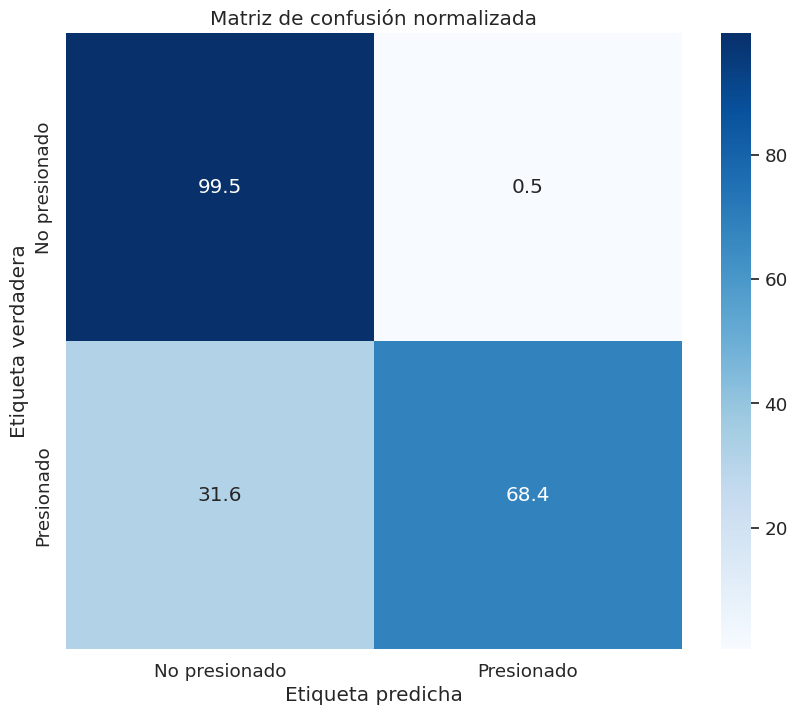

In [ ]:

# Concatenar predicciones y etiquetas de todas las secciones por frames
frame_labels = np.concatenate(test_dataset.labels, axis=1).T
frame_predictions=np.concatenate(predicted_pianorolls, axis=1).T

accuracy, precision, recall, f1=get_frame_metrics(frame_predictions, frame_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

show_confusion_matrix(frame_predictions, frame_labels)

### Métricas generales a nivel de nota

In [ ]:
# Obtener eventos de nota de las etiquetas
label_note_events=[pianoroll_to_note_events(l) for l in test_dataset.labels]

# Métricas sobre el onset
f1, precision, recall = get_note_wise_metrics(predicted_note_events, label_note_events, offset_ratio=None)
print("Onset F1:", f1)
print("Onset Precision:", precision)
print("Onset Recall:", recall)

# Métricas sobre onset y offsetn
f1, precision, recall = get_note_wise_metrics(predicted_note_events, label_note_events)
print("Note-wise F1:", f1)
print("Note-wise Precision:", precision)
print("Note-wise Recall:", recall)

/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:165: UserWarning: Reference notes are empty.
  warnings.warn("Reference notes are empty.")
/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:167: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")


Onset F1: 0.6960923904445498
Onset Precision: 0.7792339219754086
Onset Recall: 0.6289821924522137


/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:165: UserWarning: Reference notes are empty.
  warnings.warn("Reference notes are empty.")
/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:167: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")
/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:165: UserWarning: Reference notes are empty.
  warnings.warn("Reference notes are empty.")
/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:167: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")
/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:165: UserWarning: Reference notes are empty.
  warnings.warn("Reference notes are empty.")
/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:167: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")


Note-wise F1: 0.488394693425543
Note-wise Precision: 0.546728735515863
Note-wise Recall: 0.4413086097042967


# Modelo U-Net

### Cargar el dataset

In [ ]:
# Dataset que no devuelve etiquetas de onsets
class SpecDataset(Dataset):
    def __init__(self, wav_paths, transform=None):
        self.transform = transform
        self.wav_paths=wav_paths
        self.features=[]
        self.labels=[]
        label_paths=[]
        # Obtener rutas etiquetas
        for path in wav_paths:
          label_paths += [path[:-4]+".txt" for path in wav_paths]

        # Obtener features y etiquetas
        for j, (img_p, label_p) in enumerate(zip(wav_paths, label_paths)):

          # Obtener las características y las etiquetas
          y, sr=get_wav(img_p)
          cqt = get_cqt(y, sr)
          N_SECTIONS=cqt.shape[1] // N_FRAMES_PER_SECTION

          duration=librosa.get_duration(y=y, sr=sr)
          label = get_pianoroll_from_txt(label_p, cqt.shape[1], duration)

          for i in range(N_SECTIONS):
              feature_section=cqt[:,i*N_FRAMES_PER_SECTION : (i+1)*N_FRAMES_PER_SECTION]
              label_section=label[:,i*N_FRAMES_PER_SECTION : (i+1)*N_FRAMES_PER_SECTION]
              if (feature_section.shape[1]==label_section.shape[1]):
                  self.features.append(feature_section)
                  self.labels.append(label_section)
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
      feature=self.features[idx]
      label=self.labels[idx]
        # Aplicar transformaciones si se proporcionan
      if self.transform:
          feature = self.transform(feature)
      # Convertir numpy array a tensor de PyTorch
      feature = torch.from_numpy(feature)

      return feature, label

In [ ]:
# Rutas al dataset
data_paths = ['/content/AkPnBcht/MUS','/content/AkPnBsdf','/content/AkPnCGdD',
              '/content/AkPnStgb','/content/SptkBGAm','/content/SptkBGCl', '/content/StbgTGd2']
train_dataset, val_dataset=create_datasets(data_paths, SpecDataset)

# Crear un DataLoader para el dataset
BATCH_SIZE = 64
num_workers = 0  # Número de procesos para cargar los datos

# Crear los DataLoaders para entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

print("Número de ejemplos en validación:", len(val_dataset))
print("Número de ejemplos en train:", len(train_dataset))

Número de ejemplos en validación: 4528
Número de ejemplos en train: 20302


### Arquitectura

In [ ]:
class HarmonicStacking(nn.Module):
    def __init__(self, harmonics):
        super(HarmonicStacking, self).__init__()
        self.harmonics=harmonics
        self.shifts=[int(np.round(N_BINS_PER_OCTAVE*np.log2(h))) for h in harmonics]

    def forward(self, x):
        n_batch, n_bins, n_frames= x.shape
        shifted=torch.zeros((n_batch, len(self.harmonics), n_bins, n_frames)).to(device)
        for i, s in enumerate(self.shifts):
          if s==0:
            shifted[:, i]=x
          elif s>0:
            shifted[:, i, :-s, :]=x[:, s:, :]
          elif s<0:
            shifted[:, i, -s:, :]=x[:, :s, :]
        return shifted
class UNet(nn.Module):
    def __init__(self, n_classes, harmonics):
        super(UNet, self).__init__()
        self.hs=HarmonicStacking(harmonics)
        self.inc = ConvBlock(len(harmonics), 64)
        self.enc1 = Encode(64, 128)
        self.enc2 = Encode(128, 256)
        self.enc3 = Encode(256, 512)
        self.enc4 = Encode(512, 512)
        self.dec1 = Decode(1024, 256)
        self.dec2 = Decode(512, 128)
        self.dec3 = Decode(256, 64)
        self.dec4 = Decode(128, 64)
        self.fconv = FinalConv(64, n_classes, stride=(3,1))

    def forward(self, x):
        xh=self.hs(x)
        x1 = self.inc(xh)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)
        x = self.dec1(x5, x4)
        x = self.dec2(x, x3)
        x = self.dec3(x, x2)
        x = self.dec4(x, x1)
        logits = self.fconv(x)
        return logits

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Encode(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encode, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Decode(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decode, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Añade padding para evitar tamaños distintos por aplicar pooling a tamaños impares
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class FinalConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(FinalConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        return self.conv(x)


## Entrenamiento

El número de parámetros del modelo es: 13398209


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/100], Train Loss: 0.024569760369576577, Validation Loss: 0.011316005778301674
Epoch [2/100], Train Loss: 0.010338335590448243, Validation Loss: 0.00946073856239193
Epoch [3/100], Train Loss: 0.009127610114410893, Validation Loss: 0.009020495021501868
Epoch [4/100], Train Loss: 0.008421585361230437, Validation Loss: 0.008664506091111955
Epoch [5/100], Train Loss: 0.007915153179406161, Validation Loss: 0.008438778299776946
Epoch [6/100], Train Loss: 0.00760778095453203, Validation Loss: 0.007864864927440379
Epoch [7/100], Train Loss: 0.007297705973235412, Validation Loss: 0.00790909404625627
Epoch [8/100], Train Loss: 0.0071419318704403064, Validation Loss: 0.007922860501408039
Epoch [9/100], Train Loss: 0.00695203064590742, Validation Loss: 0.007573263795205134
Epoch [10/100], Train Loss: 0.006795014141473046, Validation Loss: 0.007526284255962906
Epoch [11/100], Train Loss: 0.006643884226225153, Validation Loss: 0.008112330111258363
Epoch [12/100], Train Loss: 0.00651789736315

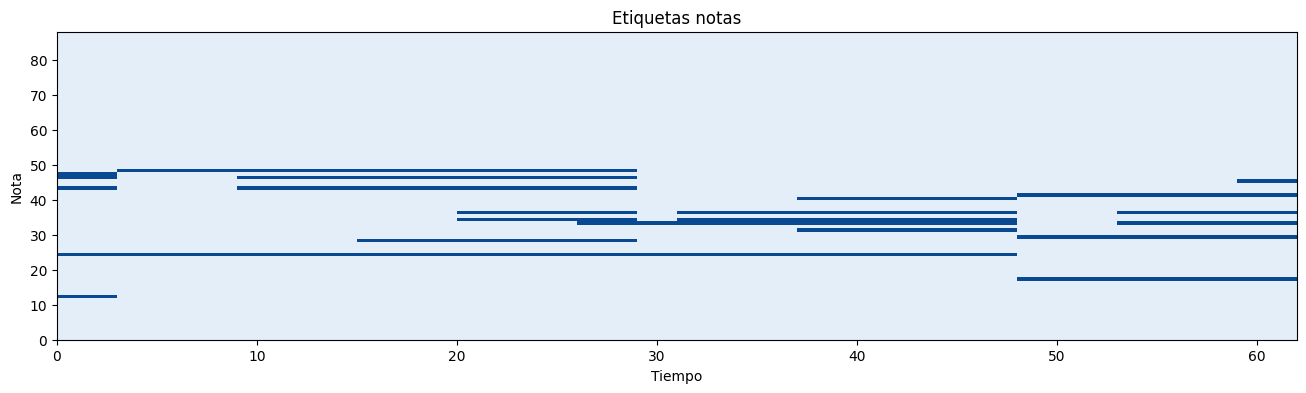

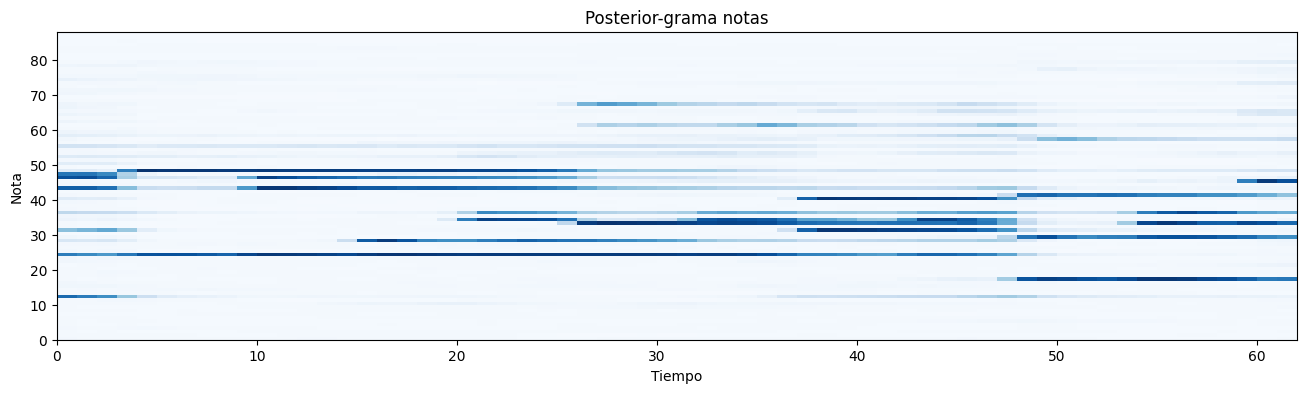

In [ ]:
# Hiperparámetros
learning_rate = 0.0001
epochs = 100
harmonics=[0.5, 1, 2, 3, 4, 5, 6, 7]
label_smoothing=True

# Definir la función de pérdida con sigmoid focal loss
note_criterion = FocalLoss()
onset_criterion = FocalLoss()

# Objeto para llevar a cabo early stopping
early_stopper = EarlyStopper(patience=5, min_delta=0)

# Crear la red y moverla a la GPU si está disponible
model=UNet(n_classes=1, harmonics=harmonics).to(device)
n_params=sum(p.numel() for p in model.parameters())
print("El número de parámetros del modelo es:", n_params)
# Definir optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Directorio en Google Drive donde se guardará el modelo
save_path = '/content/drive/My Drive/TFG/unet_reg.pth'

# Lista para almacenar la pérdida de entrenamiento y validación de cada época
train_losses = []
val_losses = []

# Entrenar la red
for epoch in range(epochs):
    # Entrenamiento
    model.train()
    train_loss = 0.0
    for i, (cqt, target_notes) in enumerate(train_loader):
        # Obtener espectrograma pasar como input al modelo
        cqt, target_notes = cqt.to(device), target_notes.to(device)
        # Aplicar label_smoothing si procede
        if (label_smoothing):
            target_notes[target_notes==1]=0.9
            target_notes[target_notes==0]=0.1

        output_notes = model(cqt)
        # Obtener funciones de pérdida
        note_loss = note_criterion(torch.squeeze(output_notes), torch.squeeze(target_notes))

        optimizer.zero_grad()
        note_loss.backward()
        optimizer.step()

        train_loss+=note_loss.item()

        #if i%10==9:
        #    print(f"Batch {i+1} completado")

    train_loss /= len(train_loader)

    train_losses.append(train_loss)
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (cqt, target_notes) in enumerate(val_loader):
            # Obtener espectrograma pasar como input al modelo
            cqt, target_notes = cqt.to(device), target_notes.to(device)
            # Aplicar label_smoothing si procede
            if (label_smoothing):
                target_notes[target_notes==1]=0.9
                target_notes[target_notes==0]=0.1
            output_notes = model(cqt)
            # Obtener funciones de pérdida
            note_loss = note_criterion(torch.squeeze(output_notes), torch.squeeze(target_notes))
            val_loss += note_loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss}, Validation Loss: {val_loss}')
    if early_stopper.early_stop(val_loss):
        print("Entrenamiento finalizado con Early Stopping")
        break
    torch.save(model.state_dict(), save_path)
# Ejemplos de salida
visualize_piano_roll(target_notes[0].cpu().numpy(), title="Etiquetas notas")
visualize_piano_roll(torch.sigmoid(output_notes[0][0]).detach().cpu().numpy(), title="Posterior-grama notas")

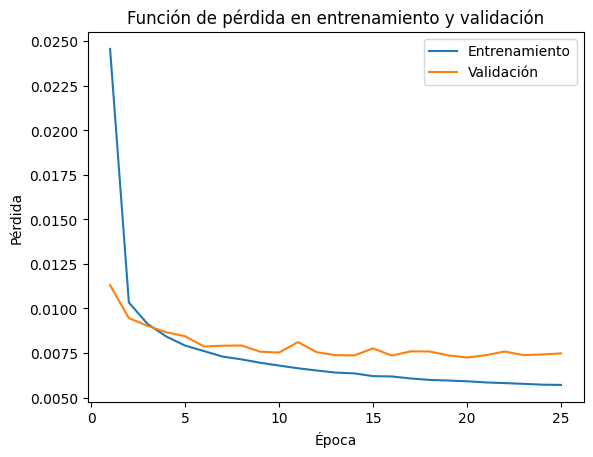

In [ ]:
plot_lr_curves(train_losses, val_losses)

### Cargar modelo pre-entrenado de Drive

In [ ]:
harmonics=[0.5, 1, 2, 3, 4, 5, 6, 7]
# Crear la red y moverla a la GPU si está disponible
model = UNet(1 ,harmonics).to(device)

# Ruta con los pesos del modelo
model_path = '/content/drive/MyDrive/TFG/unet_reg.pth'
# Carga los pesos al modelo
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

## Validación


In [ ]:
# Obtener predicciones de un modelo (con post-procesado)
predicted_pianorolls, predicted_note_events=get_model_predictions(model, val_loader)

Batch 10 completado
Batch 20 completado
Batch 30 completado
Batch 40 completado
Batch 50 completado
Batch 60 completado
Batch 70 completado


### Métricas de error por frame

Accuracy: 0.6780142197651886
Precision: 0.9338914508691025
Recall: 0.9303184647351781
F1 Score: 0.9321015337698448


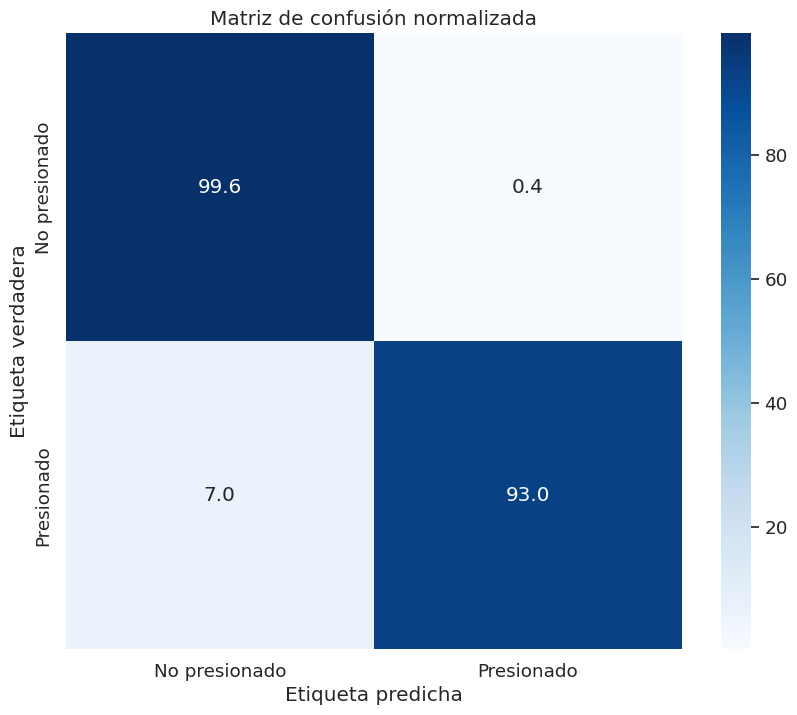

In [ ]:
# Concatenar predicciones y etiquetas de todas las secciones por frames
frame_labels = np.concatenate(val_dataset.labels, axis=1).T
frame_predictions=np.concatenate(predicted_pianorolls, axis=1).T

accuracy, precision, recall, f1=get_frame_metrics(frame_predictions, frame_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

show_confusion_matrix(frame_predictions, frame_labels)

### Ejemplo de salida de la red y de predicción

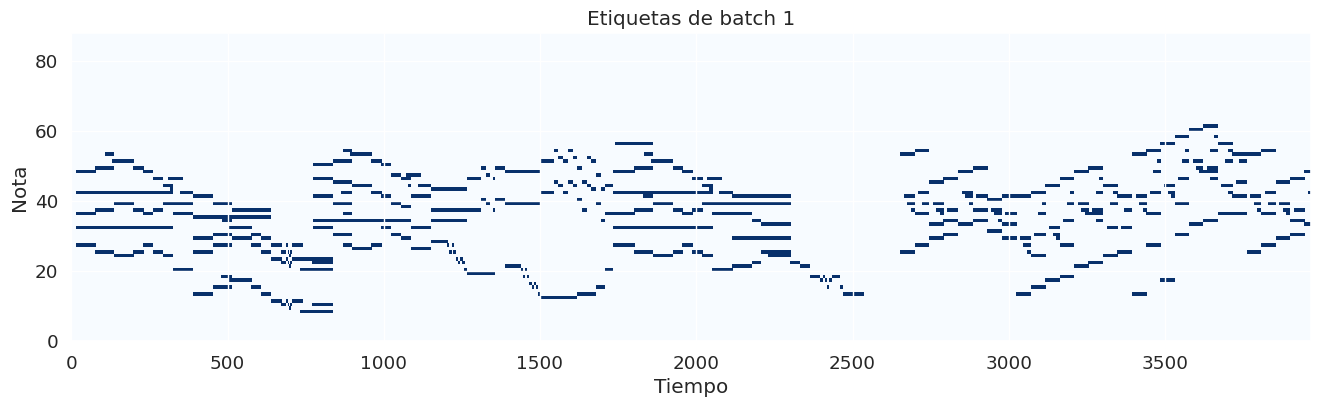

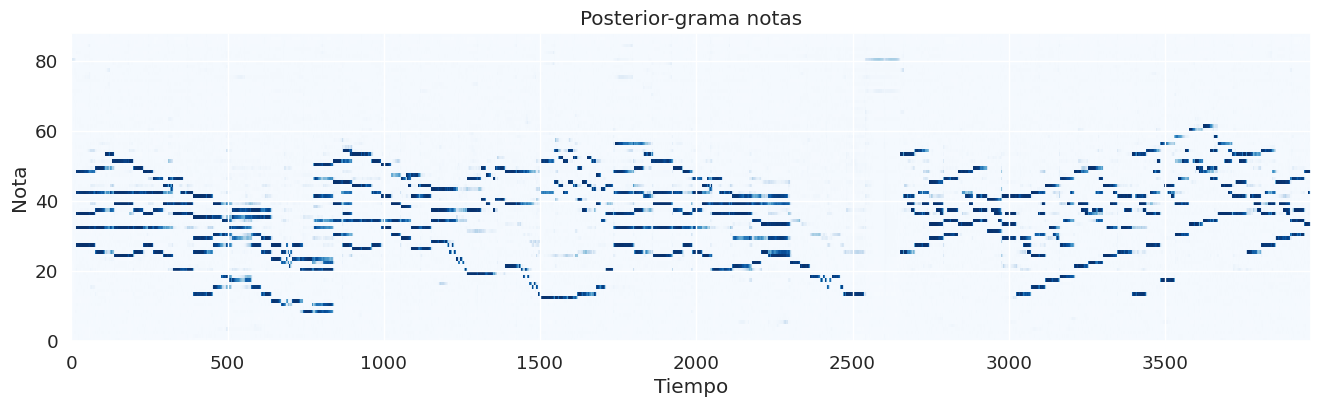

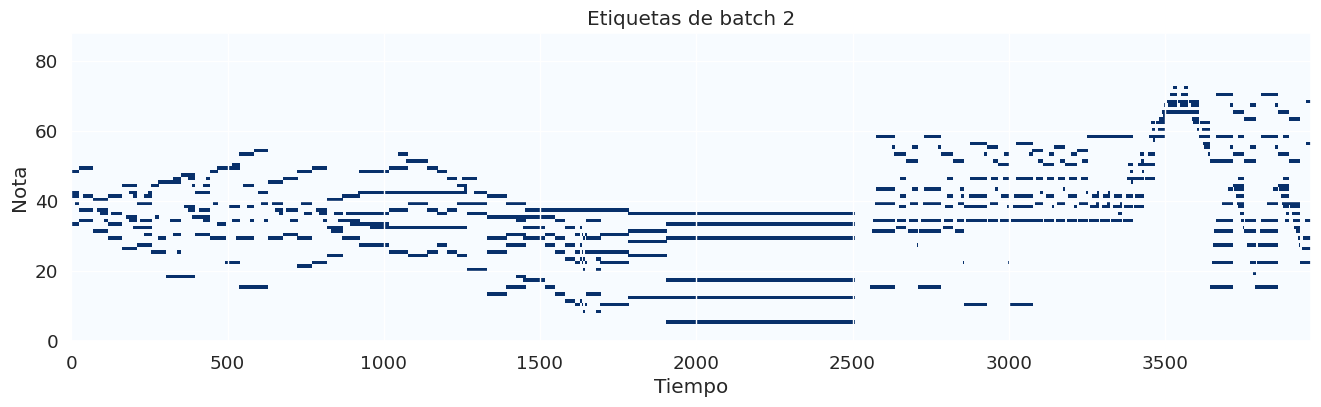

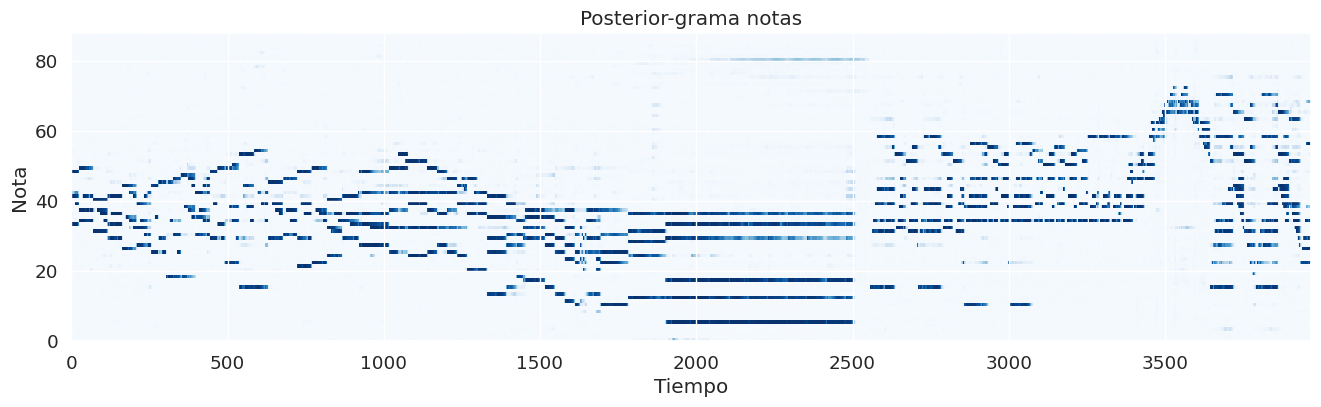

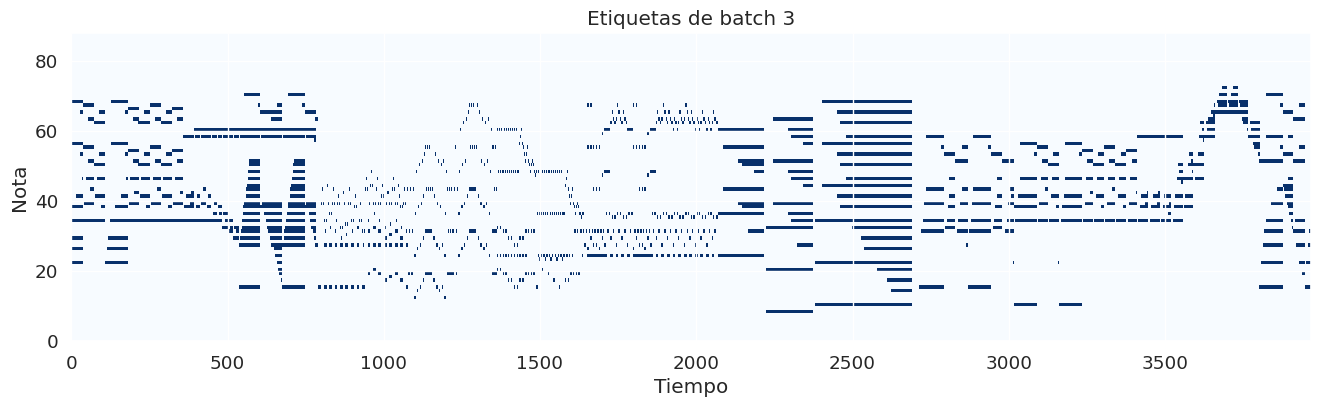

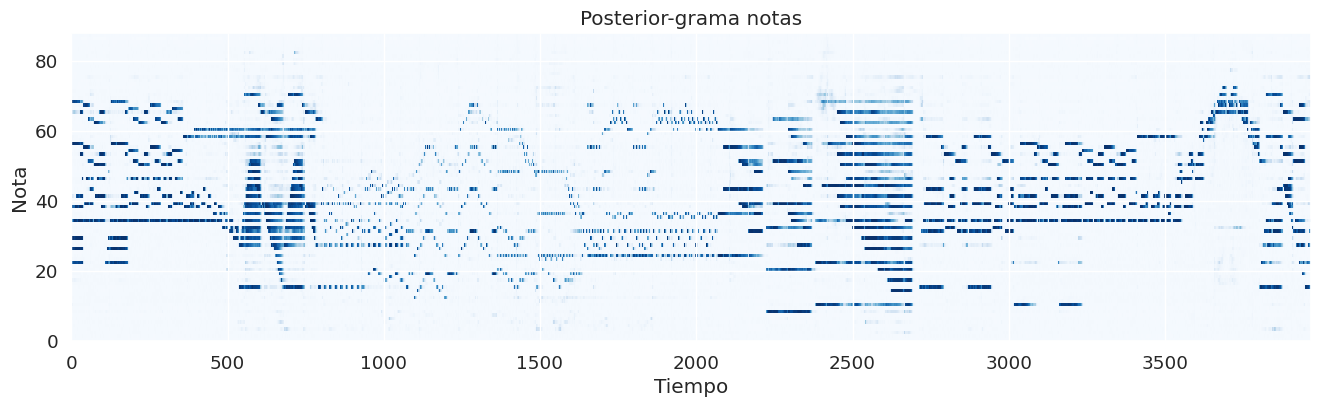

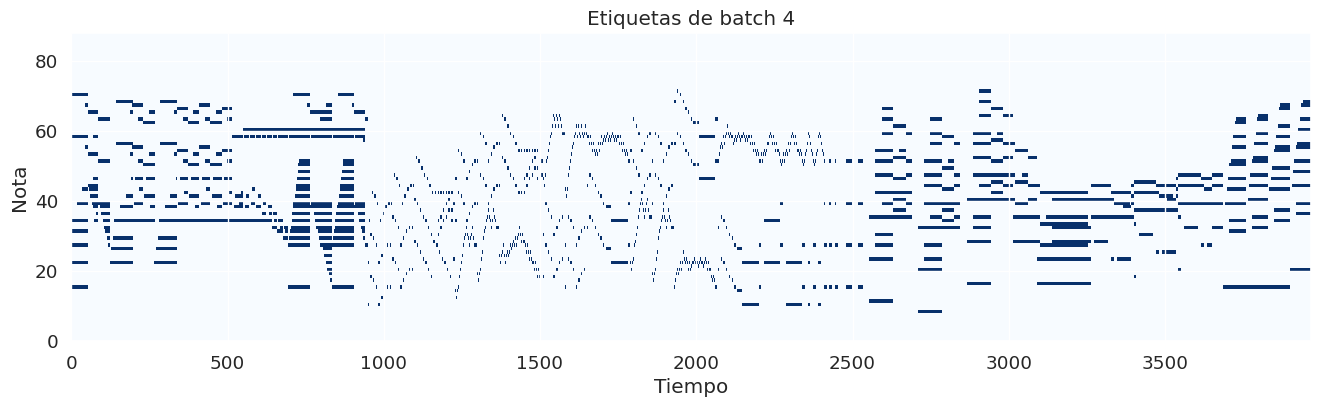

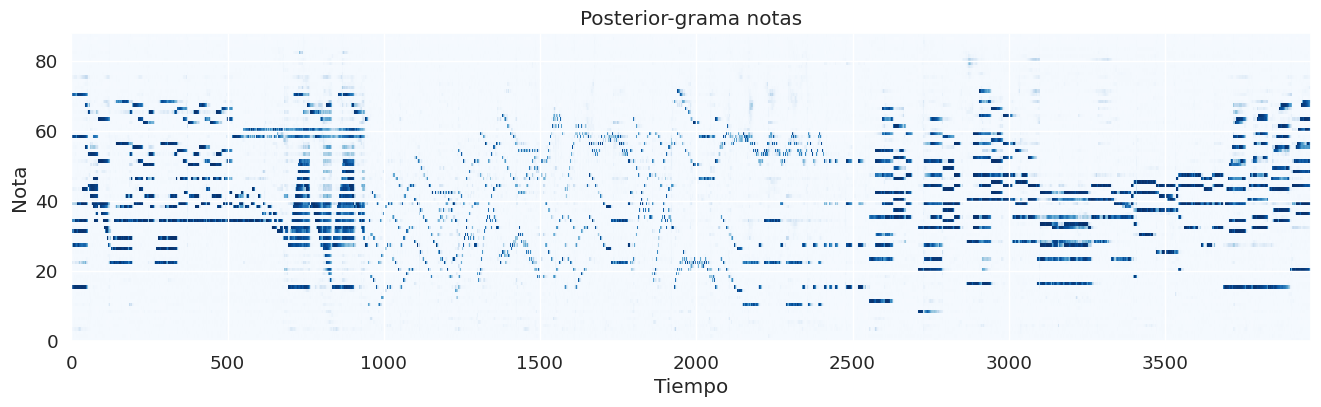

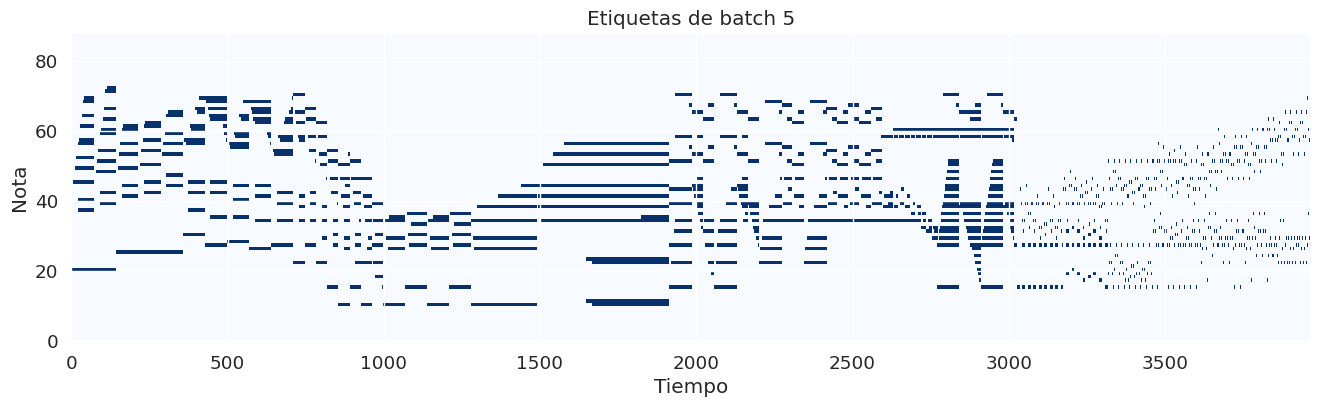

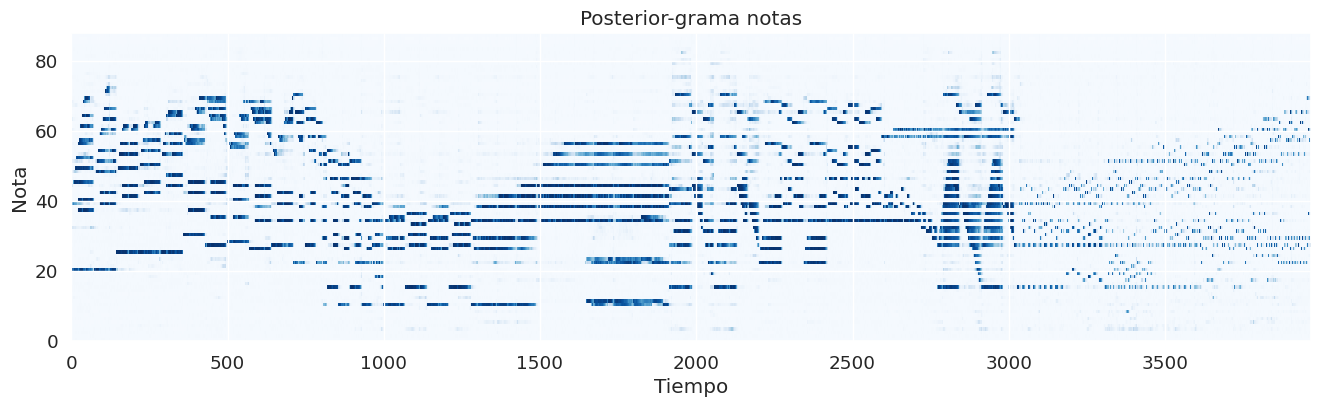

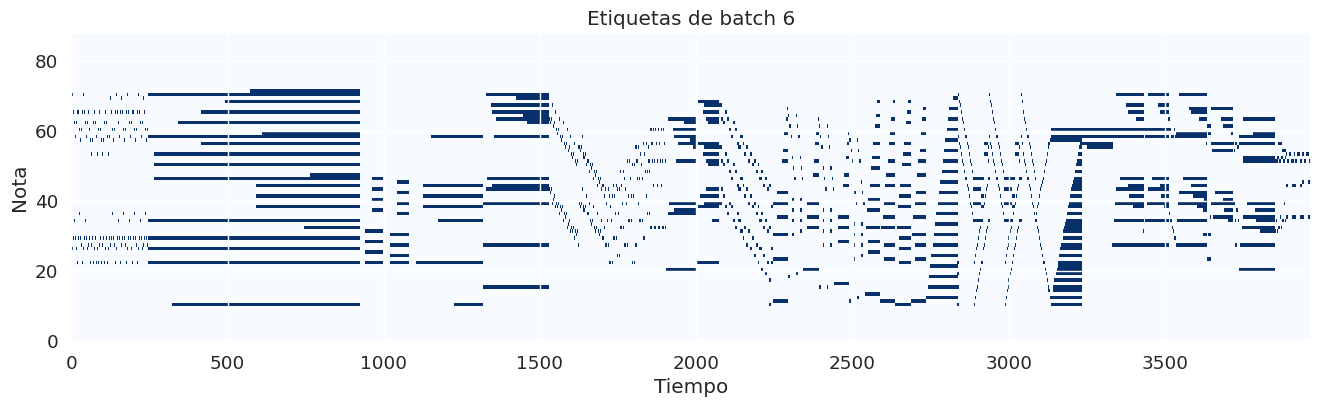

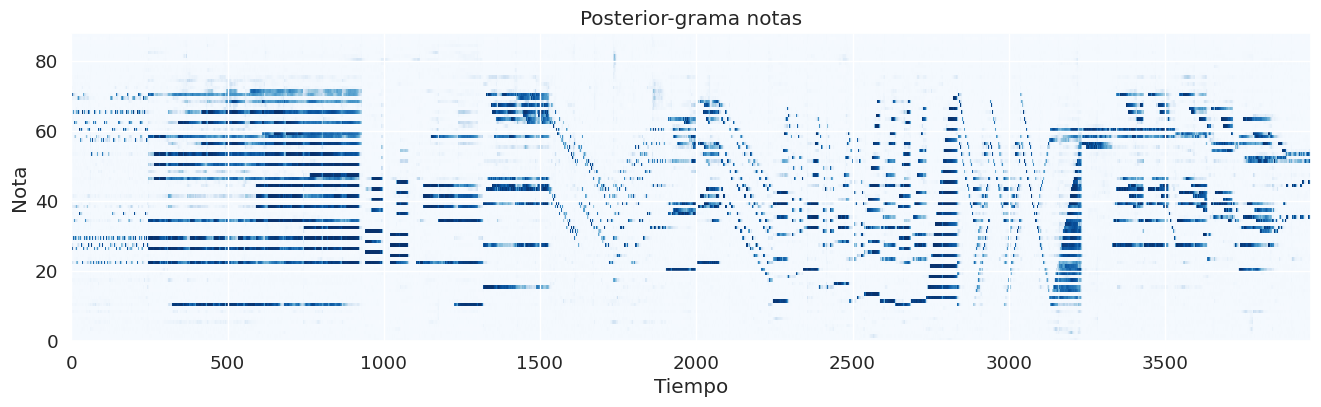

([], [])

In [ ]:
show_model_outputs(model, val_loader, onsets=False)

### Métricas generales a nivel de nota

In [ ]:
# Obtener eventos de nota de las etiquetas
label_note_events=[pianoroll_to_note_events(l) for l in val_dataset.labels]

# Métricas sobre el onset
f1, precision, recall = get_note_wise_metrics(predicted_note_events, label_note_events, offset_ratio=None)
print("Onset F1:", f1)
print("Onset Precision:", precision)
print("Onset Recall:", recall)

# Métricas sobre onset y offset
f1, precision, recall = get_note_wise_metrics(predicted_note_events, label_note_events)
print("Note-wise F1:", f1)
print("Note-wise Precision:", precision)
print("Note-wise Recall:", recall)

/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:167: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")
/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:165: UserWarning: Reference notes are empty.
  warnings.warn("Reference notes are empty.")
/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:165: UserWarning: Reference notes are empty.
  warnings.warn("Reference notes are empty.")
/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:167: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")


Onset F1: 0.9111210180757072
Onset Precision: 0.9529212292476157
Onset Recall: 0.8728338661041297


/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:165: UserWarning: Reference notes are empty.
  warnings.warn("Reference notes are empty.")
/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:167: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")


Note-wise F1: 0.7908189457188404
Note-wise Precision: 0.8270999646767927
Note-wise Recall: 0.7575871306733619


### Métricas a nivel de nota por tono

In [ ]:
# Juntar pianorolls de todas las secciones
total_predicted_pianoroll=np.concatenate(predicted_pianorolls, axis=1)
total_label_pianoroll=np.concatenate(val_dataset.labels, axis=1)

pitch_f1s, pitch_precisions, pitch_recalls=get_onset_metrics_per_pitch(total_predicted_pianoroll, total_label_pianoroll)

print("Onset F1:", np.mean(pitch_f1s))
print("Onset Precision:", np.mean(pitch_precisions))
print("Onset Recall:", np.mean(pitch_recalls))

Onset F1: 0.8400137756442408
Onset Precision: 0.8732813678548382
Onset Recall: 0.8210742649342473


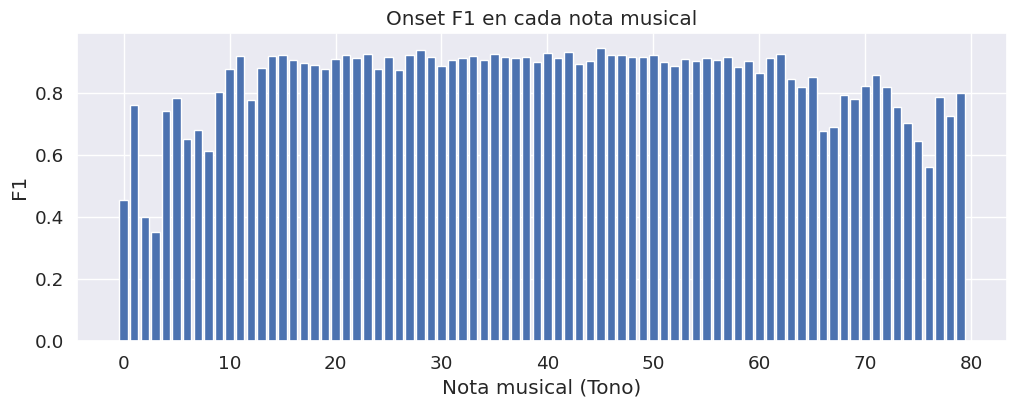

In [ ]:
show_pitch_f1s()

La longitud media de las notas predichas es: 0.5735584599081598
La longitud media de las notas en las etiquetas es: 0.5269859840298179
El número de notas que predice nuestro modelo es: 70775
El número de notas en nuestras etiquetas es: 77269


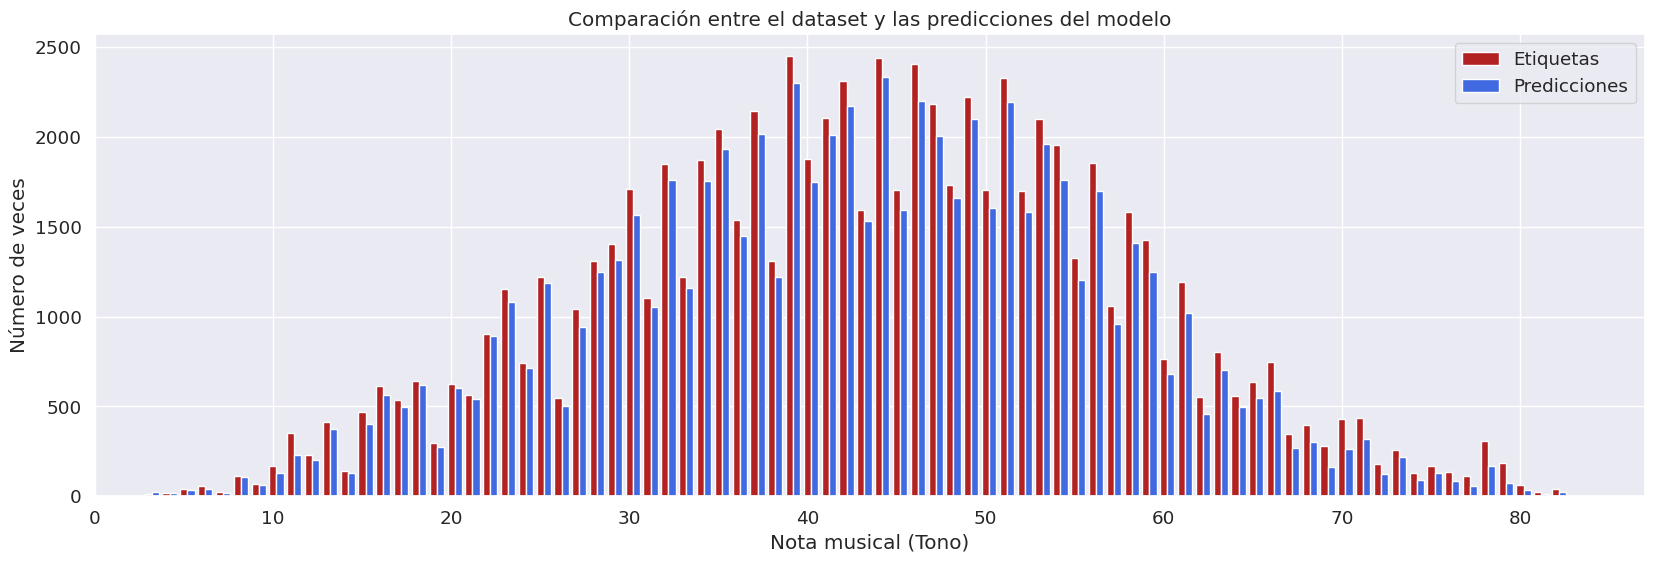

In [ ]:
# Obtener duraciones de notas predichas y de etiquetas
predicted_durations=[]
for pitch in predicted_note_events:
    for event in pitch:
        predicted_durations.append((event["end_time"] - event["start_time"]+1) * FRAME_DURATION)

label_durations=[]
for pitch in label_note_events:
    for event in pitch:
        label_durations.append((event["end_time"] - event["start_time"]+1) * FRAME_DURATION)

n_predicted_notes=count_pitch_from_note_events(predicted_note_events)
n_label_notes=count_pitch_from_note_events(label_note_events)

print("La longitud media de las notas predichas es:", np.mean(predicted_durations))
print("La longitud media de las notas en las etiquetas es:", np.mean(label_durations))

print("El número de notas que predice nuestro modelo es:", sum(n_predicted_notes))
print("El número de notas en nuestras etiquetas es:", sum(n_label_notes))

show_n_notes(n_predicted_notes, n_label_notes)

## Test

In [ ]:

# Rutas al dataset
data_paths = ["/content/ENSTDkAm", "/content/ENSTDkCl"]
test_dataset=create_test_dataset(data_paths, SpecDataset)

# Crear un DataLoader para el dataset
BATCH_SIZE = 64
num_workers = 0  # Número de procesos para cargar los datos

# Crear los DataLoaders para entrenamiento y validación
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

print("Número de ejemplos en test:", len(test_dataset))

Número de ejemplos en test: 7886


In [ ]:
# Obtener predicciones de un modelo (con post-procesado)
predicted_pianorolls, predicted_note_events=get_model_predictions(model, test_loader)

Batch 10 completado
Batch 20 completado
Batch 30 completado
Batch 40 completado
Batch 50 completado
Batch 60 completado
Batch 70 completado
Batch 80 completado
Batch 90 completado
Batch 100 completado
Batch 110 completado
Batch 120 completado


### Métricas a nivel de frame

Accuracy: 0.3519405561509576
Precision: 0.8438692696429453
Recall: 0.7950273807699261
F1 Score: 0.8187205398063973


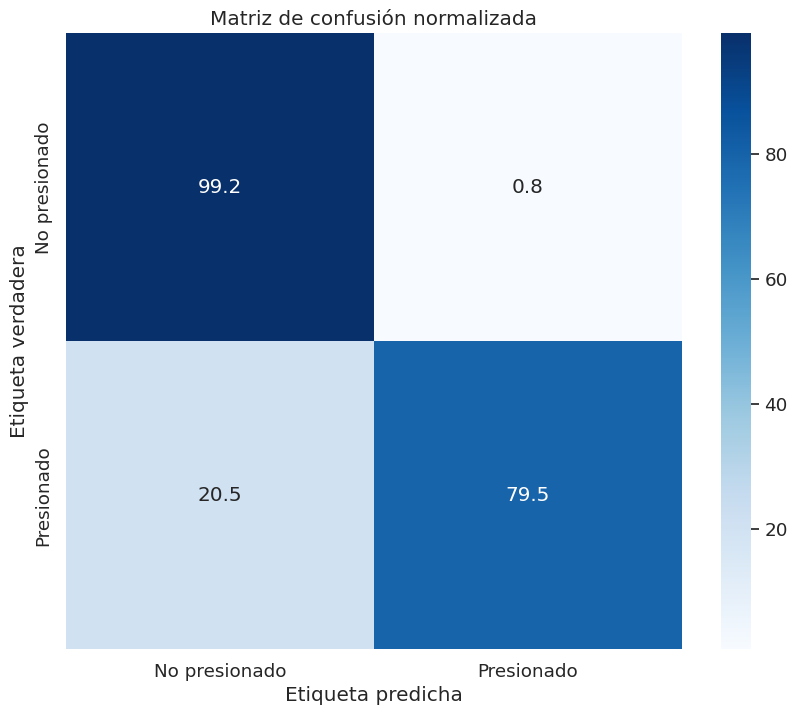

In [ ]:

# Concatenar predicciones y etiquetas de todas las secciones por frames
frame_labels = np.concatenate(test_dataset.labels, axis=1).T
frame_predictions=np.concatenate(predicted_pianorolls, axis=1).T

accuracy, precision, recall, f1=get_frame_metrics(frame_predictions, frame_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

show_confusion_matrix(frame_predictions, frame_labels)

### Métricas generales a nivel de nota

In [ ]:
# Obtener eventos de nota de las etiquetas
label_note_events=[pianoroll_to_note_events(l) for l in test_dataset.labels]

# Métricas sobre el onset
f1, precision, recall = get_note_wise_metrics(predicted_note_events, label_note_events, offset_ratio=None)
print("Onset F1:", f1)
print("Onset Precision:", precision)
print("Onset Recall:", recall)

# Métricas sobre onset y offsetn
f1, precision, recall = get_note_wise_metrics(predicted_note_events, label_note_events)
print("Note-wise F1:", f1)
print("Note-wise Precision:", precision)
print("Note-wise Recall:", recall)

/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:165: UserWarning: Reference notes are empty.
  warnings.warn("Reference notes are empty.")
/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:167: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")


Onset F1: 0.7698539647096291
Onset Precision: 0.8115413922398509
Onset Recall: 0.7322401023797854
Note-wise F1: 0.5854222355816542
Note-wise Precision: 0.6171227244264386
Note-wise Recall: 0.5568194194848336


/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:165: UserWarning: Reference notes are empty.
  warnings.warn("Reference notes are empty.")
/usr/local/lib/python3.10/dist-packages/mir_eval/transcription.py:167: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")
